# Modeling and Inferential Analysis

In [4]:
# Loading any necessary libraries and functions
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, accuracy_score, f1_score, roc_curve, log_loss, mean_squared_error, brier_score_loss, r2_score, make_scorer, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from statsmodels.api import GLM, families
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import DataLoader, TensorDataset
import json

## Analysis
The analysis will be composed of 4 parts. The objective of this analysis is to evaluate whether a given game's home and away odds are considered value bets. One potential insight is that using multi-sport odds can improve this evaluation of value bet consideration because the odds market may not efficiently set odds with other sports in mind.

In Part 1, I will first assess value bets by using a historically adjusted win rate for a team. This involves no modeling and is a simple calculation that shall act as my baseline for evaluating value bets. What this calculation involves is essentially comparing the historical win rate for a given team conditional on it being the home or the away team and the current implied probability of winning (conditional on the team being home or away). If the difference is positive, then it is a value bet. Then I will count the number of value bets derived from my model.

In the next few Parts, I will use modeling to predict the probability of winning for a team  based on various factors and then compare it to the implied probability of winning for that team of that specific game.

In Part 2, I will assess value bets by using Random Forests first to predict win probabilities and then I will use these predicted probabilities and compare them to the implied probabilities based on the current game's odds set by the bookies. I will then determine whether or not the predicted probabilites outputted by the model are considered value bets by seeing if the difference is greater than 0. 

In Part 3, I will assess value bets by using a Collaborative Filtering Neural Network to predict win probabilities. The procedure to compare probabilities to determine value bets is the same. In this part, I will train a "base" neural network that has shared embeddings from different sports and then use that to determine win probabilities.

In Part 4, I will assess value bets by using a simple FeedForward Neural Network that is trained on only one sport. I will compare the Collaborative Filtering model and the feedforward model and see which one does better on a held out basketball season.

For each part, you should the run the code separately.

In [5]:
# Reading in the data
main_df = pd.read_csv('deviations_df.csv')
main_df.columns

Index(['game_id', 'home_team', 'away_team', 'home_score', 'away_score',
       'avg_home_odds', 'avg_draw_odds', 'avg_away_odds', 'high_home_odds',
       'high_draw_odds', 'high_away_odds', 'date', 'sport', 'season',
       'avg_odds_ratio', 'high_odds_ratio', 'hteam_w_streak', 'ateam_w_streak',
       'hteam_l_streak', 'ateam_l_streak', 'hteam_win', 'roll_avg_home_odds',
       'roll_avg_away_odds', 'roll_high_home_odds', 'roll_high_away_odds',
       'upset', 'home_wr_favored', 'away_wr_favored', 'home_wr_underdog',
       'away_wr_underdog', 'roll_home_scorediff', 'roll_away_scorediff',
       'home_team_elo', 'away_team_elo', 'sim_home_team_elo',
       'sim_away_team_elo', 'bookmaker_name', 'home_odds', 'draw_odds',
       'away_odds', 'game_dev_home_odds', 'game_dev_away_odds',
       'game_dev_draw_odds'],
      dtype='object')

## Part 1

In [8]:
# For draw odds, put 0 if NaN
main_df['avg_draw_odds'] = np.where(main_df['avg_draw_odds'].isna(), 0, main_df['avg_draw_odds'])
main_df['draw_odds'] = np.where(main_df['draw_odds'].isna(), 0, main_df['draw_odds'])

# Target encoding for home and away team since adding these teams as one-hot vectors would be too many dimensions
# home_team_means = main_df.groupby('home_team')['adj_wr_home'].mean()
# away_team_means = main_df.groupby('away_team')['adj_wr_away'].mean()
# main_df['home_team_encoded'] = main_df['home_team'].map(home_team_means)
# main_df['away_team_encoded'] = main_df['away_team'].map(away_team_means)

home_team_upset_means = main_df.groupby('home_team')['upset'].mean()
away_team_upset_means = main_df.groupby('away_team')['upset'].mean()
main_df['home_team_upset'] = main_df['home_team'].map(home_team_upset_means)
main_df['away_team_upset'] = main_df['away_team'].map(away_team_upset_means)

# Calculate Elo difference between teams -- make it so that the value is always positive
# conditions = [main_df['home_team_elo'] > main_df['away_team_elo'], main_df['home_team_elo'] < main_df['away_team_elo'], main_df['home_team_elo'] == main_df['away_team_elo']]
# choices = [main_df['home_team_elo'] - main_df['away_team_elo'], main_df['away_team_elo'] - main_df['home_team_elo'], 0]
# main_df['elo_diff'] = np.select(conditions, choices)
main_df['elo_diff'] = main_df['home_team_elo'] - main_df['away_team_elo']

# conditions2 = [main_df['sim_home_team_elo'] > main_df['sim_away_team_elo'], main_df['sim_home_team_elo'] < main_df['sim_away_team_elo'], main_df['sim_home_team_elo'] == main_df['sim_away_team_elo']]
# choices2 = [main_df['sim_home_team_elo'] - main_df['sim_away_team_elo'], main_df['sim_away_team_elo'] - main_df['sim_home_team_elo'], 0]
# main_df['sim_elo_diff'] = np.select(conditions2, choices2)
# main_df['sim_elo_diff'] = main_df['sim_home_team_elo'] - main_df['sim_away_team_elo']

# Calculate underdog win -- similar to upset
main_df['elo_discrepancy'] = pd.cut(main_df['elo_diff'], bins=[-float('inf'), -50, 50, float('inf')], labels=[-1, 0, 1])

# Determine the favored team based on odds and Elo
# Home is favored
main_df['home_favored_by_odds'] = (main_df['avg_home_odds'] < main_df['avg_away_odds']).astype(int)
main_df['home_favored_by_elo'] = (main_df['home_team_elo'] < main_df['away_team_elo']).astype(int)
# Away is favored
main_df['away_favored_by_odds'] = (main_df['avg_home_odds'] > main_df['avg_away_odds']).astype(int)
main_df['away_favored_by_elo'] = (main_df['home_team_elo'] > main_df['away_team_elo']).astype(int)
# Mismatch between odds and Elo
# Home mismatch: Odds favor home, but Elo does not (or vice versa)
main_df['home_odds_elo_mismatch'] = (main_df['home_favored_by_odds'] != main_df['home_favored_by_elo']).astype(int)
# Away mismatch: Odds favor away, but Elo does not (or vice versa)
main_df['away_odds_elo_mismatch'] = (main_df['away_favored_by_odds'] != main_df['away_favored_by_elo']).astype(int)

# SAVE for DASH
features_to_save = [
    ('home_team', 'home_wr_favored', 'home_wr_favored.json'),
    ('away_team', 'away_wr_favored', 'away_wr_favored.json'),
    ('home_team', 'home_wr_underdog', 'home_wr_underdog.json'),
    ('away_team', 'away_wr_underdog', 'away_wr_underdog.json'),
    ('home_team', 'home_team_upset', 'home_team_upset.json'),
    ('away_team', 'away_team_upset', 'away_team_upset.json')]

for team_column, feature_column, output_file in features_to_save:
    data = main_df.drop_duplicates(subset=[team_column]).set_index(team_column)[feature_column].to_dict()
    with open(output_file, 'w') as f:
        json.dump(data, f)

# Calculate implied probability for current odds
main_df['implied_home_prob'] = main_df['avg_home_odds'].apply(lambda x: 100 / (x + 100) if x > 0 else abs(x) / (abs(x) + 100))
main_df['implied_away_prob'] = main_df['avg_away_odds'].apply(lambda x: 100 / (x + 100) if x > 0 else abs(x) / (abs(x) + 100))
main_df['implied_draw_prob'] = main_df['avg_draw_odds'].apply(lambda x: 100 / (x + 100) if x > 0 else abs(x) / (abs(x) + 100))

# Impute the mean for some entries of rolling odds if they are missing
for col in ['roll_avg_home_odds', 'roll_avg_away_odds', 'roll_high_home_odds', 'roll_high_away_odds']:
    main_df[col] = main_df[col].fillna(main_df[col].mean()) 

# Define a general function to convert odds (in American format to decimal format)
# If the odds are 0 or NaN, keep it at 0
def american_to_decimal(odds):
    if odds == 0 or pd.isna(odds):
        return 0
    return (1 + odds / 100) if odds > 0 else (1 + 100 / abs(odds))

# Convert odds
main_df['decimal_home_odds'] = main_df['avg_home_odds'].apply(american_to_decimal)
main_df['decimal_away_odds'] = main_df['avg_away_odds'].apply(american_to_decimal)

main_df['ev_home'] = (
    main_df['hteam_win'] * (main_df['implied_home_prob'] * (main_df['decimal_home_odds'] - 1))
    - (1 - main_df['hteam_win']))

main_df['ev_away'] = (
    (1 - main_df['hteam_win']) * (main_df['implied_away_prob'] * (main_df['decimal_away_odds'] - 1))
    - main_df['hteam_win'])

# Find the average bookmaker margin (across all bookmakers and games in the data)
main_df['sum_implied_probs'] = main_df['implied_home_prob'] + main_df['implied_away_prob'] + main_df['implied_draw_prob']
main_df['margin'] = main_df['sum_implied_probs'] - 1 
average_margin = main_df['margin'].mean()
print(f"The average margin added by bookmakers is: {average_margin:.4%}")

# Group by bookmaker_name and calculate margins
main_df['book_home_prob'] = main_df['home_odds'].apply(lambda x: 100 / (x + 100) if x > 0 else abs(x) / (abs(x) + 100))
main_df['book_away_prob'] = main_df['away_odds'].apply(lambda x: 100 / (x + 100) if x > 0 else abs(x) / (abs(x) + 100))
main_df['book_draw_prob'] = main_df['draw_odds'].apply(lambda x: 100 / (x + 100) if x > 0 else abs(x) / (abs(x) + 100))

main_df['sum_book_probs'] = main_df['book_home_prob'] + main_df['book_away_prob'] + main_df['book_draw_prob']
main_df['book_margin'] = main_df['sum_book_probs'] - 1 
average_margin_by_bookmaker = main_df.groupby('bookmaker_name')['book_margin'].mean()
print(average_margin_by_bookmaker)

average_margin_by_bookmaker_by_sport = main_df.groupby(['bookmaker_name','sport'])['book_margin'].mean()
print(average_margin_by_bookmaker_by_sport)

###
# Define the holdout set for basketball for the 2022-2023 season
# holdout_bball_df = main_df[(main_df['season'] == '2022-2023') & (main_df['sport'] == 'basketball')]

# Define the holdout set for american football for the 2022-2023 season <- to be used as the out of sample test for bball model
# holdout_af_df = main_df[(main_df['season'] == '2022-2023') & (main_df['sport'] == 'american-football')]

# Update main_df to exclude only basketball data from the 2022-2023 season
# main_df = main_df[~((main_df['season'] == '2022-2023') & (main_df['sport'] == 'basketball'))]

# Remove all games that ended in a draw for main_df
main_df = main_df.dropna(subset = 'hteam_win')

# Initialize empty DataFrames for train, validation, and test sets
train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

# Loop through each sport to split data while maintaining proportions
for sport in main_df['sport'].unique():
    sport_data = main_df[main_df['sport'] == sport]
    
    # Split sport_data into train (80%) and temp (20%)
    sport_train, sport_temp = train_test_split(sport_data, test_size=0.2, random_state=42, stratify=sport_data['season'])
    
    # Split temp into validation (10%) and test (10%) of original dataset
    sport_validation, sport_test = train_test_split(sport_temp, test_size=0.5, random_state=42, stratify=sport_temp['season'])
    
    # Append splits for each sport
    train_df = pd.concat([train_df, sport_train])
    val_df = pd.concat([val_df, sport_validation])
    test_df = pd.concat([test_df, sport_test])

# Display the sizes to confirm split
print(f"Train set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")
print(f"Test set size: {test_df.shape}")
#print(f"Holdout set size: {holdout_bball_df.shape}")

The average margin added by bookmakers is: 4.0225%
bookmaker_name
10x10bet        0.048341
1xBet           0.024939
Alphabet        0.042436
BetInAsia       0.027669
GGBET           0.045621
Lasbet          0.033577
Marsbet         0.056071
Pinnacle        0.026274
Unibet          0.039153
VOBET           0.045811
Vulkan Bet      0.062955
William Hill    0.043559
bet-at-home     0.060323
bet365          0.040896
Name: book_margin, dtype: float64
bookmaker_name  sport            
10x10bet        american-football    0.058217
                basketball           0.053802
                football             0.027896
1xBet           american-football    0.042549
                basketball           0.020925
                football             0.024165
Alphabet        american-football    0.057401
                basketball           0.042551
                football             0.031171
BetInAsia       american-football    0.029793
                basketball           0.028204
          

## Part 2

In this section, I will use the adjusted historical win rate for each team as a baseline model to identify value bets. 

In [ ]:
# Create a copy to keep original test data set
test_df_copy = test_df.copy()

In [ ]:
# Calculate the value bets by comparing the adjusted historical win rate to the test data
test_df_copy['model_home_value'] = (test_df_copy['home_team_encoded'] * test_df_copy['decimal_home_odds']) - 1
test_df_copy['model_away_value'] = (test_df_copy['away_team_encoded'] * test_df_copy['decimal_away_odds']) - 1

test_df_copy['home_vb'] = (test_df_copy['model_home_value'] > 0.05).astype(int)
test_df_copy['away_vb'] = (test_df_copy['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_df_copy['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_df_copy['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- use a $10 wager
test_df_copy['ev_home'] = 10 * ((test_df_copy['home_team_encoded'] * (test_df_copy['decimal_home_odds'] - 1)) - (1 - test_df_copy['home_team_encoded']))
test_df_copy['ev_away'] = 10 * ((test_df_copy['away_team_encoded'] * (test_df_copy['decimal_away_odds'] - 1)) - (1 - test_df_copy['away_team_encoded']))

# Calculate value and non-value bets
test_df_copy['correct_home_value_bet'] = np.where((test_df_copy['home_vb'] == 1) & (test_df_copy['hteam_win'] == 1), 1, 0)
test_df_copy['correct_away_value_bet'] = np.where((test_df_copy['away_vb'] == 1) & (test_df_copy['hteam_win'] == 0), 1, 0)
test_df_copy['correct_home_non_value_bet'] = np.where((test_df_copy['home_vb'] == 0) & (test_df_copy['hteam_win'] == 1), 1, 0)
test_df_copy['correct_away_non_value_bet'] = np.where((test_df_copy['away_vb'] == 0) & (test_df_copy['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets
test_df_copy['home_vb_payout'] = np.where(test_df_copy['correct_home_value_bet'] == 1,
                                       (test_df_copy['decimal_home_odds'] * 10) - 10, -10)
test_df_copy['away_vb_payout'] = np.where(test_df_copy['correct_away_value_bet'] == 1,
                                       (test_df_copy['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_df_copy['home_non_value_payout'] = np.where(test_df_copy['correct_home_non_value_bet'] == 1,
                                       (test_df_copy['decimal_home_odds'] * 10) - 10, -10)
test_df_copy['away_non_value_payout'] = np.where(test_df_copy['correct_away_non_value_bet'] == 1,
                                       (test_df_copy['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- use a $10 wager
#test_df_copy['home_actual_payout'] = np.where(test_df_copy['hteam_win'] == 1, np.where(test_df_copy['avg_home_odds'] > 0, 
        #(test_df_copy['avg_home_odds'] / 100) * 10, (100 / abs(test_df_copy['avg_home_odds'])) * 10), -10)
test_df_copy['home_actual_payout'] = np.where(test_df_copy['hteam_win'] == 1, (test_df_copy['decimal_home_odds'] - 1) * 10, -10)

#test_df_copy['away_actual_payout'] = np.where(test_df_copy['hteam_win'] == 0, np.where(test_df_copy['avg_away_odds'] > 0, 
        #(test_df_copy['avg_away_odds'] / 100) * 10, (100 / abs(test_df_copy['avg_away_odds'])) * 10), -10)
test_df_copy['away_actual_payout'] = np.where(test_df_copy['hteam_win'] == 0, (test_df_copy['decimal_away_odds'] - 1) * 10, -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_df_copy['home_payout_diff'] = test_df_copy['home_vb_payout'] - test_df_copy['home_actual_payout']
test_df_copy['away_payout_diff'] = test_df_copy['away_vb_payout'] - test_df_copy['away_actual_payout']
test_df_copy['home_vb_payout_diff'] = test_df_copy['home_vb_payout'] - test_df_copy['home_non_value_payout']
test_df_copy['away_vb_payout_diff'] = test_df_copy['away_vb_payout'] - test_df_copy['away_non_value_payout']

# Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_df_copy['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_df_copy['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_df_copy['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_df_copy['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_df_copy['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_df_copy['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_df_copy['home_vb_payout'][test_df_copy['home_vb'] == 1].sum()
total_away_vb_payout = test_df_copy['away_vb_payout'][test_df_copy['away_vb'] == 1].sum()
total_home_non_value_payout = test_df_copy['home_non_value_payout'][test_df_copy['home_vb'] == 0].sum()
total_away_non_value_payout = test_df_copy['away_non_value_payout'][test_df_copy['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_df_copy['home_actual_payout'].sum()
total_away_actual_payout = test_df_copy['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_df_copy['home_vb'].sum() * 10
total_away_value_bet_amount = test_df_copy['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_df_copy['home_vb'] == 0).sum() * 10
total_away_non_value_bet_amount = (test_df_copy['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_df_copy) * 10
total_away_actual_bet_amount = len(test_df_copy) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_df_copy['correct_home_value_bet'].sum()
mean_away_payout_per_value_bet = total_away_vb_payout / test_df_copy['correct_away_value_bet'].sum()
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_df_copy['correct_home_non_value_bet'].sum()
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_df_copy['correct_away_non_value_bet'].sum()

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_df_copy.loc[test_df_copy['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_df_copy['ev_home'].mean()
avg_ev_home_non_value_bets = test_df_copy.loc[test_df_copy['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_df_copy.loc[test_df_copy['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_df_copy['ev_away'].mean()
avg_ev_away_non_value_bets = test_df_copy.loc[test_df_copy['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (test_df_copy['home_team_encoded'] > 0.5).astype(int)
y_pred_away_binary = (test_df_copy['away_team_encoded'] > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(test_df_copy['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - test_df_copy['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
brier_score_home = brier_score_loss(test_df_copy['hteam_win'], test_df_copy['home_team_encoded'])
brier_score_away = brier_score_loss(1 - test_df_copy['hteam_win'], test_df_copy['away_team_encoded'])

# Calculate F1 Score
home_f1 = f1_score(test_df_copy['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - test_df_copy['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Brier Score Home: {brier_score_home:.4f}")
print(f"Brier Score Away: {brier_score_away:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

In [ ]:
# Create a copy of the holdout basketball data set
holdout_bball_df_c = holdout_bball_df.copy()

In [ ]:
# Calculate the value bets by comparing the adjusted historical win rate to the test data
holdout_bball_df_c['model_home_value'] = (holdout_bball_df_c['home_team_encoded'] * holdout_bball_df_c['decimal_home_odds']) - 1
holdout_bball_df_c['model_away_value'] = (holdout_bball_df_c['away_team_encoded'] * holdout_bball_df_c['decimal_away_odds']) - 1

holdout_bball_df_c['home_vb'] = (holdout_bball_df_c['model_home_value'] > 0.05).astype(int)
holdout_bball_df_c['away_vb'] = (holdout_bball_df_c['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df_c['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df_c['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on a $10 wager
holdout_bball_df_c['ev_home'] = 10 * ((holdout_bball_df_c['home_team_encoded'] * (holdout_bball_df_c['decimal_home_odds'] - 1)) - (1 - holdout_bball_df_c['home_team_encoded']))
holdout_bball_df_c['ev_away'] = 10 * ((holdout_bball_df_c['away_team_encoded'] * (holdout_bball_df_c['decimal_away_odds'] - 1)) - (1 - holdout_bball_df_c['away_team_encoded']))

# Calculate value and non-value bets
holdout_bball_df_c['correct_home_value_bet'] = np.where((holdout_bball_df_c['home_vb'] == 1) & (holdout_bball_df_c['hteam_win'] == 1), 1, 0)
holdout_bball_df_c['correct_away_value_bet'] = np.where((holdout_bball_df_c['away_vb'] == 1) & (holdout_bball_df_c['hteam_win'] == 0), 1, 0)
holdout_bball_df_c['correct_home_non_value_bet'] = np.where((holdout_bball_df_c['home_vb'] == 0) & (holdout_bball_df_c['hteam_win'] == 1), 1, 0)
holdout_bball_df_c['correct_away_non_value_bet'] = np.where((holdout_bball_df_c['away_vb'] == 0) & (holdout_bball_df_c['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets
holdout_bball_df_c['home_vb_payout'] = np.where(holdout_bball_df_c['correct_home_value_bet'] == 1,
                                       (holdout_bball_df_c['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df_c['away_vb_payout'] = np.where(holdout_bball_df_c['correct_away_value_bet'] == 1,
                                       (holdout_bball_df_c['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df_c['home_non_value_payout'] = np.where(holdout_bball_df_c['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df_c['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df_c['away_non_value_payout'] = np.where(holdout_bball_df_c['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df_c['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on a $10 wager
holdout_bball_df_c['home_actual_payout'] = np.where(holdout_bball_df_c['hteam_win'] == 1, np.where(holdout_bball_df_c['avg_home_odds'] > 0, 
        (holdout_bball_df_c['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df_c['avg_home_odds'])) * 10), -10)

holdout_bball_df_c['away_actual_payout'] = np.where(holdout_bball_df_c['hteam_win'] == 0, np.where(holdout_bball_df_c['avg_away_odds'] > 0, 
        (holdout_bball_df_c['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df_c['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df_c['home_payout_diff'] = holdout_bball_df_c['home_vb_payout'] - holdout_bball_df_c['home_actual_payout']
holdout_bball_df_c['away_payout_diff'] = holdout_bball_df_c['away_vb_payout'] - holdout_bball_df_c['away_actual_payout']
holdout_bball_df_c['home_vb_payout_diff'] = holdout_bball_df_c['home_vb_payout'] - holdout_bball_df_c['home_non_value_payout']
holdout_bball_df_c['away_vb_payout_diff'] = holdout_bball_df_c['away_vb_payout'] - holdout_bball_df_c['away_non_value_payout']

# Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df_c['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df_c['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df_c['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df_c['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df_c['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df_c['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df_c['home_vb_payout'][holdout_bball_df_c['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df_c['away_vb_payout'][holdout_bball_df_c['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df_c['home_non_value_payout'][holdout_bball_df_c['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df_c['away_non_value_payout'][holdout_bball_df_c['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df_c['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df_c['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df_c['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df_c['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df_c['home_vb'] == 0).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df_c['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df_c) * 10
total_away_actual_bet_amount = len(holdout_bball_df_c) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df_c['correct_home_value_bet'].sum()
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df_c['correct_away_value_bet'].sum()
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df_c['correct_home_non_value_bet'].sum()
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df_c['correct_away_non_value_bet'].sum()

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df_c.loc[holdout_bball_df_c['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df_c['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df_c.loc[holdout_bball_df_c['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df_c.loc[holdout_bball_df_c['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df_c['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df_c.loc[holdout_bball_df_c['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (holdout_bball_df_c['home_team_encoded'] > 0.5).astype(int)
y_pred_away_binary = (holdout_bball_df_c['away_team_encoded'] > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(holdout_bball_df_c['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - holdout_bball_df_c['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
brier_score_home = brier_score_loss(holdout_bball_df_c['hteam_win'], holdout_bball_df_c['home_team_encoded'])
brier_score_away = brier_score_loss(1 - holdout_bball_df_c['hteam_win'], holdout_bball_df_c['away_team_encoded'])

# Calculate F1 Score
home_f1 = f1_score(holdout_bball_df_c['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - holdout_bball_df_c['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Brier Score Home: {brier_score_home:.4f}")
print(f"Brier Score Away: {brier_score_away:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

#print(np.sum(y_pred_away_binary == 1))
#print(holdout_bball_df_c['away_team_encoded'])

## Part 3: Random Forests

### RF BINARY

In [ ]:
# Create a copy of the data sets
train_df_rf = train_df.copy()
val_df_rf = val_df.copy()
test_df_rf = test_df.copy()

# Features and targets
game_features = [
    'avg_home_odds', 'avg_away_odds', 'avg_odds_ratio', 'hteam_w_streak', 'ateam_w_streak', 'hteam_l_streak', 'ateam_l_streak', 
    'home_wr_favored', 'away_wr_favored', 'home_wr_underdog', 'away_wr_underdog', 'home_team_upset', 'away_team_upset', 
    'home_team_elo', 'away_team_elo', 'elo_diff', 'elo_discrepancy', 'home_odds_elo_mismatch', 'away_odds_elo_mismatch']

# Preprocessor (Scaling only for game features)
preprocessorRF = ColumnTransformer(transformers=[('scaler', StandardScaler(), game_features)])

# Define the preprocessing and model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessorRF),
    ('model', RandomForestClassifier(random_state=42))])

# Define the hyperparameter grid
param_grid = {
    'model__n_estimators': [10, 20, 30, 40],
    'model__max_depth': [3, 5, 10, 15],
    'model__min_samples_split': [10, 20],
    'model__min_samples_leaf': [10, 20]}

# Drop rows with NaN values consistently
train_df_rf = train_df_rf.dropna(subset=game_features + ['hteam_win'])
val_df_rf = val_df_rf.dropna(subset=game_features + ['hteam_win'])
test_df_rf = test_df_rf.dropna(subset=game_features + ['hteam_win'])

# Initialize a dictionary to store results
model_results = {}
validation_metrics = {}

# Define the target variable
targets = ['hteam_win']

# Loop through each target variable
for target in targets:
    print(f"\nTraining RandomForestClassifier for target: {target}")
    
    # Split the data for the current target
    X_train = train_df_rf[game_features]
    y_train = train_df_rf[target]
    X_val = val_df_rf[game_features]
    y_val = val_df_rf[target]

    # Define GridSearchCV for the pipeline
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='accuracy',  # Scoring metric for classification
        cv=3,
        n_jobs=-1,
        verbose=1)
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Store the best model
    best_model = grid_search.best_estimator_
    model_results[target] = best_model
    
    # Make predictions on the validation set
    y_pred_val = best_model.predict(X_val)
    
    # Calculate accuracy on the validation set
    accuracy = accuracy_score(y_val, y_pred_val)
    print(f"Validation Accuracy for {target}: {accuracy:.4f}")
    
    # Store the validation accuracy
    validation_metrics[target] = accuracy

    # Print the confusion matrix
    cm = confusion_matrix(y_val, y_pred_val)
    print(f"Confusion Matrix for {target}:\n{cm}")

    # Print the classification report
    report = classification_report(y_val, y_pred_val)
    print(f"Classification Report for {target}:\n{report}")

# Print overall validation metrics
print("\nOverall Validation Metrics:")
for target, metric in validation_metrics.items():
    print(f"{target}: Accuracy = {metric:.4f}")

# Create a dictionary to store predicted results
predicted_probs = {}

for target in ['hteam_win']:
    y_pred_test = best_model.predict(test_df_rf[game_features])
    predicted_probs[target] = y_pred_test 

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_test_prob_home = np.array(predicted_probs.get('hteam_win', None))
y_pred_test_prob_away = 1 - np.array(predicted_probs.get('hteam_win', None))

test_df_rf['model_home_value'] = (y_pred_test_prob_home * test_df_rf['decimal_home_odds']) - 1
test_df_rf['model_away_value'] = (y_pred_test_prob_away * test_df_rf['decimal_away_odds']) - 1

test_df_rf['home_vb'] = (test_df_rf['model_home_value'] > 0.05).astype(int)
test_df_rf['away_vb'] = (test_df_rf['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_df_rf['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_df_rf['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on a $10 wager
test_df_rf['ev_home'] = 10 * ((y_pred_test_prob_home * (test_df_rf['decimal_home_odds'] - 1)) - (1 - y_pred_test_prob_home))
test_df_rf['ev_away'] = 10 * ((y_pred_test_prob_away * (test_df_rf['decimal_away_odds'] - 1)) - (1 - y_pred_test_prob_away))

# Calculate value and non-value bets
test_df_rf['correct_home_value_bet'] = np.where((test_df_rf['home_vb'] == 1) & (test_df_rf['hteam_win'] == 1), 1, 0)
test_df_rf['correct_away_value_bet'] = np.where((test_df_rf['away_vb'] == 1) & (test_df_rf['hteam_win'] == 0), 1, 0)
test_df_rf['correct_home_non_value_bet'] = np.where((test_df_rf['home_vb'] == 0) & (test_df_rf['hteam_win'] == 1), 1, 0)
test_df_rf['correct_away_non_value_bet'] = np.where((test_df_rf['away_vb'] == 0) & (test_df_rf['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_df_rf['home_vb_payout'] = np.where(test_df_rf['correct_home_value_bet'] == 1,
                                       (test_df_rf['decimal_home_odds'] * 10) - 10, -10)
test_df_rf['away_vb_payout'] = np.where(test_df_rf['correct_away_value_bet'] == 1,
                                       (test_df_rf['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_df_rf['home_non_value_payout'] = np.where(test_df_rf['correct_home_non_value_bet'] == 1,
                                       (test_df_rf['decimal_home_odds'] * 10) - 10, -10)
test_df_rf['away_non_value_payout'] = np.where(test_df_rf['correct_away_non_value_bet'] == 1,
                                       (test_df_rf['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on a $10 wager
# test_df_rf['home_actual_payout'] = np.where(test_df_rf['hteam_win'] == 1, np.where(test_df_rf['avg_home_odds'] > 0, 
#         (test_df_rf['avg_home_odds'] / 100) * 10, (100 / abs(test_df_rf['avg_home_odds'])) * 10), -10)
test_df_rf['home_actual_payout'] = np.where(test_df_rf['hteam_win'] == 1, (test_df_rf['decimal_home_odds'] - 1) * 10, -10)

# test_df_rf['away_actual_payout'] = np.where(test_df_rf['hteam_win'] == 0, np.where(test_df_rf['avg_away_odds'] > 0, 
#         (test_df_rf['avg_away_odds'] / 100) * 10, (100 / abs(test_df_rf['avg_away_odds'])) * 10), -10)
test_df_rf['away_actual_payout'] = np.where(test_df_rf['hteam_win'] == 0, (test_df_rf['decimal_away_odds'] - 1) * 10, -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_df_rf['home_payout_diff'] = test_df_rf['home_vb_payout'] - test_df_rf['home_actual_payout']
test_df_rf['away_payout_diff'] = test_df_rf['away_vb_payout'] - test_df_rf['away_actual_payout']
test_df_rf['home_vb_payout_diff'] = test_df_rf['home_vb_payout'] - test_df_rf['home_non_value_payout']
test_df_rf['away_vb_payout_diff'] = test_df_rf['away_vb_payout'] - test_df_rf['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_df_rf['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_df_rf['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_df_rf['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_df_rf['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_df_rf['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_df_rf['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_df_rf['home_vb_payout'][test_df_rf['home_vb'] == 1].sum()
total_away_vb_payout = test_df_rf['away_vb_payout'][test_df_rf['away_vb'] == 1].sum()
total_home_non_value_payout = test_df_rf['home_non_value_payout'][test_df_rf['home_vb'] == 0].sum()
total_away_non_value_payout = test_df_rf['away_non_value_payout'][test_df_rf['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_df_rf['home_actual_payout'].sum()
total_away_actual_payout = test_df_rf['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_df_rf['home_vb'].sum() * 10
total_away_value_bet_amount = test_df_rf['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_df_rf['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (test_df_rf['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_df_rf) * 10
total_away_actual_bet_amount = len(test_df_rf) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_df_rf['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_df_rf['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_df_rf['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_df_rf['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_df_rf.loc[test_df_rf['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_df_rf['ev_home'].mean()
avg_ev_home_non_value_bets = test_df_rf.loc[test_df_rf['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_df_rf.loc[test_df_rf['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_df_rf['ev_away'].mean()
avg_ev_away_non_value_bets = test_df_rf.loc[test_df_rf['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_test_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_test_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(test_df_rf['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - test_df_rf['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(test_df_rf['hteam_win'], y_pred_test_prob_home)
away_brier_score = brier_score_loss((1 - test_df_rf['hteam_win']), y_pred_test_prob_away)

# Calculate F1 Score
home_f1 = f1_score(test_df_rf['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - test_df_rf['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

In [ ]:
# Holdout Bball Data
holdout_bball_df_rf = holdout_bball_df.copy()
holdout_bball_df_rf = holdout_bball_df_rf.dropna(subset=game_features + ['hteam_win'])

# Create a dictionary to store the predicted results
predicted_probs_holdout = {}

for target in ['hteam_win']:    
    # Define test data
    X_holdout = holdout_bball_df_rf[game_features]
    y_holdout = holdout_bball_df_rf[target]
    
    # Use the trained model to predict
    y_pred_holdout = best_model.predict(X_holdout)
    predicted_probs_holdout[target] = y_pred_holdout 

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_holdout_prob_home = np.array(predicted_probs_holdout.get('hteam_win', None))
y_pred_holdout_prob_away = 1 - np.array(predicted_probs_holdout.get('hteam_win', None))

# Calculate the value bets by comparing the adjusted historical win rate to the test data
holdout_bball_df_rf['model_home_value'] = (y_pred_holdout_prob_home * holdout_bball_df_rf['decimal_home_odds']) - 1
holdout_bball_df_rf['model_away_value'] = (y_pred_holdout_prob_away * holdout_bball_df_rf['decimal_away_odds']) - 1

holdout_bball_df_rf['home_vb'] = (holdout_bball_df_rf['model_home_value'] > 0.05).astype(int)
holdout_bball_df_rf['away_vb'] = (holdout_bball_df_rf['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df_rf['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df_rf['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based ona $10 wager
holdout_bball_df_rf['ev_home'] = 10 * ((y_pred_holdout_prob_home * (holdout_bball_df_rf['decimal_home_odds'] - 1)) - (1 - y_pred_holdout_prob_home))
holdout_bball_df_rf['ev_away'] = 10 * ((y_pred_holdout_prob_away * (holdout_bball_df_rf['decimal_away_odds'] - 1)) - (1 - y_pred_holdout_prob_away))

# Calculate value and non-value bets
holdout_bball_df_rf['correct_home_value_bet'] = np.where((holdout_bball_df_rf['home_vb'] == 1) & (holdout_bball_df_rf['hteam_win'] == 1), 1, 0)
holdout_bball_df_rf['correct_away_value_bet'] = np.where((holdout_bball_df_rf['away_vb'] == 1) & (holdout_bball_df_rf['hteam_win'] == 0), 1, 0)
holdout_bball_df_rf['correct_home_non_value_bet'] = np.where((holdout_bball_df_rf['home_vb'] == 0) & (holdout_bball_df_rf['hteam_win'] == 1), 1, 0)
holdout_bball_df_rf['correct_away_non_value_bet'] = np.where((holdout_bball_df_rf['away_vb'] == 0) & (holdout_bball_df_rf['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets
holdout_bball_df_rf['home_vb_payout'] = np.where(holdout_bball_df_rf['correct_home_value_bet'] == 1,
                                       (holdout_bball_df_rf['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df_rf['away_vb_payout'] = np.where(holdout_bball_df_rf['correct_away_value_bet'] == 1,
                                       (holdout_bball_df_rf['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df_rf['home_non_value_payout'] = np.where(holdout_bball_df_rf['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df_rf['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df_rf['away_non_value_payout'] = np.where(holdout_bball_df_rf['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df_rf['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds
holdout_bball_df_rf['home_actual_payout'] = np.where(holdout_bball_df_rf['hteam_win'] == 1, np.where(holdout_bball_df_rf['avg_home_odds'] > 0, 
        (holdout_bball_df_rf['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df_rf['avg_home_odds'])) * 10), -10)

holdout_bball_df_rf['away_actual_payout'] = np.where(holdout_bball_df_rf['hteam_win'] == 0, np.where(holdout_bball_df_rf['avg_away_odds'] > 0, 
        (holdout_bball_df_rf['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df_rf['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df_rf['home_payout_diff'] = holdout_bball_df_rf['home_vb_payout'] - holdout_bball_df_rf['home_actual_payout']
holdout_bball_df_rf['away_payout_diff'] = holdout_bball_df_rf['away_vb_payout'] - holdout_bball_df_rf['away_actual_payout']
holdout_bball_df_rf['home_vb_payout_diff'] = holdout_bball_df_rf['home_vb_payout'] - holdout_bball_df_rf['home_non_value_payout']
holdout_bball_df_rf['away_vb_payout_diff'] = holdout_bball_df_rf['away_vb_payout'] - holdout_bball_df_rf['away_non_value_payout']

# Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df_rf['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df_rf['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df_rf['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df_rf['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df_rf['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df_rf['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df_rf['home_vb_payout'][holdout_bball_df_rf['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df_rf['away_vb_payout'][holdout_bball_df_rf['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df_rf['home_non_value_payout'][holdout_bball_df_rf['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df_rf['away_non_value_payout'][holdout_bball_df_rf['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df_rf['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df_rf['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df_rf['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df_rf['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df_rf['home_vb'] == 0).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df_rf['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df_rf) * 10
total_away_actual_bet_amount = len(holdout_bball_df_rf) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df_rf['correct_home_value_bet'].sum()
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df_rf['correct_away_value_bet'].sum()
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df_rf['correct_home_non_value_bet'].sum()
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df_rf['correct_away_non_value_bet'].sum()

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df_rf.loc[holdout_bball_df_rf['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df_rf['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df_rf.loc[holdout_bball_df_rf['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df_rf.loc[holdout_bball_df_rf['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df_rf['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df_rf.loc[holdout_bball_df_rf['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_holdout_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_holdout_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(holdout_bball_df_rf['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - holdout_bball_df_rf['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
brier_score_home = brier_score_loss(holdout_bball_df_rf['hteam_win'], y_pred_holdout_prob_home)
brier_score_away = brier_score_loss(1 - holdout_bball_df_rf['hteam_win'], y_pred_holdout_prob_away)

# Calculate F1 Score
home_f1 = f1_score(holdout_bball_df_rf['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - holdout_bball_df_rf['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Brier Score Home: {brier_score_home:.4f}")
print(f"Brier Score Away: {brier_score_away:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

### RF Continuous

In [ ]:
# Create a copy of the data sets
train_df_rf = train_df.copy()
val_df_rf = val_df.copy()
test_df_rf = test_df.copy()

# Features and targets
game_features = [
    'avg_odds_ratio', 'high_odds_ratio', 'game_dev_home_odds', 'game_dev_away_odds',
    'hteam_w_streak', 'ateam_w_streak', 'hteam_l_streak', 'ateam_l_streak',
    'roll_home_scorediff', 'roll_away_scorediff', 'home_team_elo', 'away_team_elo',
    'sim_home_team_elo', 'sim_away_team_elo', 'home_team_encoded', 'away_team_encoded', 'upset']

# Preprocessor (Scaling only for game features)
preprocessorRF = ColumnTransformer(transformers=[('scaler', StandardScaler(), game_features)])

# Define the preprocessing and model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessorRF),
    ('model', RandomForestRegressor(random_state=42))])

# Define the hyperparameter grid
param_grid = {
    'model__n_estimators': [10, 20, 30, 40],
    'model__max_depth': [3, 5, 10, 15],
    'model__min_samples_split': [10, 20],
    'model__min_samples_leaf': [10, 20]}

# Drop rows with NaN values consistently
train_df_rf = train_df_rf.dropna(subset=game_features + ['implied_home_prob', 'implied_away_prob'])
val_df_rf = val_df_rf.dropna(subset=game_features + ['implied_home_prob', 'implied_away_prob'])
test_df_rf = test_df_rf.dropna(subset=game_features + ['implied_home_prob', 'implied_away_prob'])

# Create a loss function for the RF model
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse_scorer, greater_is_better=False)

# Initialize a dictionary to store results
model_results = {}
validation_losses = {}

# Define the targets
targets = ['implied_home_prob', 'implied_away_prob']

# Loop through each target variable
for target in targets:
    print(f"\nTraining RandomForest for target: {target}")
    
    # Split the data for the current target
    X_train = train_df_rf[game_features]
    y_train = train_df_rf[target]
    X_val = val_df_rf[game_features]
    y_val = val_df_rf[target]
    
    # Define GridSearchCV for the pipeline
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=rmse_scorer, 
        cv=3,
        n_jobs=-1,
        verbose=1)
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Store the best model
    best_model = grid_search.best_estimator_
    model_results[target] = best_model
    
    # Make predictions on the validation set
    y_pred_val = best_model.predict(X_val)
    
    # Calculate the loss on the validation set
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    print(f"Validation RMSE for {target}: {rmse:.4f}")
    
    # Store the validation loss
    validation_losses[target] = rmse
    
    # Plot residuals distribution
    residuals = y_val - y_pred_val
    plt.figure(figsize=(7, 3))
    sns.histplot(residuals, kde=True, color='blue', alpha=0.6)
    plt.title(f'Residuals Distribution for {target}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.axvline(0, color='red', linestyle='--', label='Zero Residual')
    plt.legend()
    plt.show()
    
    # Scatter plot of residuals vs predicted values
    plt.figure(figsize=(7, 3))
    plt.scatter(y_pred_val, residuals, alpha=0.5, color='orange')
    plt.title(f'Residuals vs Predicted Values for {target}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.legend()
    plt.show()

# Print overall validation losses
print("\nOverall Validation Losses:")
for target, loss in validation_losses.items():
    print(f"{target}: RMSE = {loss:.4f}")

In [ ]:
# Dictionary to store predictions for each target
predicted_probs = {}

for target in ['implied_home_prob', 'implied_away_prob']:
    # Retrieve the correct model for the target
    model = model_results[target]
    
    # Make predictions using the retrieved model
    y_pred_test = model.predict(test_df_rf[game_features])
    predicted_probs[target] = y_pred_test

# Normalize probabilities
sum_probs = predicted_probs['implied_home_prob'] + predicted_probs['implied_away_prob']
normalized_home_probs = predicted_probs['implied_home_prob'] / sum_probs
normalized_away_probs = predicted_probs['implied_away_prob'] / sum_probs

# Update the dictionary with normalized probabilities
predicted_probs['home_win_prob'] = normalized_home_probs
predicted_probs['away_win_prob'] = normalized_away_probs

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_test_prob_home = np.array(predicted_probs.get('home_win_prob', None))
y_pred_test_prob_away = np.array(predicted_probs.get('away_win_prob', None))

test_df_rf['model_home_value'] = (y_pred_test_prob_home * test_df_rf['decimal_home_odds']) - 1
test_df_rf['model_away_value'] = (y_pred_test_prob_away * test_df_rf['decimal_away_odds']) - 1

test_df_rf['home_vb'] = (test_df_rf['model_home_value'] > 0.05).astype(int)
test_df_rf['away_vb'] = (test_df_rf['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_df_rf['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_df_rf['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on a $10 wager
test_df_rf['ev_home'] = 10 * ((y_pred_test_prob_home * (test_df_rf['decimal_home_odds'] - 1)) - (1 - y_pred_test_prob_home))
test_df_rf['ev_away'] = 10 * ((y_pred_test_prob_away * (test_df_rf['decimal_away_odds'] - 1)) - (1 - y_pred_test_prob_away))

# Calculate value and non-value bets
test_df_rf['correct_home_value_bet'] = np.where((test_df_rf['home_vb'] == 1) & (test_df_rf['hteam_win'] == 1), 1, 0)
test_df_rf['correct_away_value_bet'] = np.where((test_df_rf['away_vb'] == 1) & (test_df_rf['hteam_win'] == 0), 1, 0)
test_df_rf['correct_home_non_value_bet'] = np.where((test_df_rf['home_vb'] == 0) & (test_df_rf['hteam_win'] == 1), 1, 0)
test_df_rf['correct_away_non_value_bet'] = np.where((test_df_rf['away_vb'] == 0) & (test_df_rf['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_df_rf['home_vb_payout'] = np.where(test_df_rf['correct_home_value_bet'] == 1,
                                       (test_df_rf['decimal_home_odds'] * 10) - 10, -10)
test_df_rf['away_vb_payout'] = np.where(test_df_rf['correct_away_value_bet'] == 1,
                                       (test_df_rf['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_df_rf['home_non_value_payout'] = np.where(test_df_rf['correct_home_non_value_bet'] == 1,
                                       (test_df_rf['decimal_home_odds'] * 10) - 10, -10)
test_df_rf['away_non_value_payout'] = np.where(test_df_rf['correct_away_non_value_bet'] == 1,
                                       (test_df_rf['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on a $10 wager
test_df_rf['home_actual_payout'] = np.where(test_df_rf['hteam_win'] == 1, np.where(test_df_rf['avg_home_odds'] > 0, 
        (test_df_rf['avg_home_odds'] / 100) * 10, (100 / abs(test_df_rf['avg_home_odds'])) * 10), -10)

test_df_rf['away_actual_payout'] = np.where(test_df_rf['hteam_win'] == 0, np.where(test_df_rf['avg_away_odds'] > 0, 
        (test_df_rf['avg_away_odds'] / 100) * 10, (100 / abs(test_df_rf['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_df_rf['home_payout_diff'] = test_df_rf['home_vb_payout'] - test_df_rf['home_actual_payout']
test_df_rf['away_payout_diff'] = test_df_rf['away_vb_payout'] - test_df_rf['away_actual_payout']
test_df_rf['home_vb_payout_diff'] = test_df_rf['home_vb_payout'] - test_df_rf['home_non_value_payout']
test_df_rf['away_vb_payout_diff'] = test_df_rf['away_vb_payout'] - test_df_rf['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_df_rf['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_df_rf['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_df_rf['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_df_rf['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_df_rf['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_df_rf['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_df_rf['home_vb_payout'][test_df_rf['home_vb'] == 1].sum()
total_away_vb_payout = test_df_rf['away_vb_payout'][test_df_rf['away_vb'] == 1].sum()
total_home_non_value_payout = test_df_rf['home_non_value_payout'][test_df_rf['home_vb'] == 0].sum()
total_away_non_value_payout = test_df_rf['away_non_value_payout'][test_df_rf['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_df_rf['home_actual_payout'].sum()
total_away_actual_payout = test_df_rf['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_df_rf['home_vb'].sum() * 10
total_away_value_bet_amount = test_df_rf['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_df_rf['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (test_df_rf['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_df_rf) * 10
total_away_actual_bet_amount = len(test_df_rf) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_df_rf['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_df_rf['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_df_rf['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_df_rf['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_df_rf.loc[test_df_rf['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_df_rf['ev_home'].mean()
avg_ev_home_non_value_bets = test_df_rf.loc[test_df_rf['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_df_rf.loc[test_df_rf['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_df_rf['ev_away'].mean()
avg_ev_away_non_value_bets = test_df_rf.loc[test_df_rf['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_test_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_test_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(test_df_rf['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - test_df_rf['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(test_df_rf['hteam_win'], y_pred_test_prob_home)
away_brier_score = brier_score_loss((1 - test_df_rf['hteam_win']), y_pred_test_prob_away)

# Calculate F1 Score
home_f1 = f1_score(test_df_rf['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - test_df_rf['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

In [ ]:
# Holdout Bball Data
holdout_bball_df_rf = holdout_bball_df.copy()
holdout_bball_df_rf = holdout_bball_df_rf.dropna(subset=game_features + ['implied_home_prob','implied_away_prob'])

# Create a dictionary to store predicted results
predicted_probs_holdout = {}

for target in ['implied_home_prob', 'implied_away_prob']:
    # Retrieve the correct model for the target
    model = model_results[target]
    
    # Make predictions using the retrieved model
    y_pred_test = model.predict(holdout_bball_df_rf[game_features])
    predicted_probs_holdout[target] = y_pred_test

# Normalize probabilities
sum_probs_holdout = predicted_probs_holdout['implied_home_prob'] + predicted_probs_holdout['implied_away_prob']
normalized_home_probs_holdout = predicted_probs_holdout['implied_home_prob'] / sum_probs_holdout
normalized_away_probs_holdout = predicted_probs_holdout['implied_away_prob'] / sum_probs_holdout

# Update the dictionary with normalized probabilities
predicted_probs_holdout['home_win_prob'] = normalized_home_probs_holdout
predicted_probs_holdout['away_win_prob'] = normalized_away_probs_holdout

In [ ]:
# Calculate the value bets by comparing the model's predictions to the holdout data
y_pred_holdout_prob_home = np.array(predicted_probs_holdout.get('home_win_prob', None))
y_pred_holdout_prob_away = np.array(predicted_probs_holdout.get('away_win_prob', None))

# Calculate the value bets by comparing the adjusted historical win rate to the test data
holdout_bball_df_rf['model_home_value'] = (y_pred_holdout_prob_home * holdout_bball_df_rf['decimal_home_odds']) - 1
holdout_bball_df_rf['model_away_value'] = (y_pred_holdout_prob_away * holdout_bball_df_rf['decimal_away_odds']) - 1

holdout_bball_df_rf['home_vb'] = (holdout_bball_df_rf['model_home_value'] > 0.05).astype(int)
holdout_bball_df_rf['away_vb'] = (holdout_bball_df_rf['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df_rf['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df_rf['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on a $10 wager
holdout_bball_df_rf['ev_home'] = 10 * ((y_pred_holdout_prob_home * (holdout_bball_df_rf['decimal_home_odds'] - 1)) - (1 - y_pred_holdout_prob_home))
holdout_bball_df_rf['ev_away'] = 10 * ((y_pred_holdout_prob_away * (holdout_bball_df_rf['decimal_away_odds'] - 1)) - (1 - y_pred_holdout_prob_away))

# Calculate value and non-value bets
holdout_bball_df_rf['correct_home_value_bet'] = np.where((holdout_bball_df_rf['home_vb'] == 1) & (holdout_bball_df_rf['hteam_win'] == 1), 1, 0)
holdout_bball_df_rf['correct_away_value_bet'] = np.where((holdout_bball_df_rf['away_vb'] == 1) & (holdout_bball_df_rf['hteam_win'] == 0), 1, 0)
holdout_bball_df_rf['correct_home_non_value_bet'] = np.where((holdout_bball_df_rf['home_vb'] == 0) & (holdout_bball_df_rf['hteam_win'] == 1), 1, 0)
holdout_bball_df_rf['correct_away_non_value_bet'] = np.where((holdout_bball_df_rf['away_vb'] == 0) & (holdout_bball_df_rf['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets
holdout_bball_df_rf['home_vb_payout'] = np.where(holdout_bball_df_rf['correct_home_value_bet'] == 1,
                                       (holdout_bball_df_rf['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df_rf['away_vb_payout'] = np.where(holdout_bball_df_rf['correct_away_value_bet'] == 1,
                                       (holdout_bball_df_rf['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df_rf['home_non_value_payout'] = np.where(holdout_bball_df_rf['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df_rf['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df_rf['away_non_value_payout'] = np.where(holdout_bball_df_rf['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df_rf['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on a $10 wager
holdout_bball_df_rf['home_actual_payout'] = np.where(holdout_bball_df_rf['hteam_win'] == 1, np.where(holdout_bball_df_rf['avg_home_odds'] > 0, 
        (holdout_bball_df_rf['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df_rf['avg_home_odds'])) * 10), -10)

holdout_bball_df_rf['away_actual_payout'] = np.where(holdout_bball_df_rf['hteam_win'] == 0, np.where(holdout_bball_df_rf['avg_away_odds'] > 0, 
        (holdout_bball_df_rf['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df_rf['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df_rf['home_payout_diff'] = holdout_bball_df_rf['home_vb_payout'] - holdout_bball_df_rf['home_actual_payout']
holdout_bball_df_rf['away_payout_diff'] = holdout_bball_df_rf['away_vb_payout'] - holdout_bball_df_rf['away_actual_payout']
holdout_bball_df_rf['home_vb_payout_diff'] = holdout_bball_df_rf['home_vb_payout'] - holdout_bball_df_rf['home_non_value_payout']
holdout_bball_df_rf['away_vb_payout_diff'] = holdout_bball_df_rf['away_vb_payout'] - holdout_bball_df_rf['away_non_value_payout']

# Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df_rf['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df_rf['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df_rf['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df_rf['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df_rf['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df_rf['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df_rf['home_vb_payout'][holdout_bball_df_rf['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df_rf['away_vb_payout'][holdout_bball_df_rf['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df_rf['home_non_value_payout'][holdout_bball_df_rf['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df_rf['away_non_value_payout'][holdout_bball_df_rf['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df_rf['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df_rf['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df_rf['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df_rf['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df_rf['home_vb'] == 0).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df_rf['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df_rf) * 10
total_away_actual_bet_amount = len(holdout_bball_df_rf) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df_rf['correct_home_value_bet'].sum()
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df_rf['correct_away_value_bet'].sum()
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df_rf['correct_home_non_value_bet'].sum()
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df_rf['correct_away_non_value_bet'].sum()

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df_rf.loc[holdout_bball_df_rf['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df_rf['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df_rf.loc[holdout_bball_df_rf['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df_rf.loc[holdout_bball_df_rf['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df_rf['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df_rf.loc[holdout_bball_df_rf['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_holdout_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_holdout_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(holdout_bball_df_rf['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - holdout_bball_df_rf['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
brier_score_home = brier_score_loss(holdout_bball_df_rf['hteam_win'], y_pred_holdout_prob_home)
brier_score_away = brier_score_loss(1 - holdout_bball_df_rf['hteam_win'], y_pred_holdout_prob_away)

# Calculate F1 Score
home_f1 = f1_score(holdout_bball_df_rf['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - holdout_bball_df_rf['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Brier Score Home: {brier_score_home:.4f}")
print(f"Brier Score Away: {brier_score_away:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

### RF EV

In [ ]:
# Create a copy of the data sets
train_df_rf = train_df.copy()
val_df_rf = val_df.copy()
test_df_rf = test_df.copy()

# Features and targets
game_features = [
    'avg_odds_ratio', 'hteam_w_streak', 'ateam_w_streak', 'hteam_l_streak', 'ateam_l_streak',
    'roll_home_scorediff', 'roll_away_scorediff', 'home_team_elo', 'away_team_elo',
    'sim_home_team_elo', 'sim_away_team_elo', 'home_team_encoded', 'away_team_encoded',
    'home_team_upset', 'away_team_upset']

# Preprocessor (Scaling only for game features)
preprocessorRF = ColumnTransformer(transformers=[('scaler', StandardScaler(), game_features)])

# Define the preprocessing and model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessorRF),
    ('model', RandomForestRegressor(random_state=42))])

# Define the hyperparameter grid
param_grid = {
    'model__n_estimators': [10, 20, 30, 40],
    'model__max_depth': [3, 5, 10, 15],
    'model__min_samples_split': [10, 20],
    'model__min_samples_leaf': [10, 20]}

# Drop rows with NaN values consistently
train_df_rf = train_df_rf.dropna(subset=game_features + ['ev_home', 'ev_away'])
val_df_rf = val_df_rf.dropna(subset=game_features + ['ev_home', 'ev_away'])
test_df_rf = test_df_rf.dropna(subset=game_features + ['ev_home', 'ev_away'])

# Create a RMSE loss function for RF
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse_scorer, greater_is_better=False)

# Initialize a dictionary to store results
model_results = {}
validation_losses = {}

# Define the targets
targets = ['ev_home', 'ev_away']

# Loop through each target variable
for target in targets:
    print(f"\nTraining RandomForest for target: {target}")
    
    # Split the data for the current target
    X_train = train_df_rf[game_features]
    y_train = train_df_rf[target]
    X_val = val_df_rf[game_features]
    y_val = val_df_rf[target]
    
    # Define GridSearchCV for the pipeline
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=rmse_scorer, 
        cv=3,
        n_jobs=-1,
        verbose=1)
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Store the best model
    best_model = grid_search.best_estimator_
    model_results[target] = best_model
    
    # Make predictions on the validation set
    y_pred_val = best_model.predict(X_val)
    
    # Calculate the loss on the validation set
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    print(f"Validation RMSE for {target}: {rmse:.4f}")
    
    # Store the validation loss
    validation_losses[target] = rmse
    
    # Plot residuals distribution
    residuals = y_val - y_pred_val
    plt.figure(figsize=(7, 3))
    sns.histplot(residuals, kde=True, color='blue', alpha=0.6)
    plt.title(f'Residuals Distribution for {target}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.axvline(0, color='red', linestyle='--', label='Zero Residual')
    plt.legend()
    plt.show()
    
    # Scatter plot of residuals vs predicted values
    plt.figure(figsize=(7, 3))
    plt.scatter(y_pred_val, residuals, alpha=0.5, color='orange')
    plt.title(f'Residuals vs Predicted Values for {target}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.legend()
    plt.show()

# Print overall validation losses
print("\nOverall Validation Losses:")
for target, loss in validation_losses.items():
    print(f"{target}: RMSE = {loss:.4f}")

In [ ]:
# Dictionary to store predictions for each target
predicted_probs = {}

for target in ['ev_home', 'ev_away']:
    # Retrieve the correct model for the target
    model = model_results[target]
    
    # Make predictions using the retrieved model
    y_pred_test = model.predict(test_df_rf[game_features])
    predicted_probs[target] = y_pred_test

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
test_df_rf['home_vb'] = (np.array(predicted_probs.get('ev_home', None)) > 0.05).astype(int)
test_df_rf['away_vb'] = (np.array(predicted_probs.get('ev_away', None)) > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_df_rf['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_df_rf['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on a $10 wager
test_df_rf['ev_home'] = 10 * np.array(predicted_probs.get('ev_home', None))
test_df_rf['ev_away'] = 10 * np.array(predicted_probs.get('ev_away', None))

# Calculate value and non-value bets
test_df_rf['correct_home_value_bet'] = np.where((test_df_rf['home_vb'] == 1) & (test_df_rf['hteam_win'] == 1), 1, 0)
test_df_rf['correct_away_value_bet'] = np.where((test_df_rf['away_vb'] == 1) & (test_df_rf['hteam_win'] == 0), 1, 0)
test_df_rf['correct_home_non_value_bet'] = np.where((test_df_rf['home_vb'] == 0) & (test_df_rf['hteam_win'] == 1), 1, 0)
test_df_rf['correct_away_non_value_bet'] = np.where((test_df_rf['away_vb'] == 0) & (test_df_rf['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_df_rf['home_vb_payout'] = np.where(test_df_rf['correct_home_value_bet'] == 1,
                                       (test_df_rf['decimal_home_odds'] * 10) - 10, -10)
test_df_rf['away_vb_payout'] = np.where(test_df_rf['correct_away_value_bet'] == 1,
                                       (test_df_rf['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_df_rf['home_non_value_payout'] = np.where(test_df_rf['correct_home_non_value_bet'] == 1,
                                       (test_df_rf['decimal_home_odds'] * 10) - 10, -10)
test_df_rf['away_non_value_payout'] = np.where(test_df_rf['correct_away_non_value_bet'] == 1,
                                       (test_df_rf['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on a $10 wager
test_df_rf['home_actual_payout'] = np.where(test_df_rf['hteam_win'] == 1, np.where(test_df_rf['avg_home_odds'] > 0, 
        (test_df_rf['avg_home_odds'] / 100) * 10, (100 / abs(test_df_rf['avg_home_odds'])) * 10), -10)

test_df_rf['away_actual_payout'] = np.where(test_df_rf['hteam_win'] == 0, np.where(test_df_rf['avg_away_odds'] > 0, 
        (test_df_rf['avg_away_odds'] / 100) * 10, (100 / abs(test_df_rf['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_df_rf['home_payout_diff'] = test_df_rf['home_vb_payout'] - test_df_rf['home_actual_payout']
test_df_rf['away_payout_diff'] = test_df_rf['away_vb_payout'] - test_df_rf['away_actual_payout']
test_df_rf['home_vb_payout_diff'] = test_df_rf['home_vb_payout'] - test_df_rf['home_non_value_payout']
test_df_rf['away_vb_payout_diff'] = test_df_rf['away_vb_payout'] - test_df_rf['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_df_rf['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_df_rf['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_df_rf['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_df_rf['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_df_rf['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_df_rf['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_df_rf['home_vb_payout'][test_df_rf['home_vb'] == 1].sum()
total_away_vb_payout = test_df_rf['away_vb_payout'][test_df_rf['away_vb'] == 1].sum()
total_home_non_value_payout = test_df_rf['home_non_value_payout'][test_df_rf['home_vb'] == 0].sum()
total_away_non_value_payout = test_df_rf['away_non_value_payout'][test_df_rf['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_df_rf['home_actual_payout'].sum()
total_away_actual_payout = test_df_rf['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_df_rf['home_vb'].sum() * 10
total_away_value_bet_amount = test_df_rf['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_df_rf['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (test_df_rf['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_df_rf) * 10
total_away_actual_bet_amount = len(test_df_rf) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_df_rf['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_df_rf['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_df_rf['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_df_rf['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_df_rf.loc[test_df_rf['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_df_rf['ev_home'].mean()
avg_ev_home_non_value_bets = test_df_rf.loc[test_df_rf['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_df_rf.loc[test_df_rf['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_df_rf['ev_away'].mean()
avg_ev_away_non_value_bets = test_df_rf.loc[test_df_rf['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

In [ ]:
# Holdout Bball Data
holdout_bball_df_rf = holdout_bball_df.copy()
holdout_bball_df_rf = holdout_bball_df_rf.dropna(subset=game_features + ['ev_home','ev_away'])

# Create a dictionary to store predicted results
predicted_probs_holdout = {}

for target in ['ev_home', 'ev_away']:
    # Retrieve the correct model for the target
    model = model_results[target]
    
    # Make predictions using the retrieved model
    y_pred_test = model.predict(holdout_bball_df_rf[game_features])
    predicted_probs_holdout[target] = y_pred_test

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
holdout_bball_df_rf['home_vb'] = (np.array(predicted_probs_holdout.get('ev_home', None)) > 0.05).astype(int)
holdout_bball_df_rf['away_vb'] = (np.array(predicted_probs_holdout.get('ev_away', None)) > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df_rf['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df_rf['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on a $10 wager
holdout_bball_df_rf['ev_home'] = 10 * np.array(predicted_probs_holdout.get('ev_home', None))
holdout_bball_df_rf['ev_away'] = 10 * np.array(predicted_probs_holdout.get('ev_away', None))

# Calculate value and non-value bets
holdout_bball_df_rf['correct_home_value_bet'] = np.where((holdout_bball_df_rf['home_vb'] == 1) & (holdout_bball_df_rf['hteam_win'] == 1), 1, 0)
holdout_bball_df_rf['correct_away_value_bet'] = np.where((holdout_bball_df_rf['away_vb'] == 1) & (holdout_bball_df_rf['hteam_win'] == 0), 1, 0)
holdout_bball_df_rf['correct_home_non_value_bet'] = np.where((holdout_bball_df_rf['home_vb'] == 0) & (holdout_bball_df_rf['hteam_win'] == 1), 1, 0)
holdout_bball_df_rf['correct_away_non_value_bet'] = np.where((holdout_bball_df_rf['away_vb'] == 0) & (holdout_bball_df_rf['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets
holdout_bball_df_rf['home_vb_payout'] = np.where(holdout_bball_df_rf['correct_home_value_bet'] == 1,
                                       (holdout_bball_df_rf['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df_rf['away_vb_payout'] = np.where(holdout_bball_df_rf['correct_away_value_bet'] == 1,
                                       (holdout_bball_df_rf['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df_rf['home_non_value_payout'] = np.where(holdout_bball_df_rf['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df_rf['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df_rf['away_non_value_payout'] = np.where(holdout_bball_df_rf['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df_rf['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on a $10 wager
holdout_bball_df_rf['home_actual_payout'] = np.where(holdout_bball_df_rf['hteam_win'] == 1, np.where(holdout_bball_df_rf['avg_home_odds'] > 0, 
        (holdout_bball_df_rf['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df_rf['avg_home_odds'])) * 10), -10)

holdout_bball_df_rf['away_actual_payout'] = np.where(holdout_bball_df_rf['hteam_win'] == 0, np.where(holdout_bball_df_rf['avg_away_odds'] > 0, 
        (holdout_bball_df_rf['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df_rf['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df_rf['home_payout_diff'] = holdout_bball_df_rf['home_vb_payout'] - holdout_bball_df_rf['home_actual_payout']
holdout_bball_df_rf['away_payout_diff'] = holdout_bball_df_rf['away_vb_payout'] - holdout_bball_df_rf['away_actual_payout']
holdout_bball_df_rf['home_vb_payout_diff'] = holdout_bball_df_rf['home_vb_payout'] - holdout_bball_df_rf['home_non_value_payout']
holdout_bball_df_rf['away_vb_payout_diff'] = holdout_bball_df_rf['away_vb_payout'] - holdout_bball_df_rf['away_non_value_payout']

# Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df_rf['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df_rf['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df_rf['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df_rf['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df_rf['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df_rf['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df_rf['home_vb_payout'][holdout_bball_df_rf['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df_rf['away_vb_payout'][holdout_bball_df_rf['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df_rf['home_non_value_payout'][holdout_bball_df_rf['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df_rf['away_non_value_payout'][holdout_bball_df_rf['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df_rf['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df_rf['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df_rf['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df_rf['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df_rf['home_vb'] == 0).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df_rf['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df_rf) * 10
total_away_actual_bet_amount = len(holdout_bball_df_rf) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df_rf['correct_home_value_bet'].sum()
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df_rf['correct_away_value_bet'].sum()
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df_rf['correct_home_non_value_bet'].sum()
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df_rf['correct_away_non_value_bet'].sum()

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df_rf.loc[holdout_bball_df_rf['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df_rf['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df_rf.loc[holdout_bball_df_rf['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df_rf.loc[holdout_bball_df_rf['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df_rf['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df_rf.loc[holdout_bball_df_rf['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

## Part 4: Neural Networks

In [10]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Identify the number of sports
sports = main_df['sport'].unique()

# Create a RMSE loss function
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, predictions, targets):
        return torch.sqrt(self.mse(predictions, targets))

## NCF

In [ ]:
# Encode Teams to Unique IDs across all splits for consistent encoding
all_teams = pd.concat([train_df['home_team'], train_df['away_team'], 
                       val_df['home_team'], val_df['away_team'], 
                       test_df['home_team'], test_df['away_team']]).unique()
team_id_map = {team: idx for idx, team in enumerate(all_teams)}

# Save for Dash -- Combine all teams and sports across splits
all_teams_sports = pd.concat([
    train_df[['home_team', 'sport']].rename(columns={'home_team': 'team_name'}),
    train_df[['away_team', 'sport']].rename(columns={'away_team': 'team_name'}),
    val_df[['home_team', 'sport']].rename(columns={'home_team': 'team_name'}),
    val_df[['away_team', 'sport']].rename(columns={'away_team': 'team_name'}),
    test_df[['home_team', 'sport']].rename(columns={'home_team': 'team_name'}),
    test_df[['away_team', 'sport']].rename(columns={'away_team': 'team_name'})])
teams_df = all_teams_sports.drop_duplicates()
sport_id_map = {sport: idx for idx, sport in enumerate(teams_df['sport'].unique())}
teams_df = teams_df.copy()  # Ensure teams_df is a new DataFrame, not a view
teams_df.loc[:, 'team_id'] = teams_df['team_name'].map(team_id_map)
teams_df.loc[:, 'sport_id'] = teams_df['sport'].map(sport_id_map)
teams_df.to_csv('team_names_with_sports_and_ids.csv', index=False)

# Apply the consistent mapping to each split
train_df['home_team_id'] = train_df['home_team'].map(team_id_map)
train_df['away_team_id'] = train_df['away_team'].map(team_id_map)
val_df['home_team_id'] = val_df['home_team'].map(team_id_map)
val_df['away_team_id'] = val_df['away_team'].map(team_id_map)
test_df['home_team_id'] = test_df['home_team'].map(team_id_map)
test_df['away_team_id'] = test_df['away_team'].map(team_id_map)

# Define Game-Specific Features -- removed home and away team upset variable
game_features = [
    'avg_home_odds', 'avg_away_odds', 'avg_odds_ratio', 'hteam_w_streak', 'ateam_w_streak', 'hteam_l_streak', 'ateam_l_streak', 
    'home_wr_favored', 'away_wr_favored', 'home_wr_underdog', 'away_wr_underdog', 'home_team_upset', 'away_team_upset', 
    'home_team_elo', 'away_team_elo', 'elo_diff', 'elo_discrepancy', 'home_odds_elo_mismatch', 'away_odds_elo_mismatch']

# Drop rows with NaN values in the training, validation, and test sets but keep categorical 
train_df = train_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])
val_df = val_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])
test_df = test_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])

# Scale game features using only the training set to fit the scaler
scaler = StandardScaler()
train_df[game_features] = scaler.fit_transform(train_df[game_features])
val_df[game_features] = scaler.transform(val_df[game_features])
test_df[game_features] = scaler.transform(test_df[game_features])

# Save the scaler for later purposes
scaler_params = {
    'means': scaler.mean_.tolist(),  # convert numpy array to list for JSON serialization
    'stds': scaler.scale_.tolist()}
# Save scaler parameters to JSON file
with open('scaler_params.json', 'w') as f:
    json.dump(scaler_params, f)

# Convert DataFrames to PyTorch tensors 
def df_to_tensor(df):
    home_team_tensor = torch.tensor(df['home_team_id'].values, dtype=torch.long)
    away_team_tensor = torch.tensor(df['away_team_id'].values, dtype=torch.long)
    features_tensor = torch.tensor(df[game_features].values, dtype=torch.float32)

    home_target_tensor = torch.tensor(df['implied_home_prob'].values, dtype=torch.float32)
    away_target_tensor = torch.tensor(df['implied_away_prob'].values, dtype=torch.float32)
    home_ev_tensor = torch.tensor(df['ev_home'].values, dtype=torch.float32)
    away_ev_tensor = torch.tensor(df['ev_away'].values, dtype=torch.float32)

    # Add binary game outcomes as tensors
    home_outcome_tensor = torch.tensor(df['hteam_win'].values, dtype=torch.float32)
    away_outcome_tensor = torch.tensor(1 - df['hteam_win'].values, dtype=torch.float32)
    
    return home_team_tensor, away_team_tensor, features_tensor, home_target_tensor, away_target_tensor, home_ev_tensor, away_ev_tensor, home_outcome_tensor, away_outcome_tensor
    
home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train = df_to_tensor(train_df)
home_team_val, away_team_val, game_features_val, home_target_val, away_target_val, home_ev_val, away_ev_val, home_outcome_val, away_outcome_val = df_to_tensor(val_df)
home_team_test, away_team_test, game_features_test, home_target_test, away_target_test, home_ev_test, away_ev_test, home_outcome_test, away_outcome_test = df_to_tensor(test_df)

In [ ]:
correlations_with_upset = main_df[game_features + ['upset']].corr()['upset'].drop('upset')
print(correlations_with_upset)

### NCF Binary

In [ ]:
# Define the Neural Network Collaborative Filtering Model
class NCFBinary(nn.Module):
    def __init__(self, num_teams, num_features, embedding_dim=16, dropout_rate=0.2):
        super(NCFBinary, self).__init__()
        
        # Team embeddings
        self.home_team_embed = nn.Embedding(num_teams, embedding_dim)
        self.away_team_embed = nn.Embedding(num_teams, embedding_dim)
        
        # Additional game features
        self.fc_game_features = nn.Linear(num_features, embedding_dim)
        
        # Dense layers for interaction
        self.fc1 = nn.Linear(embedding_dim * 3, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layers for home and away win probabilities
        self.final_output = nn.Linear(32, 1)
        
    def forward(self, home_team, away_team, game_features):
        home_embed = self.home_team_embed(home_team)
        away_embed = self.away_team_embed(away_team)
        
        # Process game-specific features
        game_features_embed = torch.relu(self.fc_game_features(game_features))
        
        # Concatenate all inputs
        x = torch.cat([home_embed, away_embed, game_features_embed], dim=-1)
        
        # Pass through dense layers with batch norm and dropout
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        home_win_prob = torch.sigmoid(self.final_output(x))
    
        return home_win_prob

In [ ]:
# Function to iterate over data in batches
def get_batches(*tensors, batch_size=64):
    length = len(tensors[0])
    for i in range(0, length, batch_size):
        yield (t[i:i+batch_size] for t in tensors)

# Define your objective function for Optuna with K-Fold cross-validation
def objective(trial):
    # Set up hyperparameters for Optuna to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.7)
    embedding_dim = trial.suggest_int("embedding_dim", 16, 64)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    # Initialize the KFold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses = []
    
    # Add an index to track the fold number
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
        # Prepare train and validation datasets for the current fold
        train_fold_df = train_df.iloc[train_idx].copy()
        val_fold_df = train_df.iloc[val_idx].copy()

        home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train = df_to_tensor(train_fold_df)
        home_team_val, away_team_val, game_features_val, home_target_val, away_target_val, home_ev_val, away_ev_val, home_outcome_val, away_outcome_val = df_to_tensor(val_fold_df)
        
        # Initialize the model, loss function, and optimizer with trial hyperparameters
        num_teams = len(team_id_map)
        num_features = len(game_features)
        modelNCFBinary = NCFBinary(num_teams=num_teams, num_features=num_features, embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    
        criterion = nn.BCELoss()
        optimizer = optim.Adam(modelNCFBinary.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Training loop for each fold
        num_epochs = 20
        batch_size = 64
        for epoch in range(num_epochs):
            modelNCFBinary.train()
            total_loss = 0
            
            # Iterate through batches
            for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome in get_batches(
                home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
                
                optimizer.zero_grad()
                home_output = modelNCFBinary(batch_home, batch_away, batch_features)
                
               # Calculate separate losses for home and away
                home_loss = criterion(home_output.squeeze(), batch_home_outcome.float())
    
                # Combine the losses
                loss = home_loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
    
        # Validation loop
        modelNCFBinary.eval()
        val_loss = 0
        with torch.no_grad():
            home_output = modelNCFBinary(home_team_val, away_team_val, game_features_val)
            home_loss_val = criterion(home_output.squeeze(), home_outcome_val.float())
            val_loss = home_loss_val
    
        # Append average validation loss for this fold
        fold_losses.append(val_loss.item())
        
        # Report the fold’s average loss after all epochs are complete
        trial.report(val_loss.item(), fold_num)  # Use fold_num as the step value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # Return the average loss across all folds
    return sum(fold_losses) / len(fold_losses)

# Set up and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Get the best trial and hyperparameters
best_trial = study.best_trial
print("Best hyperparameters found: ", best_trial.params)

In [ ]:
# Ensemble Predictions on Validation Set for NCF Model
# Create dictionary to store predicted values
predicted_probs_val = {'home_win_prob': []}

# Set up ensemble with best hyperparameters
ensemble_size = 10
ensemble_modelsNCFBinary = []

# Define hyperparameters from the best trial
dropout_rate = best_trial.params["dropout_rate"]
embedding_dim = best_trial.params["embedding_dim"]
learning_rate = best_trial.params["learning_rate"]
weight_decay = best_trial.params["weight_decay"]

# Train each model in the ensemble with the best hyperparameters
for _ in range(ensemble_size):
    modelNCFBinary = NCFBinary(num_teams=len(team_id_map), num_features=len(game_features), embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    criterion = nn.BCELoss()  
    optimizer = optim.Adam(modelNCFBinary.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop for each model in the ensemble
    num_epochs = 20
    batch_size = 64
    for epoch in range(num_epochs):
        modelNCFBinary.train()
        total_loss = 0

        # Iterate through batches for training 
        for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome in get_batches(
            home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
            
            optimizer.zero_grad()
            home_output = modelNCFBinary(batch_home, batch_away, batch_features)
            
            # Calculate losses for home and away 
            home_loss = criterion(home_output.squeeze(), batch_home_outcome)
            loss = home_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}")

    # Save each trained model to the ensemble
    ensemble_modelsNCFBinary.append(modelNCFBinary)

# Validation Predictions with Ensemble
with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_val = np.zeros(len(home_team_val))
    
    for modelNCFBinary in ensemble_modelsNCFBinary:
        modelNCFBinary.eval()

        # Forward pass on validation data for prediction
        home_output_val = modelNCFBinary(home_team_val, away_team_val, game_features_val)
        
        # Add predictions to ensemble arrays
        ensemble_home_probs_val += home_output_val.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_val /= ensemble_size
    #final_home_preds_val = (ensemble_home_probs_val > 0.5).astype(int)

# Update the dictionary
predicted_probs_val['home_win_prob'] = ensemble_home_probs_val

print(predicted_probs_val['home_win_prob'][:10])

# Create a directory to store your ensemble models, if it doesn't already exist
ensemble_dir = "ensemble_modelsNCFBinary"
os.makedirs(ensemble_dir, exist_ok=True)

# Save each model in the ensemble with a unique filename
for i, model in enumerate(ensemble_modelsNCFBinary):
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model {i} saved to {model_path}")

# Save model hyperparameters
best_params = {
    'num_teams': len(team_id_map),
    'num_features': len(game_features),
    'embedding_dim': best_trial.params["embedding_dim"],
    'dropout_rate': best_trial.params["dropout_rate"]}

with open('model_hyperparameters.json', 'w') as f:
    json.dump(best_params, f)

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsNCFBinary = []
predicted_probs_test = {'home_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  
    model = NCFBinary(num_teams=len(team_id_map), num_features=len(game_features), embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval() 
    ensemble_modelsNCFBinary.append(model)
    print(f"Model {i} loaded from {model_path}")

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_test = np.zeros(len(home_team_test))
    
    for modelNCFBinary in ensemble_modelsNCFBinary:
        modelNCFBinary.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output = modelNCFBinary(home_team_test, away_team_test, game_features_test)
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_test += home_output.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_test /= ensemble_size
    #final_home_preds_test = (ensemble_home_probs_test > 0.5).astype(int)

# Update the dictionary
predicted_probs_test['home_win_prob'] = ensemble_home_probs_test

print(predicted_probs_test['home_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_test_prob_home = np.array(predicted_probs_test.get('home_win_prob', None))
y_pred_test_prob_away = 1 - y_pred_test_prob_home

test_df['model_home_value'] = (y_pred_test_prob_home * test_df['decimal_home_odds']) - 1
test_df['model_away_value'] = (y_pred_test_prob_away * test_df['decimal_away_odds']) - 1

test_df['home_vb'] = (test_df['model_home_value'] > 0.05).astype(int)
test_df['away_vb'] = (test_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on $10 wager
test_df['ev_home'] = 10 * ((y_pred_test_prob_home * (test_df['decimal_home_odds'] - 1)) - (1 - y_pred_test_prob_home))
test_df['ev_away'] = 10 * ((y_pred_test_prob_away * (test_df['decimal_away_odds'] - 1)) - (1 - y_pred_test_prob_away))

# Calculate value and non-value bets
test_df['correct_home_value_bet'] = np.where((test_df['home_vb'] == 1) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_value_bet'] = np.where((test_df['away_vb'] == 1) & (test_df['hteam_win'] == 0), 1, 0)
test_df['correct_home_non_value_bet'] = np.where((test_df['home_vb'] == 0) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_non_value_bet'] = np.where((test_df['away_vb'] == 0) & (test_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_df['home_vb_payout'] = np.where(test_df['correct_home_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_vb_payout'] = np.where(test_df['correct_away_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_df['home_non_value_payout'] = np.where(test_df['correct_home_non_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_non_value_payout'] = np.where(test_df['correct_away_non_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
#test_df['home_actual_payout'] = np.where(test_df['hteam_win'] == 1, np.where(test_df['avg_home_odds'] > 0, 
        #(test_df['avg_home_odds'] / 100) * 10, (100 / abs(test_df['avg_home_odds'])) * 10), -10)
test_df['home_actual_payout'] = np.where(test_df['hteam_win'] == 1, (test_df['decimal_home_odds'] - 1) * 10, -10)

#test_df['away_actual_payout'] = np.where(test_df['hteam_win'] == 0, np.where(test_df['avg_away_odds'] > 0, 
        #(test_df['avg_away_odds'] / 100) * 10, (100 / abs(test_df['avg_away_odds'])) * 10), -10)
test_df['away_actual_payout'] = np.where(test_df['hteam_win'] == 0, (test_df['decimal_away_odds'] - 1) * 10, -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_df['home_payout_diff'] = test_df['home_vb_payout'] - test_df['home_actual_payout']
test_df['away_payout_diff'] = test_df['away_vb_payout'] - test_df['away_actual_payout']
test_df['home_vb_payout_diff'] = test_df['home_vb_payout'] - test_df['home_non_value_payout']
test_df['away_vb_payout_diff'] = test_df['away_vb_payout'] - test_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_df['home_vb_payout'][test_df['home_vb'] == 1].sum()
total_away_vb_payout = test_df['away_vb_payout'][test_df['away_vb'] == 1].sum()
total_home_non_value_payout = test_df['home_non_value_payout'][test_df['home_vb'] == 0].sum()
total_away_non_value_payout = test_df['away_non_value_payout'][test_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_df['home_actual_payout'].sum()
total_away_actual_payout = test_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_df['home_vb'].sum() * 10
total_away_value_bet_amount = test_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (test_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_df) * 10
total_away_actual_bet_amount = len(test_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Correct Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Correct Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Correct Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Correct Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_df.loc[test_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_df['ev_home'].mean()
avg_ev_home_non_value_bets = test_df.loc[test_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_df.loc[test_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_df['ev_away'].mean()
avg_ev_away_non_value_bets = test_df.loc[test_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_test_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_test_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(test_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - test_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(test_df['hteam_win'], y_pred_test_prob_home)
away_brier_score = brier_score_loss((1 - test_df['hteam_win']), y_pred_test_prob_away)

# Calculate F1 Score
home_f1 = f1_score(test_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - test_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsNCFBinary = []
predicted_probs_holdout = {'home_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size): 
    model = NCFBinary(num_teams=len(team_id_map), num_features=len(game_features), embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  
    ensemble_modelsNCFBinary.append(model)
    print(f"Model {i} loaded from {model_path}")

# Apply the consistent mapping to holdout_df
holdout_bball_df['home_team_id'] = holdout_bball_df['home_team'].map(team_id_map)
holdout_bball_df['away_team_id'] = holdout_bball_df['away_team'].map(team_id_map)

# Drop rows with NaN values in the holdout set
holdout_bball_df = holdout_bball_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])

# Scale game features using the previously fitted scaler
holdout_bball_df[game_features] = scaler.transform(holdout_bball_df[game_features])

# Create PyTorch tensors for holdout set
home_team_holdout, away_team_holdout, game_features_holdout, home_target_holdout, away_target_holdout, home_ev_holdout, away_ev_holdout, home_outcome_holdout, away_outcome_holdout = df_to_tensor(holdout_bball_df)

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_holdout = np.zeros(len(home_team_holdout))
    
    for modelNCFBinary in ensemble_modelsNCFBinary:
        modelNCFBinary.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_holdout = modelNCFBinary(home_team_holdout, away_team_holdout, game_features_holdout)
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_holdout += home_output_holdout.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_holdout /= ensemble_size

# Update the dictionary
predicted_probs_holdout['home_win_prob'] = ensemble_home_probs_holdout

print(predicted_probs_holdout['home_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_holdout_prob_home = np.array(predicted_probs_holdout.get('home_win_prob', None))
y_pred_holdout_prob_away = 1 - y_pred_holdout_prob_home

holdout_bball_df['model_home_value'] = (y_pred_holdout_prob_home * holdout_bball_df['decimal_home_odds']) - 1
holdout_bball_df['model_away_value'] = (y_pred_holdout_prob_away * holdout_bball_df['decimal_away_odds']) - 1

holdout_bball_df['home_vb'] = (holdout_bball_df['model_home_value'] > 0.05).astype(int)
holdout_bball_df['away_vb'] = (holdout_bball_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet
holdout_bball_df['ev_home'] = 10 * ((y_pred_holdout_prob_home * (holdout_bball_df['decimal_home_odds'] - 1)) - (1 - y_pred_holdout_prob_home))
holdout_bball_df['ev_away'] = 10 * ((y_pred_holdout_prob_away * (holdout_bball_df['decimal_away_odds'] - 1)) - (1 - y_pred_holdout_prob_away))

# Calculate value and non-value bets
holdout_bball_df['correct_home_value_bet'] = np.where((holdout_bball_df['home_vb'] == 1) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_value_bet'] = np.where((holdout_bball_df['away_vb'] == 1) & (holdout_bball_df['hteam_win'] == 0), 1, 0)
holdout_bball_df['correct_home_non_value_bet'] = np.where((holdout_bball_df['home_vb'] == 0) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_non_value_bet'] = np.where((holdout_bball_df['away_vb'] == 0) & (holdout_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
holdout_bball_df['home_vb_payout'] = np.where(holdout_bball_df['correct_home_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_vb_payout'] = np.where(holdout_bball_df['correct_away_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df['home_non_value_payout'] = np.where(holdout_bball_df['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_non_value_payout'] = np.where(holdout_bball_df['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds
#holdout_bball_df['home_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 1, np.where(holdout_bball_df['avg_home_odds'] > 0, 
        #(holdout_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_home_odds'])) * 10), -10)
holdout_bball_df['home_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 1, (holdout_bball_df['decimal_home_odds'] - 1) * 10, -10)

#holdout_bball_df['away_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 0, np.where(holdout_bball_df['avg_away_odds'] > 0, 
        #(holdout_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_away_odds'])) * 10), -10)
holdout_bball_df['away_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 0, (holdout_bball_df['decimal_away_odds'] - 1) * 10, -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df['home_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_actual_payout']
holdout_bball_df['away_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_actual_payout']
holdout_bball_df['home_vb_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_non_value_payout']
holdout_bball_df['away_vb_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df['home_vb_payout'][holdout_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df['away_vb_payout'][holdout_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df['home_non_value_payout'][holdout_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df['away_non_value_payout'][holdout_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df) * 10
total_away_actual_bet_amount = len(holdout_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Correct Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Correct Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Correct Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Correct Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_holdout_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_holdout_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(holdout_bball_df['hteam_win'], y_pred_holdout_prob_home)
away_brier_score = brier_score_loss((1 - holdout_bball_df['hteam_win']), y_pred_holdout_prob_away)

# Calculate F1 Score
home_f1 = f1_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

### NCF Continuous

In [ ]:
# Define the Neural Network Collaborative Filtering Model
class NCF(nn.Module):
    def __init__(self, num_teams, num_features, embedding_dim=16, dropout_rate=0.2):
        super(NCF, self).__init__()
        
        # Team embeddings
        self.home_team_embed = nn.Embedding(num_teams, embedding_dim)
        self.away_team_embed = nn.Embedding(num_teams, embedding_dim)
        
        # Additional game features
        self.fc_game_features = nn.Linear(num_features, embedding_dim)
        
        # Dense layers for interaction
        self.fc1 = nn.Linear(embedding_dim * 3, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layers for home and away win probabilities
        self.home_output = nn.Linear(32, 1)
        self.away_output = nn.Linear(32, 1)
        
    def forward(self, home_team, away_team, game_features):
        home_embed = self.home_team_embed(home_team)
        away_embed = self.away_team_embed(away_team)
        
        # Process game-specific features
        game_features_embed = torch.relu(self.fc_game_features(game_features))
        
        # Concatenate all inputs
        x = torch.cat([home_embed, away_embed, game_features_embed], dim=-1)
        
        # Pass through dense layers with batch norm and dropout
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        # Output win probabilities for home and away teams with relu acitvation output with a small clip
        home_win_prob = torch.relu(self.home_output(x)) + 1e-6
        away_win_prob = torch.relu(self.away_output(x)) + 1e-6
    
        return home_win_prob, away_win_prob

In [ ]:
# Function to iterate over data in batches
def get_batches(*tensors, batch_size=64):
    length = len(tensors[0])
    for i in range(0, length, batch_size):
        yield (t[i:i+batch_size] for t in tensors)

# Define your objective function for Optuna with K-Fold cross-validation
def objective(trial):
    # Set up hyperparameters for Optuna to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    embedding_dim = trial.suggest_int("embedding_dim", 8, 32)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    # Initialize the KFold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses = []
    
    # Add an index to track the fold number
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
        # Prepare train and validation datasets for the current fold
        train_fold_df = train_df.iloc[train_idx].copy()
        val_fold_df = train_df.iloc[val_idx].copy()

        home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_outcome_train, away_outcome_train = df_to_tensor(train_fold_df)
        home_team_val, away_team_val, game_features_val, home_target_val, away_target_val, home_outcome_val, away_outcome_val = df_to_tensor(val_fold_df)
        
        # Initialize the model, loss function, and optimizer with trial hyperparameters
        num_teams = len(team_id_map)
        num_features = len(game_features)
        modelNCF = NCF(num_teams=num_teams, num_features=num_features, embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    
        criterion = RMSELoss()
        optimizer = optim.Adam(modelNCF.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Training loop for each fold
        num_epochs = 20
        batch_size = 64
        for epoch in range(num_epochs):
            modelNCF.train()
            total_loss = 0
            
            # Iterate through batches
            for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_outcome, batch_away_outcome in get_batches(
                home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
                
                optimizer.zero_grad()
                home_output, away_output = modelNCF(batch_home, batch_away, batch_features)

                # Normalization
                total_output = home_output + away_output
                home_output_norm = home_output / total_output
                away_output_norm = away_output / total_output
                
                # Calculate separate losses for home and away
                home_loss = criterion(home_output_norm.squeeze(), batch_home_target)
                away_loss = criterion(away_output_norm.squeeze(), batch_away_target)
    
                # Combine the losses
                loss = home_loss + away_loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
    
        # Validation loop
        modelNCF.eval()
        val_loss = 0
        with torch.no_grad():
            home_output_v, away_output_v = modelNCF(home_team_val, away_team_val, game_features_val)
            total_output_v = home_output_v + away_output_v
            home_output_norm_v = home_output_v / total_output_v
            away_output_norm_v = away_output_v / total_output_v
            home_loss_val = criterion(home_output_norm_v.squeeze(), home_target_val)
            away_loss_val = criterion(away_output_norm_v.squeeze(), away_target_val)
            val_loss = home_loss_val + away_loss_val
    
        # Append average validation loss for this fold
        fold_losses.append(val_loss.item() / len(val_idx))
        
        # Report the fold’s average loss after all epochs are complete
        trial.report(val_loss.item() / len(val_idx), fold_num) 
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # Return the average loss across all folds
    return sum(fold_losses) / len(fold_losses)

# Set up and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Get the best trial and hyperparameters
best_trial = study.best_trial
print("Best hyperparameters found: ", best_trial.params)

In [ ]:
# Ensemble Predictions on Validation Set for NCF Model with Continuous Win Probabilities
predicted_probs_val = {'home_win_prob': [], 'away_win_prob': []}

num_sports = train_df['sport'].nunique()

# Set up ensemble with best hyperparameters
ensemble_size = 5
ensemble_modelsNCF = []

# Define hyperparameters from the best trial
dropout_rate = best_trial.params["dropout_rate"]
embedding_dim = best_trial.params["embedding_dim"]
learning_rate = best_trial.params["learning_rate"]
weight_decay = best_trial.params["weight_decay"]

# Train each model in the ensemble with the best hyperparameters
for _ in range(ensemble_size):
    modelNCF = NCF(num_teams=len(team_id_map), num_features=len(game_features), embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    criterion = RMSELoss()  
    optimizer = optim.Adam(modelNCF.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop for each model in the ensemble
    num_epochs = 20
    batch_size = 64
    for epoch in range(num_epochs):
        modelNCF.train()
        total_loss = 0

        # Iterate through batches for training 
        for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_outcome, batch_away_outcome in get_batches(
            home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
            
            optimizer.zero_grad()
            home_output, away_output = modelNCF(batch_home, batch_away, batch_features)

            # Normalization
            total_output = home_output + away_output
            home_output_norm = home_output / total_output
            away_output_norm = away_output / total_output
            
            # Calculate losses for home and away 
            home_loss = criterion(home_output_norm.squeeze(), batch_home_target)
            away_loss = criterion(away_output_norm.squeeze(), batch_away_target)
            loss = home_loss + away_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}")

    # Save each trained model to the ensemble
    ensemble_modelsNCF.append(modelNCF)

# Validation Predictions with Ensemble
with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs = np.zeros(len(home_team_val))
    ensemble_away_probs = np.zeros(len(away_team_val))
    
    for modelNCF in ensemble_modelsNCF:
        modelNCF.eval()

        # Forward pass on validation data for prediction
        home_output_v, away_output_v = modelNCF(home_team_val, away_team_val, game_features_val)
        
        total_output_v = home_output_v + away_output_v
        home_output_norm_v = home_output_v / total_output_v
        away_output_norm_v = away_output_v / total_output_v
        
        # Add predictions to ensemble arrays
        ensemble_home_probs += home_output_norm_v.squeeze().cpu().numpy()
        ensemble_away_probs += away_output_norm_v.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs /= ensemble_size
    ensemble_away_probs /= ensemble_size

# Update the dictionary
predicted_probs_val['home_win_prob'] = ensemble_home_probs
predicted_probs_val['away_win_prob'] = ensemble_away_probs

print(predicted_probs_val['home_win_prob'][:10])
print(predicted_probs_val['away_win_prob'][:10])

# Create a directory to store your ensemble models, if it doesn't already exist
ensemble_dir = "ensemble_modelsNCF"
os.makedirs(ensemble_dir, exist_ok=True)

# Save each model in the ensemble with a unique filename
for i, model in enumerate(ensemble_modelsNCF):
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model {i} saved to {model_path}")

In [ ]:
# Reinitialize your ensemble list
ensemble_modelsNCF = []
predicted_probs_test = {'home_win_prob': [], 'away_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  
    model = NCF(num_teams=len(team_id_map), num_features=len(game_features), embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsNCF.append(model)
    print(f"Model {i} loaded from {model_path}")

# Ensemble Predictions on Test Set for NCF Model 
predicted_probs_test = {'home_win_prob': [], 'away_win_prob': []}

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_test = np.zeros(len(home_team_test))
    ensemble_away_probs_test = np.zeros(len(away_team_test))
    
    for modelNCF in ensemble_modelsNCF:
        modelNCF.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_t, away_output_t = modelNCF(home_team_test, away_team_test, game_features_test)

        total_output_t = home_output_t + away_output_t
        home_output_norm_t = home_output_t / total_output_t
        away_output_norm_t = away_output_t / total_output_t
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_test += home_output_norm_t.squeeze().cpu().numpy()
        ensemble_away_probs_test += away_output_norm_t.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_test /= ensemble_size
    ensemble_away_probs_test /= ensemble_size

# Update the dictionary
predicted_probs_test['home_win_prob'] = ensemble_home_probs_test
predicted_probs_test['away_win_prob'] = ensemble_away_probs_test

print(predicted_probs_test['home_win_prob'][:10])
print(predicted_probs_test['away_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_test_prob_home = np.array(predicted_probs_test.get('home_win_prob', None))
y_pred_test_prob_away = np.array(predicted_probs_test.get('away_win_prob', None))

test_df['model_home_value'] = (y_pred_test_prob_home * test_df['decimal_home_odds']) - 1
test_df['model_away_value'] = (y_pred_test_prob_away * test_df['decimal_away_odds']) - 1

test_df['home_vb'] = (test_df['model_home_value'] > 0.05).astype(int)
test_df['away_vb'] = (test_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet
test_df['ev_home'] = 10 * ((y_pred_test_prob_home * (test_df['decimal_home_odds'] - 1)) - (1 - y_pred_test_prob_home))
test_df['ev_away'] = 10 * ((y_pred_test_prob_away * (test_df['decimal_away_odds'] - 1)) - (1 - y_pred_test_prob_away))

# Calculate value and non-value bets
test_df['correct_home_value_bet'] = np.where((test_df['home_vb'] == 1) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_value_bet'] = np.where((test_df['away_vb'] == 1) & (test_df['hteam_win'] == 0), 1, 0)
test_df['correct_home_non_value_bet'] = np.where((test_df['home_vb'] == 0) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_non_value_bet'] = np.where((test_df['away_vb'] == 0) & (test_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_df['home_vb_payout'] = np.where(test_df['correct_home_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_vb_payout'] = np.where(test_df['correct_away_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_df['home_non_value_payout'] = np.where(test_df['correct_home_non_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_non_value_payout'] = np.where(test_df['correct_away_non_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds
test_df['home_actual_payout'] = np.where(test_df['hteam_win'] == 1, np.where(test_df['avg_home_odds'] > 0, 
        (test_df['avg_home_odds'] / 100) * 10, (100 / abs(test_df['avg_home_odds'])) * 10), -10)

test_df['away_actual_payout'] = np.where(test_df['hteam_win'] == 0, np.where(test_df['avg_away_odds'] > 0, 
        (test_df['avg_away_odds'] / 100) * 10, (100 / abs(test_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_df['home_payout_diff'] = test_df['home_vb_payout'] - test_df['home_actual_payout']
test_df['away_payout_diff'] = test_df['away_vb_payout'] - test_df['away_actual_payout']
test_df['home_vb_payout_diff'] = test_df['home_vb_payout'] - test_df['home_non_value_payout']
test_df['away_vb_payout_diff'] = test_df['away_vb_payout'] - test_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_df['home_vb_payout'][test_df['home_vb'] == 1].sum()
total_away_vb_payout = test_df['away_vb_payout'][test_df['away_vb'] == 1].sum()
total_home_non_value_payout = test_df['home_non_value_payout'][test_df['home_vb'] == 0].sum()
total_away_non_value_payout = test_df['away_non_value_payout'][test_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_df['home_actual_payout'].sum()
total_away_actual_payout = test_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_df['home_vb'].sum() * 10
total_away_value_bet_amount = test_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (test_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_df) * 10
total_away_actual_bet_amount = len(test_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_df.loc[test_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_df['ev_home'].mean()
avg_ev_home_non_value_bets = test_df.loc[test_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_df.loc[test_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_df['ev_away'].mean()
avg_ev_away_non_value_bets = test_df.loc[test_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_test_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_test_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(test_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - test_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(test_df['hteam_win'], y_pred_test_prob_home)
away_brier_score = brier_score_loss((1 - test_df['hteam_win']), y_pred_test_prob_away)

# Calculate F1 Score
home_f1 = f1_score(test_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - test_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

In [ ]:
# Reinitialize your ensemble list
ensemble_modelsNCF = []
predicted_probs_holdout = {'home_win_prob': [], 'away_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size): 
    model = NCF(num_teams=len(team_id_map), num_features=len(game_features), embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsNCF.append(model)
    print(f"Model {i} loaded from {model_path}")

# Apply the consistent mapping to holdout_df
holdout_bball_df['home_team_id'] = holdout_bball_df['home_team'].map(team_id_map)
holdout_bball_df['away_team_id'] = holdout_bball_df['away_team'].map(team_id_map)

# Drop rows with NaN values in the holdout set
holdout_bball_df = holdout_bball_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])

# Scale game features using the previously fitted scaler
holdout_bball_df[game_features] = scaler.transform(holdout_bball_df[game_features])

# Create PyTorch tensors for holdout set
home_team_holdout, away_team_holdout, game_features_holdout, home_target_holdout, away_target_holdout, home_outcome_holdout, away_outcome_holdout = df_to_tensor(holdout_bball_df)

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_holdout = np.zeros(len(home_team_holdout))
    ensemble_away_probs_holdout = np.zeros(len(away_team_holdout))
    
    for modelNCF in ensemble_modelsNCF:
        modelNCF.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_holdout, away_output_holdout = modelNCF(home_team_holdout, away_team_holdout, game_features_holdout)

        total_output_holdout = home_output_holdout + away_output_holdout
        home_output_norm_h = home_output_holdout / total_output_holdout
        away_output_norm_h = away_output_holdout / total_output_holdout
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_holdout += home_output_norm_h.squeeze().cpu().numpy()
        ensemble_away_probs_holdout += away_output_norm_h.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_holdout /= ensemble_size
    ensemble_away_probs_holdout /= ensemble_size

# Update the dictionary
predicted_probs_holdout['home_win_prob'] = ensemble_home_probs_holdout
predicted_probs_holdout['away_win_prob'] = ensemble_away_probs_holdout

print(predicted_probs_holdout['home_win_prob'][:10])
print(predicted_probs_holdout['away_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_holdout_prob_home = np.array(predicted_probs_holdout.get('home_win_prob', None))
y_pred_holdout_prob_away = np.array(predicted_probs_holdout.get('away_win_prob', None))

holdout_bball_df['model_home_value'] = (y_pred_holdout_prob_home * holdout_bball_df['decimal_home_odds']) - 1
holdout_bball_df['model_away_value'] = (y_pred_holdout_prob_away * holdout_bball_df['decimal_away_odds']) - 1

holdout_bball_df['home_vb'] = (holdout_bball_df['model_home_value'] > 0.05).astype(int)
holdout_bball_df['away_vb'] = (holdout_bball_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on $10 wager
holdout_bball_df['ev_home'] = 10 * ((y_pred_holdout_prob_home * (holdout_bball_df['decimal_home_odds'] - 1)) - (1 - y_pred_holdout_prob_home))
holdout_bball_df['ev_away'] = 10 * ((y_pred_holdout_prob_away * (holdout_bball_df['decimal_away_odds'] - 1)) - (1 - y_pred_holdout_prob_away))

# Calculate value and non-value bets
holdout_bball_df['correct_home_value_bet'] = np.where((holdout_bball_df['home_vb'] == 1) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_value_bet'] = np.where((holdout_bball_df['away_vb'] == 1) & (holdout_bball_df['hteam_win'] == 0), 1, 0)
holdout_bball_df['correct_home_non_value_bet'] = np.where((holdout_bball_df['home_vb'] == 0) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_non_value_bet'] = np.where((holdout_bball_df['away_vb'] == 0) & (holdout_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
holdout_bball_df['home_vb_payout'] = np.where(holdout_bball_df['correct_home_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_vb_payout'] = np.where(holdout_bball_df['correct_away_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df['home_non_value_payout'] = np.where(holdout_bball_df['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_non_value_payout'] = np.where(holdout_bball_df['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
holdout_bball_df['home_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 1, np.where(holdout_bball_df['avg_home_odds'] > 0, 
        (holdout_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_home_odds'])) * 10), -10)

holdout_bball_df['away_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 0, np.where(holdout_bball_df['avg_away_odds'] > 0, 
        (holdout_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df['home_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_actual_payout']
holdout_bball_df['away_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_actual_payout']
holdout_bball_df['home_vb_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_non_value_payout']
holdout_bball_df['away_vb_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df['home_vb_payout'][holdout_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df['away_vb_payout'][holdout_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df['home_non_value_payout'][holdout_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df['away_non_value_payout'][holdout_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df) * 10
total_away_actual_bet_amount = len(holdout_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_holdout_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_holdout_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(holdout_bball_df['hteam_win'], y_pred_holdout_prob_home)
away_brier_score = brier_score_loss((1 - holdout_bball_df['hteam_win']), y_pred_holdout_prob_away)

# Calculate F1 Score
home_f1 = f1_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

### NCF Continuous with DualLoss

In [ ]:
# Function to iterate over data in batches
def get_batches(*tensors, batch_size=64):
    length = len(tensors[0])
    for i in range(0, length, batch_size):
        yield (t[i:i+batch_size] for t in tensors)

# Define your objective function for Optuna with K-Fold cross-validation
def objective(trial):
    # Set up hyperparameters for Optuna to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    embedding_dim = trial.suggest_int("embedding_dim", 8, 32)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    # Initialize the KFold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses = []
    
    # Add an index to track the fold number
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
        # Prepare train and validation datasets for the current fold
        train_fold_df = train_df.iloc[train_idx].copy()
        val_fold_df = train_df.iloc[val_idx].copy()

        home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_outcome_train, away_outcome_train = df_to_tensor(train_fold_df)
        home_team_val, away_team_val, game_features_val, home_target_val, away_target_val, home_outcome_val, away_outcome_val = df_to_tensor(val_fold_df)
        
        # Initialize the model, loss function, and optimizer with trial hyperparameters
        num_teams = len(team_id_map)
        num_features = len(game_features)
        modelNCF = NCF(num_teams=num_teams, num_features=num_features, embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    
        # Use DualRMSELoss
        criterion = DualRMSELoss(alpha=0.5)
        optimizer = optim.Adam(modelNCF.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Training loop for each fold
        num_epochs = 20
        batch_size = 64
        for epoch in range(num_epochs):
            modelNCF.train()
            total_loss = 0
            
            # Iterate through batches
            for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_outcome, batch_away_outcome in get_batches(
                home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
                
                optimizer.zero_grad()
                home_output, away_output = modelNCF(batch_home, batch_away, batch_features)

                # Normalization
                total_output = home_output + away_output
                home_output_norm = home_output / total_output
                away_output_norm = away_output / total_output

                # Apply DualRMSELoss
                loss = criterion(home_output_norm.squeeze(), away_output_norm.squeeze(), 
                                 batch_home_target, batch_away_target, 
                                 batch_home_outcome, batch_away_outcome)
                
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
    
        # Validation loop
        modelNCF.eval()
        val_loss = 0
        with torch.no_grad():
            home_output_v, away_output_v = modelNCF(home_team_val, away_team_val, game_features_val)

            # Normalization
            total_output_v = home_output_v + away_output_v
            home_output_norm_v = home_output_v / total_output_v
            away_output_norm_v = away_output_v / total_output_v
            
            # Apply DualRMSELoss for validation
            val_loss = criterion(home_output_norm_v.squeeze(), away_output_norm_v.squeeze(), 
                                 home_target_val, away_target_val, 
                                 home_outcome_val, away_outcome_val)
    
        # Append average validation loss for this fold
        fold_losses.append(val_loss.item() / len(val_idx))
        
        # Report the fold’s average loss after all epochs are complete
        trial.report(val_loss.item() / len(val_idx), fold_num)  # Use fold_num as the step value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # Return the average loss across all folds
    return sum(fold_losses) / len(fold_losses)

# Set up and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Get the best trial and hyperparameters
best_trial = study.best_trial
print("Best hyperparameters found: ", best_trial.params)

In [ ]:
# Ensemble Predictions on Validation Set for NCF Model with DualLoss function
# Create dictionary to store predicted values
predicted_probs_val = {'home_win_prob': [], 'away_win_prob': []}

# Set up ensemble with best hyperparameters
ensemble_size = 5
ensemble_modelsNCF = []

# Define hyperparameters from the best trial
dropout_rate = best_trial.params["dropout_rate"]
embedding_dim = best_trial.params["embedding_dim"]
learning_rate = best_trial.params["learning_rate"]
weight_decay = best_trial.params["weight_decay"]

# Train each model in the ensemble with the best hyperparameters
for _ in range(ensemble_size):
    modelNCF = NCF(num_teams=len(team_id_map), num_features=len(game_features), embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    criterion = DualRMSELoss(alpha=0.5)
    optimizer = optim.Adam(modelNCF.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop for each model in the ensemble
    num_epochs = 20
    batch_size = 64
    for epoch in range(num_epochs):
        modelNCF.train()
        total_loss = 0

        # Iterate through batches for training 
        for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_outcome, batch_away_outcome in get_batches(
            home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
            
            optimizer.zero_grad()
            home_output, away_output = modelNCF(batch_home, batch_away, batch_features)

            # Normalization
            total_output = home_output + away_output
            home_output_norm = home_output / total_output
            away_output_norm = away_output / total_output

            # Apply DualRMSELoss
            loss = criterion(home_output_norm.squeeze(), away_output_norm.squeeze(), batch_home_target, batch_away_target, batch_home_outcome, batch_away_outcome)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}")

    # Save each trained model to the ensemble
    ensemble_modelsNCF.append(modelNCF)

# Validation Predictions with Ensemble
with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs = np.zeros(len(home_team_val))
    ensemble_away_probs = np.zeros(len(away_team_val))
    
    for modelNCF in ensemble_modelsNCF:
        modelNCF.eval()

        # Forward pass on validation data for prediction
        home_output_v, away_output_v = modelNCF(home_team_val, away_team_val, game_features_val)
        
        total_output_v = home_output_v + away_output_v
        home_output_norm_v = home_output_v / total_output_v
        away_output_norm_v = away_output_v / total_output_v
        
        # Add predictions to ensemble arrays
        ensemble_home_probs += home_output_norm_v.squeeze().cpu().numpy()
        ensemble_away_probs += away_output_norm_v.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs /= ensemble_size
    ensemble_away_probs /= ensemble_size

# Update the dictionary
predicted_probs_val['home_win_prob'] = ensemble_home_probs
predicted_probs_val['away_win_prob'] = ensemble_away_probs

print(predicted_probs_val['home_win_prob'][:10])
print(predicted_probs_val['away_win_prob'][:10])

# Create a directory to store your ensemble models, if it doesn't already exist
ensemble_dir = "ensemble_modelsNCF"
os.makedirs(ensemble_dir, exist_ok=True)

# Save each model in the ensemble with a unique filename
for i, model in enumerate(ensemble_modelsNCF):
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model {i} saved to {model_path}")

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsNCF = []
predicted_probs_test = {'home_win_prob': [], 'away_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  
    model = NCF(num_teams=len(team_id_map), num_features=len(game_features), embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsNCF.append(model)
    print(f"Model {i} loaded from {model_path}")

# Ensemble Predictions on Test Set for NCF Model with DualLoss 
predicted_probs_test = {'home_win_prob': [], 'away_win_prob': []}

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_test = np.zeros(len(home_team_test))
    ensemble_away_probs_test = np.zeros(len(away_team_test))
    
    for modelNCF in ensemble_modelsNCF:
        modelNCF.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_t, away_output_t = modelNCF(home_team_test, away_team_test, game_features_test)

        total_output_t = home_output_t + away_output_t
        home_output_norm_t = home_output_t / total_output_t
        away_output_norm_t = away_output_t / total_output_t
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_test += home_output_norm_t.squeeze().cpu().numpy()
        ensemble_away_probs_test += away_output_norm_t.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_test /= ensemble_size
    ensemble_away_probs_test /= ensemble_size

# Update the dictionary
predicted_probs_test['home_win_prob'] = ensemble_home_probs_test
predicted_probs_test['away_win_prob'] = ensemble_away_probs_test

print(predicted_probs_test['home_win_prob'][:10])
print(predicted_probs_test['away_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_test_prob_home = np.array(predicted_probs_test.get('home_win_prob', None))
y_pred_test_prob_away = np.array(predicted_probs_test.get('away_win_prob', None))

test_df['model_home_value'] = (y_pred_test_prob_home * test_df['decimal_home_odds']) - 1
test_df['model_away_value'] = (y_pred_test_prob_away * test_df['decimal_away_odds']) - 1

test_df['home_vb'] = (test_df['model_home_value'] > 0.05).astype(int)
test_df['away_vb'] = (test_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on $10 wager
test_df['ev_home'] = 10 * ((y_pred_test_prob_home * (test_df['decimal_home_odds'] - 1)) - (1 - y_pred_test_prob_home))
test_df['ev_away'] = 10 * ((y_pred_test_prob_away * (test_df['decimal_away_odds'] - 1)) - (1 - y_pred_test_prob_away))

# Calculate value and non-value bets
test_df['correct_home_value_bet'] = np.where((test_df['home_vb'] == 1) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_value_bet'] = np.where((test_df['away_vb'] == 1) & (test_df['hteam_win'] == 0), 1, 0)
test_df['correct_home_non_value_bet'] = np.where((test_df['home_vb'] == 0) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_non_value_bet'] = np.where((test_df['away_vb'] == 0) & (test_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_df['home_vb_payout'] = np.where(test_df['correct_home_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_vb_payout'] = np.where(test_df['correct_away_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_df['home_non_value_payout'] = np.where(test_df['correct_home_non_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_non_value_payout'] = np.where(test_df['correct_away_non_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
test_df['home_actual_payout'] = np.where(test_df['hteam_win'] == 1, np.where(test_df['avg_home_odds'] > 0, 
        (test_df['avg_home_odds'] / 100) * 10, (100 / abs(test_df['avg_home_odds'])) * 10), -10)

test_df['away_actual_payout'] = np.where(test_df['hteam_win'] == 0, np.where(test_df['avg_away_odds'] > 0, 
        (test_df['avg_away_odds'] / 100) * 10, (100 / abs(test_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_df['home_payout_diff'] = test_df['home_vb_payout'] - test_df['home_actual_payout']
test_df['away_payout_diff'] = test_df['away_vb_payout'] - test_df['away_actual_payout']
test_df['home_vb_payout_diff'] = test_df['home_vb_payout'] - test_df['home_non_value_payout']
test_df['away_vb_payout_diff'] = test_df['away_vb_payout'] - test_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_df['home_vb_payout'][test_df['home_vb'] == 1].sum()
total_away_vb_payout = test_df['away_vb_payout'][test_df['away_vb'] == 1].sum()
total_home_non_value_payout = test_df['home_non_value_payout'][test_df['home_vb'] == 0].sum()
total_away_non_value_payout = test_df['away_non_value_payout'][test_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_df['home_actual_payout'].sum()
total_away_actual_payout = test_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_df['home_vb'].sum() * 10
total_away_value_bet_amount = test_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (test_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_df) * 10
total_away_actual_bet_amount = len(test_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_df.loc[test_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_df['ev_home'].mean()
avg_ev_home_non_value_bets = test_df.loc[test_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_df.loc[test_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_df['ev_away'].mean()
avg_ev_away_non_value_bets = test_df.loc[test_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_test_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_test_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(test_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - test_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(test_df['hteam_win'], y_pred_test_prob_home)
away_brier_score = brier_score_loss((1 - test_df['hteam_win']), y_pred_test_prob_away)

# Calculate F1 Score
home_f1 = f1_score(test_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - test_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsNCF = []
predicted_probs_holdout = {'home_win_prob': [], 'away_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size): 
    model = NCF(num_teams=len(team_id_map), num_features=len(game_features), embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsNCF.append(model)
    print(f"Model {i} loaded from {model_path}")

# Apply the consistent mapping to holdout_df
holdout_bball_df['home_team_id'] = holdout_bball_df['home_team'].map(team_id_map)
holdout_bball_df['away_team_id'] = holdout_bball_df['away_team'].map(team_id_map)

# Drop rows with NaN values in the holdout set
holdout_bball_df = holdout_bball_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])

# Scale game features using the previously fitted scaler
holdout_bball_df[game_features] = scaler.transform(holdout_bball_df[game_features])

# Create PyTorch tensors for holdout set
home_team_holdout, away_team_holdout, game_features_holdout, home_target_holdout, away_target_holdout, home_outcome_holdout, away_outcome_holdout = df_to_tensor(holdout_bball_df)

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_holdout = np.zeros(len(home_team_holdout))
    ensemble_away_probs_holdout = np.zeros(len(away_team_holdout))
    
    for modelNCF in ensemble_modelsNCF:
        modelNCF.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_holdout, away_output_holdout = modelNCF(home_team_holdout, away_team_holdout, game_features_holdout)

        total_output_holdout = home_output_holdout + away_output_holdout
        home_output_norm_h = home_output_holdout / total_output_holdout
        away_output_norm_h = away_output_holdout / total_output_holdout
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_holdout += home_output_norm_h.squeeze().cpu().numpy()
        ensemble_away_probs_holdout += away_output_norm_h.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_holdout /= ensemble_size
    ensemble_away_probs_holdout /= ensemble_size

# Update the dictionary
predicted_probs_holdout['home_win_prob'] = ensemble_home_probs_holdout
predicted_probs_holdout['away_win_prob'] = ensemble_away_probs_holdout

print(predicted_probs_holdout['home_win_prob'][:10])
print(predicted_probs_holdout['away_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_holdout_prob_home = np.array(predicted_probs_holdout.get('home_win_prob', None))
y_pred_holdout_prob_away = np.array(predicted_probs_holdout.get('away_win_prob', None))

holdout_bball_df['model_home_value'] = (y_pred_holdout_prob_home * holdout_bball_df['decimal_home_odds']) - 1
holdout_bball_df['model_away_value'] = (y_pred_holdout_prob_away * holdout_bball_df['decimal_away_odds']) - 1

holdout_bball_df['home_vb'] = (holdout_bball_df['model_home_value'] > 0.05).astype(int)
holdout_bball_df['away_vb'] = (holdout_bball_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on $10 wager
holdout_bball_df['ev_home'] = 10 * ((y_pred_holdout_prob_home * (holdout_bball_df['decimal_home_odds'] - 1)) - (1 - y_pred_holdout_prob_home))
holdout_bball_df['ev_away'] = 10 * ((y_pred_holdout_prob_away * (holdout_bball_df['decimal_away_odds'] - 1)) - (1 - y_pred_holdout_prob_away))

# Calculate value and non-value bets
holdout_bball_df['correct_home_value_bet'] = np.where((holdout_bball_df['home_vb'] == 1) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_value_bet'] = np.where((holdout_bball_df['away_vb'] == 1) & (holdout_bball_df['hteam_win'] == 0), 1, 0)
holdout_bball_df['correct_home_non_value_bet'] = np.where((holdout_bball_df['home_vb'] == 0) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_non_value_bet'] = np.where((holdout_bball_df['away_vb'] == 0) & (holdout_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
holdout_bball_df['home_vb_payout'] = np.where(holdout_bball_df['correct_home_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_vb_payout'] = np.where(holdout_bball_df['correct_away_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df['home_non_value_payout'] = np.where(holdout_bball_df['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_non_value_payout'] = np.where(holdout_bball_df['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
holdout_bball_df['home_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 1, np.where(holdout_bball_df['avg_home_odds'] > 0, 
        (holdout_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_home_odds'])) * 10), -10)

holdout_bball_df['away_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 0, np.where(holdout_bball_df['avg_away_odds'] > 0, 
        (holdout_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df['home_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_actual_payout']
holdout_bball_df['away_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_actual_payout']
holdout_bball_df['home_vb_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_non_value_payout']
holdout_bball_df['away_vb_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df['home_vb_payout'][holdout_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df['away_vb_payout'][holdout_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df['home_non_value_payout'][holdout_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df['away_non_value_payout'][holdout_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df) * 10
total_away_actual_bet_amount = len(holdout_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_holdout_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_holdout_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(holdout_bball_df['hteam_win'], y_pred_holdout_prob_home)
away_brier_score = brier_score_loss((1 - holdout_bball_df['hteam_win']), y_pred_holdout_prob_away)

# Calculate F1 Score
home_f1 = f1_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

### NCF EV

In [ ]:
# Function to iterate over data in batches
def get_batches(*tensors, batch_size=64):
    length = len(tensors[0])
    for i in range(0, length, batch_size):
        yield (t[i:i+batch_size] for t in tensors)

# Define your objective function for Optuna with K-Fold cross-validation
def objective(trial):
    # Set up hyperparameters for Optuna to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    embedding_dim = trial.suggest_int("embedding_dim", 8, 32)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    # Initialize the KFold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses = []
    
    # Add an index to track the fold number
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
        # Prepare train and validation datasets for the current fold
        train_fold_df = train_df.iloc[train_idx].copy()
        val_fold_df = train_df.iloc[val_idx].copy()

        home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train = df_to_tensor(train_fold_df)
        home_team_val, away_team_val, game_features_val, home_target_val, away_target_val, home_ev_val, away_ev_val, home_outcome_val, away_outcome_val = df_to_tensor(val_fold_df)
        
        # Initialize the model, loss function, and optimizer with trial hyperparameters
        num_teams = len(team_id_map)
        num_features = len(game_features)
        modelNCF = NCF(num_teams=num_teams, num_features=num_features, embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    
        criterion = RMSELoss()
        optimizer = optim.Adam(modelNCF.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Training loop for each fold
        num_epochs = 20
        batch_size = 64
        for epoch in range(num_epochs):
            modelNCF.train()
            total_loss = 0
            
            # Iterate through batches
            for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome in get_batches(
                home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
                
                optimizer.zero_grad()
                home_output, away_output = modelNCF(batch_home, batch_away, batch_features)
                home_loss = criterion(home_output.squeeze(), batch_home_ev)
                away_loss = criterion(away_output.squeeze(), batch_away_ev)
                loss = home_loss + away_loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
    
        # Validation loop
        modelNCF.eval()
        val_loss = 0
        with torch.no_grad():
            home_output_v, away_output_v = modelNCF(home_team_val, away_team_val, game_features_val)
            home_loss_val = criterion(home_output_v.squeeze(), home_ev_val)
            away_loss_val = criterion(away_output_v.squeeze(), away_ev_val)
            val_loss = home_loss_val + away_loss_val
    
        # Append average validation loss for this fold
        fold_losses.append(val_loss.item() / len(val_idx))
        
        # Report the fold’s average loss after all epochs are complete
        trial.report(val_loss.item() / len(val_idx), fold_num)  # Use fold_num as the step value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # Return the average loss across all folds
    return sum(fold_losses) / len(fold_losses)

# Set up and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Get the best trial and hyperparameters
best_trial = study.best_trial
print("Best hyperparameters found: ", best_trial.params)

In [ ]:
# Ensemble Predictions on Validation Set for NCF Model with EV
# Create dictionary to store predicted values
predicted_probs_val = {'ev_home': [], 'ev_away': []}

# Set up ensemble with best hyperparameters
ensemble_size = 5
ensemble_modelsNCF = []

# Define hyperparameters from the best trial
dropout_rate = best_trial.params["dropout_rate"]
embedding_dim = best_trial.params["embedding_dim"]
learning_rate = best_trial.params["learning_rate"]
weight_decay = best_trial.params["weight_decay"]

# Train each model in the ensemble with the best hyperparameters
for _ in range(ensemble_size):
    modelNCF = NCF(num_teams=len(team_id_map), num_features=len(game_features), embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    criterion = RMSELoss()
    optimizer = optim.Adam(modelNCF.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop for each model in the ensemble
    num_epochs = 20
    batch_size = 64
    for epoch in range(num_epochs):
        modelNCF.train()
        total_loss = 0

        # Iterate through batches for training 
        for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome in get_batches(
            home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
            
            optimizer.zero_grad()
            home_output, away_output = modelNCF(batch_home, batch_away, batch_features)
            home_loss = criterion(home_output.squeeze(), batch_home_ev)
            away_loss = criterion(away_output.squeeze(), batch_away_ev)
            loss = home_loss + away_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}")

    # Save each trained model to the ensemble
    ensemble_modelsNCF.append(modelNCF)

# Validation Predictions with Ensemble
with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_ev_home = np.zeros(len(home_team_val))
    ensemble_ev_away = np.zeros(len(away_team_val))
    
    for modelNCF in ensemble_modelsNCF:
        modelNCF.eval()

        # Forward pass on validation data for prediction
        home_output_v, away_output_v = modelNCF(home_team_val, away_team_val, game_features_val)
        
        # Add predictions to ensemble arrays
        ensemble_ev_home += home_output_v.squeeze().cpu().numpy()
        ensemble_ev_away += away_output_v.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_ev_home /= ensemble_size
    ensemble_ev_away /= ensemble_size

# Update the dictionary
predicted_probs_val['ev_home'] = ensemble_ev_home
predicted_probs_val['ev_away'] = ensemble_ev_away

print(predicted_probs_val['ev_home'][:10])
print(predicted_probs_val['ev_away'][:10])

# Create a directory to store your ensemble models, if it doesn't already exist
ensemble_dir = "ensemble_modelsNCF"
os.makedirs(ensemble_dir, exist_ok=True)

# Save each model in the ensemble with a unique filename
for i, model in enumerate(ensemble_modelsNCF):
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model {i} saved to {model_path}")

In [ ]:
# Reinitialize your ensemble list
ensemble_modelsNCF = []
predicted_probs_test = {'ev_home': [], 'ev_away': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  
    model = NCF(num_teams=len(team_id_map), num_features=len(game_features), embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsNCF.append(model)
    print(f"Model {i} loaded from {model_path}")

# Ensemble Predictions on Test Set for NCF Model with EV
predicted_probs_test = {'ev_home': [], 'ev_away': []}

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_ev_home_test = np.zeros(len(home_team_test))
    ensemble_ev_away_test = np.zeros(len(away_team_test))
    
    for modelNCF in ensemble_modelsNCF:
        modelNCF.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_t, away_output_t = modelNCF(home_team_test, away_team_test, game_features_test)
        
         # Add predictions to ensemble arrays
        ensemble_ev_home_test += home_output_t.squeeze().cpu().numpy()
        ensemble_ev_away_test += away_output_t.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_ev_home_test /= ensemble_size
    ensemble_ev_away_test /= ensemble_size

# Update the dictionary
predicted_probs_test['ev_home'] = ensemble_ev_home_test
predicted_probs_test['ev_away'] = ensemble_ev_away_test

print(predicted_probs_test['ev_home'][:10])
print(predicted_probs_test['ev_away'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
test_df['home_vb'] = (np.array(predicted_probs_test.get('ev_home', None)) > 0.05).astype(int)
test_df['away_vb'] = (np.array(predicted_probs_test.get('ev_away', None)) > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on $10 wager
test_df['ev_home'] = 10 * np.array(predicted_probs_test.get('ev_home', None))
test_df['ev_away'] = 10 * np.array(predicted_probs_test.get('ev_away', None))

# Calculate value and non-value bets
test_df['correct_home_value_bet'] = np.where((test_df['home_vb'] == 1) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_value_bet'] = np.where((test_df['away_vb'] == 1) & (test_df['hteam_win'] == 0), 1, 0)
test_df['correct_home_non_value_bet'] = np.where((test_df['home_vb'] == 0) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_non_value_bet'] = np.where((test_df['away_vb'] == 0) & (test_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_df['home_vb_payout'] = np.where(test_df['correct_home_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_vb_payout'] = np.where(test_df['correct_away_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_df['home_non_value_payout'] = np.where(test_df['correct_home_non_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_non_value_payout'] = np.where(test_df['correct_away_non_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
test_df['home_actual_payout'] = np.where(test_df['hteam_win'] == 1, np.where(test_df['avg_home_odds'] > 0, 
        (test_df['avg_home_odds'] / 100) * 10, (100 / abs(test_df['avg_home_odds'])) * 10), -10)

test_df['away_actual_payout'] = np.where(test_df['hteam_win'] == 0, np.where(test_df['avg_away_odds'] > 0, 
        (test_df['avg_away_odds'] / 100) * 10, (100 / abs(test_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_df['home_payout_diff'] = test_df['home_vb_payout'] - test_df['home_actual_payout']
test_df['away_payout_diff'] = test_df['away_vb_payout'] - test_df['away_actual_payout']
test_df['home_vb_payout_diff'] = test_df['home_vb_payout'] - test_df['home_non_value_payout']
test_df['away_vb_payout_diff'] = test_df['away_vb_payout'] - test_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_df['home_vb_payout'][test_df['home_vb'] == 1].sum()
total_away_vb_payout = test_df['away_vb_payout'][test_df['away_vb'] == 1].sum()
total_home_non_value_payout = test_df['home_non_value_payout'][test_df['home_vb'] == 0].sum()
total_away_non_value_payout = test_df['away_non_value_payout'][test_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_df['home_actual_payout'].sum()
total_away_actual_payout = test_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_df['home_vb'].sum() * 10
total_away_value_bet_amount = test_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (test_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_df) * 10
total_away_actual_bet_amount = len(test_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_df.loc[test_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_df['ev_home'].mean()
avg_ev_home_non_value_bets = test_df.loc[test_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_df.loc[test_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_df['ev_away'].mean()
avg_ev_away_non_value_bets = test_df.loc[test_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsNCF = []
predicted_probs_holdout = {'ev_home': [], 'ev_away': []}

# Load each saved model into the ensemble
for i in range(ensemble_size): 
    model = NCF(num_teams=len(team_id_map), num_features=len(game_features), embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsNCF.append(model)
    print(f"Model {i} loaded from {model_path}")

# Apply the consistent mapping to holdout_df
holdout_bball_df['home_team_id'] = holdout_bball_df['home_team'].map(team_id_map)
holdout_bball_df['away_team_id'] = holdout_bball_df['away_team'].map(team_id_map)

# Drop rows with NaN values in the holdout set
holdout_bball_df = holdout_bball_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])

# Scale game features using the previously fitted scaler
holdout_bball_df[game_features] = scaler.transform(holdout_bball_df[game_features])

# Create PyTorch tensors for holdout set
home_team_holdout, away_team_holdout, game_features_holdout, home_target_holdout, away_target_holdout, home_ev_holdout, away_ev_holdout, home_outcome_holdout, away_outcome_holdout = df_to_tensor(holdout_bball_df)

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_ev_home_holdout = np.zeros(len(home_team_holdout))
    ensemble_ev_away_holdout = np.zeros(len(away_team_holdout))
    
    for modelNCF in ensemble_modelsNCF:
        modelNCF.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_holdout, away_output_holdout = modelNCF(home_team_holdout, away_team_holdout, game_features_holdout)
        
         # Add predictions to ensemble arrays
        ensemble_ev_home_holdout += home_output_holdout.squeeze().cpu().numpy()
        ensemble_ev_away_holdout += away_output_holdout.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_ev_home_holdout /= ensemble_size
    ensemble_ev_away_holdout /= ensemble_size

# Update the dictionary
predicted_probs_holdout['ev_home'] = ensemble_ev_home_holdout
predicted_probs_holdout['ev_away'] = ensemble_ev_away_holdout

print(predicted_probs_holdout['ev_home'][:10])
print(predicted_probs_holdout['ev_away'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
holdout_bball_df['home_vb'] = (np.array(predicted_probs_holdout.get('ev_home', None)) > 0.05).astype(int)
holdout_bball_df['away_vb'] = (np.array(predicted_probs_holdout.get('ev_away', None)) > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on $10 wager
holdout_bball_df['ev_home'] = 10 * np.array(predicted_probs_holdout.get('ev_home', None))
holdout_bball_df['ev_away'] = 10 * np.array(predicted_probs_holdout.get('ev_away', None))

# Calculate value and non-value bets
holdout_bball_df['correct_home_value_bet'] = np.where((holdout_bball_df['home_vb'] == 1) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_value_bet'] = np.where((holdout_bball_df['away_vb'] == 1) & (holdout_bball_df['hteam_win'] == 0), 1, 0)
holdout_bball_df['correct_home_non_value_bet'] = np.where((holdout_bball_df['home_vb'] == 0) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_non_value_bet'] = np.where((holdout_bball_df['away_vb'] == 0) & (holdout_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
holdout_bball_df['home_vb_payout'] = np.where(holdout_bball_df['correct_home_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_vb_payout'] = np.where(holdout_bball_df['correct_away_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df['home_non_value_payout'] = np.where(holdout_bball_df['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_non_value_payout'] = np.where(holdout_bball_df['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
holdout_bball_df['home_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 1, np.where(holdout_bball_df['avg_home_odds'] > 0, 
        (holdout_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_home_odds'])) * 10), -10)

holdout_bball_df['away_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 0, np.where(holdout_bball_df['avg_away_odds'] > 0, 
        (holdout_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df['home_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_actual_payout']
holdout_bball_df['away_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_actual_payout']
holdout_bball_df['home_vb_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_non_value_payout']
holdout_bball_df['away_vb_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df['home_vb_payout'][holdout_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df['away_vb_payout'][holdout_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df['home_non_value_payout'][holdout_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df['away_non_value_payout'][holdout_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df) * 10
total_away_actual_bet_amount = len(holdout_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

### NCF Specific Layer Binary

In [12]:
# Encode Teams to Unique IDs across all splits for consistent encoding
all_teams = pd.concat([train_df['home_team'], train_df['away_team'], 
                       val_df['home_team'], val_df['away_team'], 
                       test_df['home_team'], test_df['away_team']]).unique()
team_id_map = {team: idx for idx, team in enumerate(all_teams)}

# Save for Dash -- Combine all teams and sports across splits
all_teams_sports = pd.concat([
    train_df[['home_team', 'sport']].rename(columns={'home_team': 'team_name'}),
    train_df[['away_team', 'sport']].rename(columns={'away_team': 'team_name'}),
    val_df[['home_team', 'sport']].rename(columns={'home_team': 'team_name'}),
    val_df[['away_team', 'sport']].rename(columns={'away_team': 'team_name'}),
    test_df[['home_team', 'sport']].rename(columns={'home_team': 'team_name'}),
    test_df[['away_team', 'sport']].rename(columns={'away_team': 'team_name'})])
teams_df = all_teams_sports.drop_duplicates()
sport_id_map = {sport: idx for idx, sport in enumerate(teams_df['sport'].unique())}
teams_df = teams_df.copy()  # Ensure teams_df is a new DataFrame, not a view
teams_df.loc[:, 'team_id'] = teams_df['team_name'].map(team_id_map)
teams_df.loc[:, 'sport_id'] = teams_df['sport'].map(sport_id_map)
teams_df.to_csv('team_names_with_sports_and_ids.csv', index=False)

# Apply the consistent mapping to each split
train_df['home_team_id'] = train_df['home_team'].map(team_id_map)
train_df['away_team_id'] = train_df['away_team'].map(team_id_map)
val_df['home_team_id'] = val_df['home_team'].map(team_id_map)
val_df['away_team_id'] = val_df['away_team'].map(team_id_map)
test_df['home_team_id'] = test_df['home_team'].map(team_id_map)
test_df['away_team_id'] = test_df['away_team'].map(team_id_map)

# Define Game-Specific Features -- removed upset variable
game_features = [
    'avg_home_odds', 'avg_away_odds', 'avg_odds_ratio', 'hteam_w_streak', 'ateam_w_streak', 'hteam_l_streak', 'ateam_l_streak', 
    'home_wr_favored', 'away_wr_favored', 'home_wr_underdog', 'away_wr_underdog', 'home_team_upset', 'away_team_upset', 
    'home_team_elo', 'away_team_elo', 'elo_diff', 'elo_discrepancy', 'home_odds_elo_mismatch', 'away_odds_elo_mismatch']

# Drop rows with NaN values in the training, validation, and test sets
train_df = train_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])
val_df = val_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])
test_df = test_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])

# Scale game features using only the training set to fit the scaler
scaler = StandardScaler()
train_df[game_features] = scaler.fit_transform(train_df[game_features])
val_df[game_features] = scaler.transform(val_df[game_features])
test_df[game_features] = scaler.transform(test_df[game_features])

# Save the scaler for later purposes
scaler_params = {
    'means': scaler.mean_.tolist(),  # convert numpy array to list for JSON serialization
    'stds': scaler.scale_.tolist()}
# Save scaler parameters to JSON file
with open('scaler_params.json', 'w') as f:
    json.dump(scaler_params, f)

# Convert DataFrames to PyTorch tensors 
def df_to_tensor(df):
    home_team_tensor = torch.tensor(df['home_team_id'].values, dtype=torch.long)
    away_team_tensor = torch.tensor(df['away_team_id'].values, dtype=torch.long)
    features_tensor = torch.tensor(df[game_features].values, dtype=torch.float32)

    home_target_tensor = torch.tensor(df['implied_home_prob'].values, dtype=torch.float32)
    away_target_tensor = torch.tensor(df['implied_away_prob'].values, dtype=torch.float32)
    home_ev_tensor = torch.tensor(df['ev_home'].values, dtype=torch.float32)
    away_ev_tensor = torch.tensor(df['ev_away'].values, dtype=torch.float32)

    # Add binary game outcomes as tensors
    home_outcome_tensor = torch.tensor(df['hteam_win'].values, dtype=torch.float32)
    away_outcome_tensor = torch.tensor(1 - df['hteam_win'].values, dtype=torch.float32)

    # Add sport as tensor
    sport_encoded = pd.Categorical(df['sport']).codes
    sport_tensor = torch.tensor(sport_encoded, dtype=torch.long)
    
    return home_team_tensor, away_team_tensor, features_tensor, home_target_tensor, away_target_tensor, home_ev_tensor, away_ev_tensor, home_outcome_tensor, away_outcome_tensor, sport_tensor

home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, sport_train = df_to_tensor(train_df)
home_team_val, away_team_val, game_features_val, home_target_val, away_target_val, home_ev_val, away_ev_val, home_outcome_val, away_outcome_val, sport_val = df_to_tensor(val_df)
home_team_test, away_team_test, game_features_test, home_target_test, away_target_test, home_ev_test, away_ev_test, home_outcome_test, away_outcome_test, sport_test = df_to_tensor(test_df)

In [14]:
class NCFBinary2(nn.Module):
    def __init__(self, num_teams, num_features, embedding_dim=16, dropout_rate=0.2, num_sports=3):
        super(NCFBinary2, self).__init__()
        
        # Team embeddings
        self.home_team_embed = nn.Embedding(num_teams, embedding_dim)
        self.away_team_embed = nn.Embedding(num_teams, embedding_dim)
        
        # Additional game features
        self.fc_game_features = nn.Linear(num_features, embedding_dim)
        
        # Shared dense layers
        self.shared_fc = nn.Sequential(
            nn.Linear(embedding_dim * 3, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate))
            #nn.Linear(256, 128),
            #nn.BatchNorm1d(128),
            #nn.ReLU(),
            #nn.Dropout(dropout_rate))
        
        # Sport-specific layers
        self.sport_specific_layers = nn.ModuleDict({
            f"sport_{i}": nn.Sequential(
                nn.Linear(128, 64),
                nn.LayerNorm(64),
                nn.ReLU(),
                nn.Dropout(dropout_rate))
                #nn.Linear(64, 32),
                #nn.LayerNorm(32),
                #nn.ReLU(),
                #nn.Dropout(dropout_rate))
            for i in range(num_sports)})
        
        # Output layers for home and away win probabilities
        self.final_output = nn.Linear(64, 1)

    def forward(self, home_team, away_team, game_features, sport_id):
        home_embed = self.home_team_embed(home_team)
        away_embed = self.away_team_embed(away_team)
        
        # Process game-specific features
        game_features_embed = torch.relu(self.fc_game_features(game_features))
        
        # Concatenate all inputs
        x = torch.cat([home_embed, away_embed, game_features_embed], dim=-1)
        
        # Pass through shared layers
        shared_output = self.shared_fc(x)
        
        # Initialize tensor to store sport-specific outputs
        sport_outputs = torch.zeros(shared_output.size(0), 64, device=shared_output.device)

        # Process sport-specific logic
        for i in range(len(self.sport_specific_layers)):
            mask = (sport_id == i)
            if mask.any():
                sport_specific_layer = self.sport_specific_layers[f"sport_{i}"]
                sport_outputs[mask] = sport_specific_layer(shared_output[mask])
        
        # Apply sigmoid activation to final output
        home_win_prob = torch.sigmoid(self.final_output(sport_outputs))
        
        return home_win_prob

In [16]:
# Function to iterate over data in batches
def get_batches(*tensors, batch_size=64):
    length = len(tensors[0])
    for i in range(0, length, batch_size):
        end_idx = min(i + batch_size, length)
        if end_idx - i == 1:  # Avoid batch size 1
            continue
        yield (t[i:end_idx] for t in tensors)

# Define your objective function for Optuna with K-Fold cross-validation
def objective(trial):
    # Set up hyperparameters for Optuna to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.7)
    embedding_dim = trial.suggest_int("embedding_dim", 16, 64)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    # Initialize the KFold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses = []
    
    # Add an index to track the fold number
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
        # Prepare train and validation datasets for the current fold
        train_fold_df = train_df.iloc[train_idx].copy()
        val_fold_df = train_df.iloc[val_idx].copy()

        home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, sport_train = df_to_tensor(train_fold_df)
        home_team_val, away_team_val, game_features_val, home_target_val, away_target_val, home_ev_val, away_ev_val, home_outcome_val, away_outcome_val, sport_val = df_to_tensor(val_fold_df)
        
        # Initialize the model, loss function, and optimizer with trial hyperparameters
        num_teams = len(team_id_map)
        num_features = len(game_features)
        num_sports = train_df['sport'].nunique()
        modelNCFBinary2 = NCFBinary2(num_teams=num_teams, num_features=num_features, num_sports=num_sports, embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    
        criterion = nn.BCELoss()
        optimizer = optim.Adam(modelNCFBinary2.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Training loop for each fold
        num_epochs = 20
        batch_size = 64
        for epoch in range(num_epochs):
            modelNCFBinary2.train()
            total_loss = 0

            # Iterate through batches for specific layer
            for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome, batch_sport in get_batches(
                home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, sport_train, batch_size=batch_size):

                if batch_home.size(0) == 1:  # Skip batches with size 1
                    continue
                
                optimizer.zero_grad()
                home_output = modelNCFBinary2(batch_home, batch_away, batch_features, batch_sport)
                # Calculate losses for home and away outcomes
                loss = criterion(home_output.squeeze(), batch_home_outcome.float())
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
    
        # Validation loop
        modelNCFBinary2.eval()
        val_loss = 0
        with torch.no_grad():
            home_output_v = modelNCFBinary2(home_team_val, away_team_val, game_features_val, sport_val)
            val_loss = criterion(home_output_v.squeeze(), home_outcome_val.float())
    
        # Append average validation loss for this fold
        fold_losses.append(val_loss.item())
        
        # Report the fold’s average loss after all epochs are complete
        trial.report(val_loss.item(), fold_num)  # Use fold_num as the step value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # Return the average loss across all folds
    return sum(fold_losses) / len(fold_losses)

# Set up and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Get the best trial and hyperparameters
best_trial = study.best_trial
print("Best hyperparameters found: ", best_trial.params)

[I 2025-01-07 18:47:07,746] A new study created in memory with name: no-name-d680f293-e352-4e65-8485-8b62febb915c
[I 2025-01-07 18:49:30,826] Trial 0 finished with value: 0.5695546865463257 and parameters: {'dropout_rate': 0.6518530097993456, 'embedding_dim': 21, 'learning_rate': 1.7821450513363358e-05, 'weight_decay': 0.0006418580632829723}. Best is trial 0 with value: 0.5695546865463257.
[I 2025-01-07 18:51:58,770] Trial 1 finished with value: 0.47651071548461915 and parameters: {'dropout_rate': 0.5587885091187544, 'embedding_dim': 30, 'learning_rate': 0.0004158638156643775, 'weight_decay': 0.0008823063131399071}. Best is trial 1 with value: 0.47651071548461915.
[I 2025-01-07 18:54:26,323] Trial 2 finished with value: 0.5507632374763489 and parameters: {'dropout_rate': 0.2054169426863387, 'embedding_dim': 50, 'learning_rate': 0.002132314325608675, 'weight_decay': 0.0008052239884756888}. Best is trial 1 with value: 0.47651071548461915.
[I 2025-01-07 18:56:48,766] Trial 3 finished with

Best hyperparameters found:  {'dropout_rate': 0.2918331313961931, 'embedding_dim': 64, 'learning_rate': 0.0015069135700304793, 'weight_decay': 4.879597576329772e-05}


In [18]:
# Ensemble Predictions on Validation Set for NCF Model Sport Layer with Continuous Win Probabilities
predicted_probs_val = {'home_win_prob': []}

# Get number of unique sports
num_sports = train_df['sport'].nunique()

# Set up ensemble with best hyperparameters
ensemble_size = 10
ensemble_modelsNCFBinary2 = []

# Define hyperparameters from the best trial
dropout_rate = best_trial.params["dropout_rate"]
embedding_dim = best_trial.params["embedding_dim"]
learning_rate = best_trial.params["learning_rate"]
weight_decay = best_trial.params["weight_decay"]

# Train each model in the ensemble with the best hyperparameters
for _ in range(ensemble_size):
    modelNCFBinary2 = NCFBinary2(num_teams=len(team_id_map), num_features=len(game_features), num_sports=num_sports, embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    criterion = nn.BCELoss()  
    optimizer = optim.Adam(modelNCFBinary2.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop for each model in the ensemble
    num_epochs = 20
    batch_size = 64
    for epoch in range(num_epochs):
        modelNCFBinary2.train()
        total_loss = 0

        # Iterate through batches for specific layer
        for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome, batch_sport in get_batches(
            home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, sport_train, batch_size=batch_size):
            
            optimizer.zero_grad()
            home_output = modelNCFBinary2(batch_home, batch_away, batch_features, batch_sport)
            # Calculate losses for home and away outcomes
            loss = criterion(home_output.squeeze(), batch_home_outcome.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}")

    # Save each trained model to the ensemble
    ensemble_modelsNCFBinary2.append(modelNCFBinary2)

# Validation Predictions with Ensemble
with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_v = np.zeros(len(home_team_val))
    
    for modelNCFBinary2 in ensemble_modelsNCFBinary2:
        modelNCFBinary2.eval()
    
        # Forward pass on validation data for prediction
        home_output_v = modelNCFBinary2(home_team_val, away_team_val, game_features_val, sport_val)
                
        # Add predictions to ensemble arrays
        ensemble_home_probs_v += home_output_v.squeeze().cpu().numpy()
                
    # Average predictions across the ensemble
    ensemble_home_probs_v /= ensemble_size

# Update the dictionary
predicted_probs_val['home_win_prob'] = ensemble_home_probs_v

print(predicted_probs_val['home_win_prob'][:10])

# Create a directory to store your ensemble models, if it doesn't already exist
ensemble_dir = "ensemble_modelsNCFBinary2"
os.makedirs(ensemble_dir, exist_ok=True)

# Save each model in the ensemble with a unique filename
for i, model in enumerate(ensemble_modelsNCFBinary2):
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model {i} saved to {model_path}")

# Save model hyperparameters
best_params = {
    'num_teams': len(team_id_map),
    'num_features': len(game_features),
    'num_sports': num_sports,
    'embedding_dim': best_trial.params["embedding_dim"],
    'dropout_rate': best_trial.params["dropout_rate"]}

with open('model_hyperparameters.json', 'w') as f:
    json.dump(best_params, f)

Epoch [1/20], Total Loss: 1036.8696
Epoch [2/20], Total Loss: 978.6110
Epoch [3/20], Total Loss: 923.0824
Epoch [4/20], Total Loss: 877.3644
Epoch [5/20], Total Loss: 845.6340
Epoch [6/20], Total Loss: 817.9727
Epoch [7/20], Total Loss: 792.3966
Epoch [8/20], Total Loss: 774.9010
Epoch [9/20], Total Loss: 754.5955
Epoch [10/20], Total Loss: 742.2078
Epoch [11/20], Total Loss: 727.2489
Epoch [12/20], Total Loss: 713.5043
Epoch [13/20], Total Loss: 703.8748
Epoch [14/20], Total Loss: 694.8048
Epoch [15/20], Total Loss: 685.9100
Epoch [16/20], Total Loss: 673.5181
Epoch [17/20], Total Loss: 668.8445
Epoch [18/20], Total Loss: 663.8915
Epoch [19/20], Total Loss: 655.0322
Epoch [20/20], Total Loss: 650.3133
Epoch [1/20], Total Loss: 1033.9375
Epoch [2/20], Total Loss: 975.9142
Epoch [3/20], Total Loss: 922.5614
Epoch [4/20], Total Loss: 879.2770
Epoch [5/20], Total Loss: 844.1308
Epoch [6/20], Total Loss: 815.8281
Epoch [7/20], Total Loss: 794.3173
Epoch [8/20], Total Loss: 778.6671
Epoch [

In [ ]:
# Testing a random entry for home and away teams
home_team_test = torch.tensor([0])  # Home Team
away_team_test = torch.tensor([1])  # Away Team
sport_test = torch.tensor([0])   # Sport ID
game_features_test = torch.tensor([[ 
    1.3333e+00,  1.3333e+00, -2.6000e+00,  3.1352e-01,  1.4847e-01,
    1.5035e-01,  6.6258e-02,  5.9441e-02, -3.7550e-02, -7.4568e-02,
    1.1957e+03,  1.1541e+03,  1.1720e+03,  1.1421e+03,  4.6743e-01,
    4.2837e-01,  9.7097e-18]])

# Get the last index of the test data
last_index = len(home_team_test) - 1

# Extract the inputs for the last index
#home_team_last = home_team_test[last_index].unsqueeze(0)  # Add batch dimension
#away_team_last = away_team_test[last_index].unsqueeze(0)  # Add batch dimension
#game_features_last = game_features_test[last_index].unsqueeze(0)  # Add batch dimension
#sport_last = sport_test[last_index].unsqueeze(0)  # Add batch dimension

#print(game_features_last)
# tensor([[-0.1268, -0.0152,  0.0466,  0.0265, -0.4175, -0.4241,  3.2704, -0.2901, -0.8114, -1.0292,  0.5379,  0.5490, -0.2506, -0.1547, -6.0323,  0.9233, -0.6846]])

# Iterate through the ensemble models and print their predictions for the last index
for i, model in enumerate(ensemble_modelsNCFBinary2):
    model.eval() 
    with torch.no_grad():
        # Perform forward pass
        home_prob_last, away_prob_last = model(home_team_test, away_team_test, game_features_test, sport_test)
        print(f"Model {i + 1} - Home Probability: {home_prob_last.item():.4f}, Away Probability: {away_prob_last.item():.4f}")

In [20]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsNCFBinary2 = []
predicted_probs_test = {'home_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  
    model = NCFBinary2(num_teams=len(team_id_map), num_features=len(game_features), num_sports=num_sports, embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsNCFBinary2.append(model)
    print(f"Model {i} loaded from {model_path}")

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_test = np.zeros(len(home_team_test))
    
    for modelNCFBinary2 in ensemble_modelsNCFBinary2:
        modelNCFBinary2.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_t = modelNCFBinary2(home_team_test, away_team_test, game_features_test, sport_test)
        
        # Add predictions to ensemble arrays
        ensemble_home_probs_test += home_output_t.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_test /= ensemble_size

# Update the dictionary
predicted_probs_test['home_win_prob'] = ensemble_home_probs_test

print(predicted_probs_test['home_win_prob'][:10])

/var/folders/zh/zpq1jwf12yxfl2w27y1pd6vr0000gn/T/ipykernel_58775/669710679.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

Model 0 loaded from ensemble_modelsNCFBinary2/model_0.pt
Model 1 loaded from ensemble_modelsNCFBinary2/model_1.pt
Model 2 loaded from ensemble_modelsNCFBinary2/model_2.pt
Model 3 loaded from ensemble_modelsNCFBinary2/model_3.pt
Model 4 loaded from ensemble_modelsNCFBinary2/model_4.pt
Model 5 loaded from ensemble_modelsNCFBinary2/model_5.pt
Model 6 loaded from ensemble_modelsNCFBinary2/model_6.pt
Model 7 loaded from ensemble_modelsNCFBinary2/model_7.pt
Model 8 loaded from ensemble_modelsNCFBinary2/model_8.pt
Model 9 loaded from ensemble_modelsNCFBinary2/model_9.pt
[0.83235586 0.50261595 0.72666924 0.97512688 0.80955749 0.94340956
 0.03236464 0.99752402 0.20254612 0.9529398 ]


In [ ]:
# Upsets Evaluation
y_pred_upset = np.array(predicted_upset_test.get('upset', None))
print(f"Proportion of Model Identified Upsets: {y_pred_upset.mean():.4f}")

upset_accuracy = accuracy_score(test_df['upset'], y_pred_upset)
print(f"Upset Prediction Accuracy (Threshold 0.5): {upset_accuracy:.4f}")

upset_f1 = f1_score(test_df['upset'], y_pred_upset)
print(f"Upset F1 Score: {upset_f1:.4f}")

# Add a column to indicate which team was favored ("home" or "away")
test_df['favored'] = np.where(
    test_df['decimal_home_odds'] < test_df['decimal_away_odds'], 
    "home", 
    np.where(test_df['decimal_home_odds'] > test_df['decimal_away_odds'], "away", "equal"))

# Add the predicted upset column to the dataframe
test_df['predicted_upset'] = y_pred_upset

# Filter rows where predicted_upset == 1
upset_predictions = test_df[test_df['predicted_upset'] == 1]

# Check if the upset was correct
upset_predictions['actual_upset'] = (
    ((upset_predictions['favored'] == "home") & (upset_predictions['hteam_win'] == 0)) | 
    ((upset_predictions['favored'] == "away") & (upset_predictions['hteam_win'] == 1))).astype(int)

# Calculate the EV for each predicted upset
upset_predictions['ev_upset'] = np.where(
    upset_predictions['favored'] == "home",
    10 * (-1 + (1 / upset_predictions['decimal_away_odds'])),
    10 * (-1 + (1 / upset_predictions['decimal_home_odds'])))

# Average EV for predicted upsets
average_ev_upsets = upset_predictions['ev_upset'].mean()
print(f"Average EV for Predicted Upsets: {average_ev_upsets:.4f}")

# Define bet amount
bet_amount = 10

# Calculate winnings for correctly predicted upsets
upset_predictions['winnings'] = np.where(
    upset_predictions['actual_upset'] == 1,  # Correctly predicted upsets
    (upset_predictions['decimal_away_odds'] - 1) * bet_amount,  # Winnings when away team wins
    np.where(
        upset_predictions['actual_upset'] == 1,  # Correctly predicted upsets
        (upset_predictions['decimal_home_odds'] - 1) * bet_amount,  # Winnings when home team wins
        0  # No winnings for incorrect predictions
    )
)

# Calculate losses for all bets
upset_predictions['losses'] = np.where(
    upset_predictions['actual_upset'] == 0,  # Incorrectly predicted upsets
    bet_amount,  # Loss equals the bet amount
    0  # No loss for correct predictions
)

# Calculate net winnings
upset_predictions['net_winnings'] = upset_predictions['winnings'] - upset_predictions['losses']

# Calculate total net winnings and total wagered
total_net_winnings = upset_predictions['net_winnings'].sum()
total_wagered = len(upset_predictions) * bet_amount

# Calculate ROI
roi_upsets = (total_net_winnings / total_wagered) * 100
print(f"ROI for Betting on Predicted Upsets: {roi_upsets:.2f}%")

In [22]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_test_prob_home = np.array(predicted_probs_test.get('home_win_prob', None))
y_pred_test_prob_away = 1 - y_pred_test_prob_home

test_df['model_home_value'] = (y_pred_test_prob_home * test_df['decimal_home_odds']) - 1
test_df['model_away_value'] = (y_pred_test_prob_away * test_df['decimal_away_odds']) - 1

test_df['home_vb'] = (test_df['model_home_value'] > 0.05).astype(int)
test_df['away_vb'] = (test_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on $10 wager
test_df['ev_home'] = 10 * ((y_pred_test_prob_home * (test_df['decimal_home_odds'] - 1)) - (1 - y_pred_test_prob_home))
test_df['ev_away'] = 10 * ((y_pred_test_prob_away * (test_df['decimal_away_odds'] - 1)) - (1 - y_pred_test_prob_away))

# Calculate value and non-value bets
test_df['correct_home_value_bet'] = np.where((test_df['home_vb'] == 1) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_value_bet'] = np.where((test_df['away_vb'] == 1) & (test_df['hteam_win'] == 0), 1, 0)
test_df['correct_home_non_value_bet'] = np.where((test_df['home_vb'] == 0) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_non_value_bet'] = np.where((test_df['away_vb'] == 0) & (test_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_df['home_vb_payout'] = np.where(test_df['correct_home_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_vb_payout'] = np.where(test_df['correct_away_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_df['home_non_value_payout'] = np.where(test_df['correct_home_non_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_non_value_payout'] = np.where(test_df['correct_away_non_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
# test_df['home_actual_payout'] = np.where(test_df['hteam_win'] == 1, np.where(test_df['avg_home_odds'] > 0, 
#         (test_df['avg_home_odds'] / 100) * 10, (100 / abs(test_df['avg_home_odds'])) * 10), -10)
test_df['home_actual_payout'] = np.where(test_df['hteam_win'] == 1, (test_df['decimal_home_odds'] - 1) * 10, -10)

# test_df['away_actual_payout'] = np.where(test_df['hteam_win'] == 0, np.where(test_df['avg_away_odds'] > 0, 
#         (test_df['avg_away_odds'] / 100) * 10, (100 / abs(test_df['avg_away_odds'])) * 10), -10)
test_df['away_actual_payout'] = np.where(test_df['hteam_win'] == 0, (test_df['decimal_away_odds'] - 1) * 10, -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_df['home_payout_diff'] = test_df['home_vb_payout'] - test_df['home_actual_payout']
test_df['away_payout_diff'] = test_df['away_vb_payout'] - test_df['away_actual_payout']
test_df['home_vb_payout_diff'] = test_df['home_vb_payout'] - test_df['home_non_value_payout']
test_df['away_vb_payout_diff'] = test_df['away_vb_payout'] - test_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_df['home_vb_payout'][test_df['home_vb'] == 1].sum()
total_away_vb_payout = test_df['away_vb_payout'][test_df['away_vb'] == 1].sum()
total_home_non_value_payout = test_df['home_non_value_payout'][test_df['home_vb'] == 0].sum()
total_away_non_value_payout = test_df['away_non_value_payout'][test_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_df['home_actual_payout'].sum()
total_away_actual_payout = test_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_df['home_vb'].sum() * 10
total_away_value_bet_amount = test_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (test_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_df) * 10
total_away_actual_bet_amount = len(test_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_df.loc[test_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_df['ev_home'].mean()
avg_ev_home_non_value_bets = test_df.loc[test_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_df.loc[test_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_df['ev_away'].mean()
avg_ev_away_non_value_bets = test_df.loc[test_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_test_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_test_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(test_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - test_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(test_df['hteam_win'], y_pred_test_prob_home)
away_brier_score = brier_score_loss((1 - test_df['hteam_win']), y_pred_test_prob_away)

# Calculate F1 Score
home_f1 = f1_score(test_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - test_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

Proportion of home value bets overall: 0.5152
Proportion of away value bets overall: 0.3892
Mean Correct Home Value Bets:0.4471
Mean Correct Away Value Bets:0.3276
Mean Home Payout Diff (Value Bet - Actual):-1.8696
Mean Away Payout Diff (Value Bet - Actual):-2.3142
Mean Home VB Payout Diff (Value Bet - Non Value Bet):6.4168
Mean Away VB Payout Diff (Value Bet - Non Value Bet):5.5123
Home Value Bet ROI:-39.17%
Away Value Bet ROI:1.09%
Home Non Value Bet ROI:-161.43%
Away Non Value Bet ROI:-162.11%
Home Actual ROI:-98.44%
Away Actual ROI:-98.59%
Per Home Value Bets, the Average Home Adjusted Payout: 7.0092
Per Away Value Bets, the Average Away Adjusted Payout: 12.0104
Per Home Non-Value Bets, the Average Home Adjusted Payout: -24.9931
Per Away Non-Value Bets, the Average Away Adjusted Payout: -35.7499
Theoretical Average EV for Home Value Bets: 5.3197
Theoretical Average EV for All Home Bets: 0.5520
Theoretical Average EV for Home Non-Value Bets: -4.5153
Theoretical Average EV for Away V

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsNCFBinary2 = []
predicted_probs_holdout = {'home_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  # `ensemble_size` should match the number of saved models
    model = NCFBinary2(num_teams=len(team_id_map), num_features=len(game_features), num_sports=num_sports, embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval() 
    ensemble_modelsNCFBinary2.append(model)
    print(f"Model {i} loaded from {model_path}")

# Apply the consistent mapping to holdout_df
holdout_bball_df['home_team_id'] = holdout_bball_df['home_team'].map(team_id_map)
holdout_bball_df['away_team_id'] = holdout_bball_df['away_team'].map(team_id_map)

# Drop rows with NaN values in the holdout set
holdout_bball_df = holdout_bball_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])

# Scale game features using the previously fitted scaler
holdout_bball_df[game_features] = scaler.transform(holdout_bball_df[game_features])

# Create PyTorch tensors for holdout set
home_team_holdout, away_team_holdout, game_features_holdout, home_target_holdout, away_target_holdout, home_ev_holdout, away_ev_holdout, home_outcome_holdout, away_outcome_holdout, sport_holdout = df_to_tensor(holdout_bball_df)

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_h = np.zeros(len(home_team_holdout))
    
    for modelNCFBinary2 in ensemble_modelsNCFBinary2:
        modelNCFBinary2.eval()
        
        # Forward pass on test data for continuous win probability prediction
        home_output_h = modelNCFBinary2(home_team_holdout, away_team_holdout, game_features_holdout, sport_holdout)
        
        # Add predictions to ensemble arrays
        ensemble_home_probs_h += home_output_h.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_h /= ensemble_size

# Update the dictionary
predicted_probs_holdout['home_win_prob'] = ensemble_home_probs_h

print(predicted_probs_holdout['home_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_holdout_prob_home = np.array(predicted_probs_holdout.get('home_win_prob', None))
y_pred_holdout_prob_away = 1 - y_pred_holdout_prob_home

holdout_bball_df['model_home_value'] = (y_pred_holdout_prob_home * holdout_bball_df['decimal_home_odds']) - 1
holdout_bball_df['model_away_value'] = (y_pred_holdout_prob_away * holdout_bball_df['decimal_away_odds']) - 1

holdout_bball_df['home_vb'] = (holdout_bball_df['model_home_value'] > 0.05).astype(int)
holdout_bball_df['away_vb'] = (holdout_bball_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on $10 wager
holdout_bball_df['ev_home'] = 10 * ((y_pred_holdout_prob_home * (holdout_bball_df['decimal_home_odds'] - 1)) - (1 - y_pred_holdout_prob_home))
holdout_bball_df['ev_away'] = 10 * ((y_pred_holdout_prob_away * (holdout_bball_df['decimal_away_odds'] - 1)) - (1 - y_pred_holdout_prob_away))

# Calculate value and non-value bets
holdout_bball_df['correct_home_value_bet'] = np.where((holdout_bball_df['home_vb'] == 1) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_value_bet'] = np.where((holdout_bball_df['away_vb'] == 1) & (holdout_bball_df['hteam_win'] == 0), 1, 0)
holdout_bball_df['correct_home_non_value_bet'] = np.where((holdout_bball_df['home_vb'] == 0) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_non_value_bet'] = np.where((holdout_bball_df['away_vb'] == 0) & (holdout_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
holdout_bball_df['home_vb_payout'] = np.where(holdout_bball_df['correct_home_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_vb_payout'] = np.where(holdout_bball_df['correct_away_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df['home_non_value_payout'] = np.where(holdout_bball_df['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_non_value_payout'] = np.where(holdout_bball_df['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
# holdout_bball_df['home_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 1, np.where(holdout_bball_df['avg_home_odds'] > 0, 
#         (holdout_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_home_odds'])) * 10), -10)
holdout_bball_df['home_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 1, (holdout_bball_df['decimal_home_odds'] - 1) * 10, -10)

# holdout_bball_df['away_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 0, np.where(holdout_bball_df['avg_away_odds'] > 0, 
#         (holdout_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_away_odds'])) * 10), -10)
holdout_bball_df['away_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 0, (holdout_bball_df['decimal_away_odds'] - 1) * 10, -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df['home_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_actual_payout']
holdout_bball_df['away_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_actual_payout']
holdout_bball_df['home_vb_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_non_value_payout']
holdout_bball_df['away_vb_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df['home_vb_payout'][holdout_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df['away_vb_payout'][holdout_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df['home_non_value_payout'][holdout_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df['away_non_value_payout'][holdout_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df) * 10
total_away_actual_bet_amount = len(holdout_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_holdout_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_holdout_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(holdout_bball_df['hteam_win'], y_pred_holdout_prob_home)
away_brier_score = brier_score_loss((1 - holdout_bball_df['hteam_win']), y_pred_holdout_prob_away)

# Calculate F1 Score
home_f1 = f1_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

### NCF Specific Layer Continuous

In [ ]:
class NCF2(nn.Module):
    def __init__(self, num_teams, num_features, num_sports, embedding_dim=16, dropout_rate=0.2):
        super(NCF2, self).__init__()

        self.num_sports = num_sports
        
        # Team embeddings
        self.home_team_embed = nn.Embedding(num_teams, embedding_dim)
        self.away_team_embed = nn.Embedding(num_teams, embedding_dim)
        
        # Additional game features
        self.fc_game_features = nn.Linear(num_features, embedding_dim)
        
        # Shared Dense layers for interaction
        self.fc1 = nn.Linear(embedding_dim * 3, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Transition to the smaller shared layer before sport-specific layers
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(dropout_rate)

        # Sport-specific output layers for home and away win probabilities
        self.sport_specific_layers = nn.ModuleDict({
            str(sport): nn.Linear(32, 2) for sport in range(num_sports)})

    def forward(self, home_team, away_team, game_features, sport_id):
        home_embed = self.home_team_embed(home_team)
        away_embed = self.away_team_embed(away_team)
        
        # Process game features and concatenate inputs
        game_features_embed = torch.relu(self.fc_game_features(game_features))
        x = torch.cat([home_embed, away_embed, game_features_embed], dim=-1)
        
        # Concatenate all inputs
        x = torch.cat([home_embed, away_embed, game_features_embed], dim=-1)
        
        # Pass through shared layers with batch norm and dropout
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        # Pass through all sport-specific layers
        all_sport_outputs = torch.stack([self.sport_specific_layers[str(sport)](x) for sport in range(self.num_sports)], dim=0)  

        # Select the sport-specific outputs based on sport_id
        final_outputs = all_sport_outputs.permute(1, 0, 2)
        final_outputs = torch.gather(final_outputs, 1, sport_id.view(-1, 1, 1).expand(-1, 1, 2)).squeeze(1) 

        # Apply softmax to final outputs to get probabilities
        probabilities = torch.relu(final_outputs) + 1e-6
        home_win_prob = probabilities[:, 0]
        away_win_prob = probabilities[:, 1]
        
        return home_win_prob, away_win_prob

In [ ]:
# Function to iterate over data in batches
def get_batches(*tensors, batch_size=64):
    length = len(tensors[0])
    for i in range(0, length, batch_size):
        yield (t[i:i+batch_size] for t in tensors)

# Define your objective function for Optuna with K-Fold cross-validation
def objective(trial):
    # Set up hyperparameters for Optuna to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    embedding_dim = trial.suggest_int("embedding_dim", 8, 32)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    # Initialize the KFold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses = []
    
    # Add an index to track the fold number
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
        # Prepare train and validation datasets for the current fold
        train_fold_df = train_df.iloc[train_idx].copy()
        val_fold_df = train_df.iloc[val_idx].copy()

        home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, sport_train = df_to_tensor(train_fold_df)
        home_team_val, away_team_val, game_features_val, home_target_val, away_target_val, home_ev_val, away_ev_val, home_outcome_val, away_outcome_val, sport_val = df_to_tensor(val_fold_df)
        
        # Initialize the model, loss function, and optimizer with trial hyperparameters
        num_teams = len(team_id_map)
        num_features = len(game_features)
        num_sports = train_df['sport'].nunique()
        modelNCF2 = NCF2(num_teams=num_teams, num_features=num_features, num_sports=num_sports, embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    
        criterion = RMSELoss()
        optimizer = optim.Adam(modelNCF2.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Training loop for each fold
        num_epochs = 20
        batch_size = 64
        for epoch in range(num_epochs):
            modelNCF2.train()
            total_loss = 0

            # Iterate through batches for specific layer
            for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome, batch_sport in get_batches(
                home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, sport_train, batch_size=batch_size):
                
                optimizer.zero_grad()
                home_output, away_output = modelNCF2(batch_home, batch_away, batch_features, batch_sport)
                
                # Calculate losses for home and away outcomes
                home_loss = criterion(home_output.squeeze(), batch_home_target)
                away_loss = criterion(away_output.squeeze(), batch_away_target)
                loss = home_loss + away_loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
    
        # Validation loop
        modelNCF2.eval()
        val_loss = 0
        with torch.no_grad():
            home_output_v, away_output_v = modelNCF2(home_team_val, away_team_val, game_features_val, sport_val)
            home_loss_v = criterion(home_output_v.squeeze(), home_target_val)
            away_loss_v = criterion(away_output_v.squeeze(), away_target_val)
            val_loss = home_loss_v + away_loss_v
    
        # Append average validation loss for this fold
        fold_losses.append(val_loss.item() / len(val_idx))
        
        # Report the fold’s average loss after all epochs are complete
        trial.report(val_loss.item() / len(val_idx), fold_num)  # Use fold_num as the step value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # Return the average loss across all folds
    return sum(fold_losses) / len(fold_losses)

# Set up and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Get the best trial and hyperparameters
best_trial = study.best_trial
print("Best hyperparameters found: ", best_trial.params)

In [ ]:
# Ensemble Predictions on Validation Set for NCF Model with Continuous Win Probabilities
predicted_probs_val = {'home_win_prob': [], 'away_win_prob': []}

num_sports = train_df['sport'].nunique()

# Set up ensemble with best hyperparameters
ensemble_size = 5
ensemble_modelsNCF2 = []

# Define hyperparameters from the best trial
dropout_rate = best_trial.params["dropout_rate"]
embedding_dim = best_trial.params["embedding_dim"]
learning_rate = best_trial.params["learning_rate"]
weight_decay = best_trial.params["weight_decay"]

# Train each model in the ensemble with the best hyperparameters
for _ in range(ensemble_size):
    modelNCF2 = NCF2(num_teams=len(team_id_map), num_features=len(game_features), num_sports=num_sports, embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    criterion = RMSELoss()  
    optimizer = optim.Adam(modelNCF2.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop for each model in the ensemble
    num_epochs = 20
    batch_size = 64
    for epoch in range(num_epochs):
        modelNCF2.train()
        total_loss = 0

        # Iterate through batches for specific layer
        for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome, batch_sport in get_batches(
            home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, sport_train, batch_size=batch_size):
            
            optimizer.zero_grad()
            home_output, away_output = modelNCF2(batch_home, batch_away, batch_features, batch_sport)
            
            # Calculate losses for home and away outcomes
            home_loss = criterion(home_output.squeeze(), batch_home_target)
            away_loss = criterion(away_output.squeeze(), batch_away_target)
            loss = home_loss + away_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}")

    # Save each trained model to the ensemble
    ensemble_modelsNCF2.append(modelNCF2)

# Validation Predictions with Ensemble
with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_v = np.zeros(len(home_team_val))
    ensemble_away_probs_v = np.zeros(len(away_team_val))
    
    for modelNCF2 in ensemble_modelsNCF2:
        modelNCF2.eval()
    
        # Forward pass on validation data for prediction
        home_output_v, away_output_v = modelNCF2(home_team_val, away_team_val, game_features_val, sport_val)
                
        # Add predictions to ensemble arrays
        ensemble_home_probs_v += home_output_v.squeeze().cpu().numpy()
        ensemble_away_probs_v += away_output_v.squeeze().cpu().numpy()
                
    # Average predictions across the ensemble
    ensemble_home_probs_v /= ensemble_size
    ensemble_away_probs_v /= ensemble_size

# Update the dictionary
predicted_probs_val['home_win_prob'] = ensemble_home_probs_v
predicted_probs_val['away_win_prob'] = ensemble_away_probs_v

print(predicted_probs_val['home_win_prob'][:10])
print(predicted_probs_val['away_win_prob'][:10])

# Create a directory to store your ensemble models, if it doesn't already exist
ensemble_dir = "ensemble_modelsNCF2"
os.makedirs(ensemble_dir, exist_ok=True)

# Save each model in the ensemble with a unique filename
for i, model in enumerate(ensemble_modelsNCF2):
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model {i} saved to {model_path}")

In [ ]:
# Reinitialize your ensemble list
ensemble_modelsNCF2 = []
predicted_probs_test = {'home_win_prob': [], 'away_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  
    model = NCF2(num_teams=len(team_id_map), num_features=len(game_features), num_sports=num_sports, embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsNCF2.append(model)
    print(f"Model {i} loaded from {model_path}")

# Ensemble Predictions on Test Set for NCF Model with sport specific layers
predicted_probs_test = {'home_win_prob': [], 'away_win_prob': []}

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_test = np.zeros(len(home_team_test))
    ensemble_away_probs_test = np.zeros(len(away_team_test))
    
    for modelNCF2 in ensemble_modelsNCF2:
        modelNCF2.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_t, away_output_t = modelNCF2(home_team_test, away_team_test, game_features_test, sport_test)
        
        # Add predictions to ensemble arrays
        ensemble_home_probs_test += home_output_t.squeeze().cpu().numpy()
        ensemble_away_probs_test += away_output_t.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_test /= ensemble_size
    ensemble_away_probs_test /= ensemble_size

# Update the dictionary
predicted_probs_test['home_win_prob'] = ensemble_home_probs_test
predicted_probs_test['away_win_prob'] = ensemble_away_probs_test

print(predicted_probs_test['home_win_prob'][:10])
print(predicted_probs_test['away_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_test_prob_home = np.array(predicted_probs_test.get('home_win_prob', None))
y_pred_test_prob_away = np.array(predicted_probs_test.get('away_win_prob', None))

test_df['model_home_value'] = (y_pred_test_prob_home * test_df['decimal_home_odds']) - 1
test_df['model_away_value'] = (y_pred_test_prob_away * test_df['decimal_away_odds']) - 1

test_df['home_vb'] = (test_df['model_home_value'] > 0.05).astype(int)
test_df['away_vb'] = (test_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet
test_df['ev_home'] = 10 * ((y_pred_test_prob_home * (test_df['decimal_home_odds'] - 1)) - (1 - y_pred_test_prob_home))
test_df['ev_away'] = 10 * ((y_pred_test_prob_away * (test_df['decimal_away_odds'] - 1)) - (1 - y_pred_test_prob_away))

# Calculate value and non-value bets
test_df['correct_home_value_bet'] = np.where((test_df['home_vb'] == 1) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_value_bet'] = np.where((test_df['away_vb'] == 1) & (test_df['hteam_win'] == 0), 1, 0)
test_df['correct_home_non_value_bet'] = np.where((test_df['home_vb'] == 0) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_non_value_bet'] = np.where((test_df['away_vb'] == 0) & (test_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_df['home_vb_payout'] = np.where(test_df['correct_home_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_vb_payout'] = np.where(test_df['correct_away_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_df['home_non_value_payout'] = np.where(test_df['correct_home_non_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_non_value_payout'] = np.where(test_df['correct_away_non_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds
test_df['home_actual_payout'] = np.where(test_df['hteam_win'] == 1, np.where(test_df['avg_home_odds'] > 0, 
        (test_df['avg_home_odds'] / 100) * 10, (100 / abs(test_df['avg_home_odds'])) * 10), -10)

test_df['away_actual_payout'] = np.where(test_df['hteam_win'] == 0, np.where(test_df['avg_away_odds'] > 0, 
        (test_df['avg_away_odds'] / 100) * 10, (100 / abs(test_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_df['home_payout_diff'] = test_df['home_vb_payout'] - test_df['home_actual_payout']
test_df['away_payout_diff'] = test_df['away_vb_payout'] - test_df['away_actual_payout']
test_df['home_vb_payout_diff'] = test_df['home_vb_payout'] - test_df['home_non_value_payout']
test_df['away_vb_payout_diff'] = test_df['away_vb_payout'] - test_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_df['home_vb_payout'][test_df['home_vb'] == 1].sum()
total_away_vb_payout = test_df['away_vb_payout'][test_df['away_vb'] == 1].sum()
total_home_non_value_payout = test_df['home_non_value_payout'][test_df['home_vb'] == 0].sum()
total_away_non_value_payout = test_df['away_non_value_payout'][test_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_df['home_actual_payout'].sum()
total_away_actual_payout = test_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_df['home_vb'].sum() * 10
total_away_value_bet_amount = test_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (test_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_df) * 10
total_away_actual_bet_amount = len(test_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_df.loc[test_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_df['ev_home'].mean()
avg_ev_home_non_value_bets = test_df.loc[test_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_df.loc[test_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_df['ev_away'].mean()
avg_ev_away_non_value_bets = test_df.loc[test_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_test_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_test_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(test_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - test_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(test_df['hteam_win'], y_pred_test_prob_home)
away_brier_score = brier_score_loss((1 - test_df['hteam_win']), y_pred_test_prob_away)

# Calculate F1 Score
home_f1 = f1_score(test_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - test_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

In [ ]:
# Reinitialize your ensemble list
ensemble_modelsNCF2 = []
predicted_probs_holdout = {'home_win_prob': [], 'away_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  # `ensemble_size` should match the number of saved models
    model = NCF2(num_teams=len(team_id_map), num_features=len(game_features), num_sports=num_sports, embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval() 
    ensemble_modelsNCF2.append(model)
    print(f"Model {i} loaded from {model_path}")

# Apply the consistent mapping to holdout_df
holdout_bball_df['home_team_id'] = holdout_bball_df['home_team'].map(team_id_map)
holdout_bball_df['away_team_id'] = holdout_bball_df['away_team'].map(team_id_map)

# Drop rows with NaN values in the holdout set
holdout_bball_df = holdout_bball_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])

# Scale game features using the previously fitted scaler
holdout_bball_df[game_features] = scaler.transform(holdout_bball_df[game_features])

# Create PyTorch tensors for holdout set
home_team_holdout, away_team_holdout, game_features_holdout, home_target_holdout, away_target_holdout, home_ev_holdout, away_ev_holdout, home_outcome_holdout, away_outcome_holdout, sport_holdout = df_to_tensor(holdout_bball_df)

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_h = np.zeros(len(home_team_holdout))
    ensemble_away_probs_h = np.zeros(len(away_team_holdout))
    
    for modelNCF2 in ensemble_modelsNCF2:
        modelNCF2.eval()
        
        # Forward pass on test data for continuous win probability prediction
        home_output_h, away_output_h = modelNCF2(home_team_holdout, away_team_holdout, game_features_holdout, sport_holdout)
        
        # Add predictions to ensemble arrays
        ensemble_home_probs_h += home_output_h.squeeze().cpu().numpy()
        ensemble_away_probs_h += away_output_h.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_h /= ensemble_size
    ensemble_away_probs_h /= ensemble_size

# Update the dictionary
predicted_probs_holdout['home_win_prob'] = ensemble_home_probs_h
predicted_probs_holdout['away_win_prob'] = ensemble_away_probs_h

print(predicted_probs_holdout['home_win_prob'][:10])
print(predicted_probs_holdout['away_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the holdout data
y_pred_holdout_prob_home = np.array(predicted_probs_holdout.get('home_win_prob', None))
y_pred_holdout_prob_away = np.array(predicted_probs_holdout.get('away_win_prob', None))

holdout_bball_df['model_home_value'] = (y_pred_holdout_prob_home * holdout_bball_df['decimal_home_odds']) - 1
holdout_bball_df['model_away_value'] = (y_pred_holdout_prob_away * holdout_bball_df['decimal_away_odds']) - 1

holdout_bball_df['home_vb'] = (holdout_bball_df['model_home_value'] > 0.05).astype(int)
holdout_bball_df['away_vb'] = (holdout_bball_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet
holdout_bball_df['ev_home'] = 10 * ((y_pred_holdout_prob_home * (holdout_bball_df['decimal_home_odds'] - 1)) - (1 - y_pred_holdout_prob_home))
holdout_bball_df['ev_away'] = 10 * ((y_pred_holdout_prob_away * (holdout_bball_df['decimal_away_odds'] - 1)) - (1 - y_pred_holdout_prob_away))

# Calculate value and non-value bets
holdout_bball_df['correct_home_value_bet'] = np.where((holdout_bball_df['home_vb'] == 1) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_value_bet'] = np.where((holdout_bball_df['away_vb'] == 1) & (holdout_bball_df['hteam_win'] == 0), 1, 0)
holdout_bball_df['correct_home_non_value_bet'] = np.where((holdout_bball_df['home_vb'] == 0) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_non_value_bet'] = np.where((holdout_bball_df['away_vb'] == 0) & (holdout_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
holdout_bball_df['home_vb_payout'] = np.where(holdout_bball_df['correct_home_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_vb_payout'] = np.where(holdout_bball_df['correct_away_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df['home_non_value_payout'] = np.where(holdout_bball_df['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_non_value_payout'] = np.where(holdout_bball_df['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds
holdout_bball_df['home_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 1, np.where(holdout_bball_df['avg_home_odds'] > 0, 
        (holdout_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_home_odds'])) * 10), -10)

holdout_bball_df['away_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 0, np.where(holdout_bball_df['avg_away_odds'] > 0, 
        (holdout_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df['home_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_actual_payout']
holdout_bball_df['away_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_actual_payout']
holdout_bball_df['home_vb_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_non_value_payout']
holdout_bball_df['away_vb_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df['home_vb_payout'][holdout_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df['away_vb_payout'][holdout_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df['home_non_value_payout'][holdout_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df['away_non_value_payout'][holdout_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df) * 10
total_away_actual_bet_amount = len(holdout_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_holdout_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_holdout_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(holdout_bball_df['hteam_win'], y_pred_holdout_prob_home)
away_brier_score = brier_score_loss((1 - holdout_bball_df['hteam_win']), y_pred_holdout_prob_away)

# Calculate F1 Score
home_f1 = f1_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

### NCF Specific Layer EV

In [ ]:
# Function to iterate over data in batches
def get_batches(*tensors, batch_size=64):
    length = len(tensors[0])
    for i in range(0, length, batch_size):
        yield (t[i:i+batch_size] for t in tensors)

# Define your objective function for Optuna with K-Fold cross-validation
def objective(trial):
    # Set up hyperparameters for Optuna to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    embedding_dim = trial.suggest_int("embedding_dim", 8, 32)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)

    # Initialize the KFold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses = []
    
    # Add an index to track the fold number
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
        # Prepare train and validation datasets for the current fold
        train_fold_df = train_df.iloc[train_idx].copy()
        val_fold_df = train_df.iloc[val_idx].copy()

        home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, sport_train = df_to_tensor(train_fold_df)
        home_team_val, away_team_val, game_features_val, home_target_val, away_target_val, home_ev_val, away_ev_val, home_outcome_val, away_outcome_val, sport_val = df_to_tensor(val_fold_df)
        
        # Initialize the model, loss function, and optimizer with trial hyperparameters
        num_teams = len(team_id_map)
        num_features = len(game_features)
        num_sports = train_df['sport'].nunique()
        modelNCF2 = NCF2(num_teams=num_teams, num_features=num_features, num_sports=num_sports, embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    
        criterion = RMSELoss()
        optimizer = optim.Adam(modelNCF2.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Training loop for each fold
        num_epochs = 20
        batch_size = 64
        for epoch in range(num_epochs):
            modelNCF2.train()
            total_loss = 0

            # Iterate through batches for specific layer
            for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome, batch_sport in get_batches(
                home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, sport_train, batch_size=batch_size):
                
                optimizer.zero_grad()
                home_output, away_output = modelNCF2(batch_home, batch_away, batch_features, batch_sport)
                
                # Calculate losses for home and away outcomes
                home_loss = criterion(home_output, batch_home_ev)
                away_loss = criterion(away_output, batch_away_ev)
                loss = home_loss + away_loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
    
        # Validation loop
        modelNCF2.eval()
        val_loss = 0
        with torch.no_grad():
            home_output_v, away_output_v = modelNCF2(home_team_val, away_team_val, game_features_val, sport_val)
            home_loss_v = criterion(home_output_v, home_ev_val)
            away_loss_v = criterion(away_output_v, away_ev_val)
            val_loss = home_loss_v + away_loss_v
    
        # Append average validation loss for this fold
        fold_losses.append(val_loss.item() / len(val_idx))
        
        # Report the fold’s average loss after all epochs are complete
        trial.report(val_loss.item() / len(val_idx), fold_num)  # Use fold_num as the step value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # Return the average loss across all folds
    return sum(fold_losses) / len(fold_losses)

# Set up and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Get the best trial and hyperparameters
best_trial = study.best_trial
print("Best hyperparameters found: ", best_trial.params)

In [ ]:
# Ensemble Predictions on Validation Set for NCF Model with Continuous Win Probabilities
predicted_probs_val = {'ev_home': [], 'ev_away': []}

num_sports = train_df['sport'].nunique()

# Set up ensemble with best hyperparameters
ensemble_size = 5
ensemble_modelsNCF2 = []

# Define hyperparameters from the best trial
dropout_rate = best_trial.params["dropout_rate"]
embedding_dim = best_trial.params["embedding_dim"]
learning_rate = best_trial.params["learning_rate"]
weight_decay = best_trial.params["weight_decay"]

# Train each model in the ensemble with the best hyperparameters
for _ in range(ensemble_size):
    modelNCF2 = NCF2(num_teams=len(team_id_map), num_features=len(game_features), num_sports=num_sports, embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    criterion = RMSELoss()  
    optimizer = optim.Adam(modelNCF2.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop for each model in the ensemble
    num_epochs = 20
    batch_size = 64
    for epoch in range(num_epochs):
        modelNCF2.train()
        total_loss = 0

        # Iterate through batches for specific layer
        for batch_home, batch_away, batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome, batch_sport in get_batches(
            home_team_train, away_team_train, game_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, sport_train, batch_size=batch_size):
            
            optimizer.zero_grad()
            home_output, away_output = modelNCF2(batch_home, batch_away, batch_features, batch_sport)
            
            # Calculate losses for home and away outcomes
            home_loss = criterion(home_output, batch_home_ev)
            away_loss = criterion(away_output, batch_away_ev)
            loss = home_loss + away_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}")

    # Save each trained model to the ensemble
    ensemble_modelsNCF2.append(modelNCF2)

# Validation Predictions with Ensemble
with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_v = np.zeros(len(home_team_val))
    ensemble_away_probs_v = np.zeros(len(away_team_val))
    
    for modelNCF2 in ensemble_modelsNCF2:
        modelNCF2.eval()
    
        # Forward pass on validation data for prediction
        home_output_v, away_output_v = modelNCF2(home_team_val, away_team_val, game_features_val, sport_val)
                
        # Add predictions to ensemble arrays
        ensemble_home_probs_v += home_output_v.cpu().numpy()
        ensemble_away_probs_v += away_output_v.cpu().numpy()
                
    # Average predictions across the ensemble
    ensemble_home_probs_v /= ensemble_size
    ensemble_away_probs_v /= ensemble_size

# Update the dictionary
predicted_probs_val['ev_home'] = ensemble_home_probs_v
predicted_probs_val['ev_away'] = ensemble_away_probs_v

print(predicted_probs_val['ev_home'][:10])
print(predicted_probs_val['ev_away'][:10])

# Create a directory to store your ensemble models, if it doesn't already exist
ensemble_dir = "ensemble_modelsNCF2"
os.makedirs(ensemble_dir, exist_ok=True)

# Save each model in the ensemble with a unique filename
for i, model in enumerate(ensemble_modelsNCF2):
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model {i} saved to {model_path}")

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsNCF2 = []
predicted_probs_test = {'ev_home': [], 'ev_away': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  
    model = NCF2(num_teams=len(team_id_map), num_features=len(game_features), num_sports=num_sports, embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsNCF2.append(model)
    print(f"Model {i} loaded from {model_path}")

# Ensemble Predictions on Test Set for NCF Model with sport specific layers
predicted_probs_test = {'ev_home': [], 'ev_away': []}

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_test = np.zeros(len(home_team_test))
    ensemble_away_probs_test = np.zeros(len(away_team_test))
    
    for modelNCF2 in ensemble_modelsNCF2:
        modelNCF2.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_t, away_output_t = modelNCF2(home_team_test, away_team_test, game_features_test, sport_test)
        
        # Add predictions to ensemble arrays
        ensemble_home_probs_test += home_output_t.cpu().numpy()
        ensemble_away_probs_test += away_output_t.cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_test /= ensemble_size
    ensemble_away_probs_test /= ensemble_size

# Update the dictionary
predicted_probs_test['ev_home'] = ensemble_home_probs_test
predicted_probs_test['ev_away'] = ensemble_away_probs_test

print(predicted_probs_test['ev_home'][:10])
print(predicted_probs_test['ev_away'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
test_df['home_vb'] = (np.array(predicted_probs_test.get('ev_home', None)) > 0.05).astype(int)
test_df['away_vb'] = (np.array(predicted_probs_test.get('ev_away', None)) > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on $10 wager
test_df['ev_home'] = 10 * np.array(predicted_probs_test.get('ev_home', None))
test_df['ev_away'] = 10 * np.array(predicted_probs_test.get('ev_away', None))

# Calculate value and non-value bets
test_df['correct_home_value_bet'] = np.where((test_df['home_vb'] == 1) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_value_bet'] = np.where((test_df['away_vb'] == 1) & (test_df['hteam_win'] == 0), 1, 0)
test_df['correct_home_non_value_bet'] = np.where((test_df['home_vb'] == 0) & (test_df['hteam_win'] == 1), 1, 0)
test_df['correct_away_non_value_bet'] = np.where((test_df['away_vb'] == 0) & (test_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_df['home_vb_payout'] = np.where(test_df['correct_home_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_vb_payout'] = np.where(test_df['correct_away_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_df['home_non_value_payout'] = np.where(test_df['correct_home_non_value_bet'] == 1,
                                       (test_df['decimal_home_odds'] * 10) - 10, -10)
test_df['away_non_value_payout'] = np.where(test_df['correct_away_non_value_bet'] == 1,
                                       (test_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
test_df['home_actual_payout'] = np.where(test_df['hteam_win'] == 1, np.where(test_df['avg_home_odds'] > 0, 
        (test_df['avg_home_odds'] / 100) * 10, (100 / abs(test_df['avg_home_odds'])) * 10), -10)

test_df['away_actual_payout'] = np.where(test_df['hteam_win'] == 0, np.where(test_df['avg_away_odds'] > 0, 
        (test_df['avg_away_odds'] / 100) * 10, (100 / abs(test_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_df['home_payout_diff'] = test_df['home_vb_payout'] - test_df['home_actual_payout']
test_df['away_payout_diff'] = test_df['away_vb_payout'] - test_df['away_actual_payout']
test_df['home_vb_payout_diff'] = test_df['home_vb_payout'] - test_df['home_non_value_payout']
test_df['away_vb_payout_diff'] = test_df['away_vb_payout'] - test_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_df['home_vb_payout'][test_df['home_vb'] == 1].sum()
total_away_vb_payout = test_df['away_vb_payout'][test_df['away_vb'] == 1].sum()
total_home_non_value_payout = test_df['home_non_value_payout'][test_df['home_vb'] == 0].sum()
total_away_non_value_payout = test_df['away_non_value_payout'][test_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_df['home_actual_payout'].sum()
total_away_actual_payout = test_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_df['home_vb'].sum() * 10
total_away_value_bet_amount = test_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (test_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_df) * 10
total_away_actual_bet_amount = len(test_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_df.loc[test_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_df['ev_home'].mean()
avg_ev_home_non_value_bets = test_df.loc[test_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_df.loc[test_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_df['ev_away'].mean()
avg_ev_away_non_value_bets = test_df.loc[test_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

In [ ]:
# Reinitialize your ensemble list for HOLDOUT
ensemble_modelsNCF2 = []
predicted_probs_holdout = {'ev_home': [], 'ev_away': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  # `ensemble_size` should match the number of saved models
    model = NCF2(num_teams=len(team_id_map), num_features=len(game_features), num_sports=num_sports, embedding_dim=best_trial.params["embedding_dim"], dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval() 
    ensemble_modelsNCF2.append(model)
    print(f"Model {i} loaded from {model_path}")

# Apply the consistent mapping to holdout_df
holdout_bball_df['home_team_id'] = holdout_bball_df['home_team'].map(team_id_map)
holdout_bball_df['away_team_id'] = holdout_bball_df['away_team'].map(team_id_map)

# Drop rows with NaN values in the holdout set
holdout_bball_df = holdout_bball_df.dropna(subset=game_features + ['home_team_id', 'away_team_id'])

# Scale game features using the previously fitted scaler
holdout_bball_df[game_features] = scaler.transform(holdout_bball_df[game_features])

# Create PyTorch tensors for holdout set
home_team_holdout, away_team_holdout, game_features_holdout, home_target_holdout, away_target_holdout, home_ev_holdout, away_ev_holdout, home_outcome_holdout, away_outcome_holdout, sport_holdout = df_to_tensor(holdout_bball_df)

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_h = np.zeros(len(home_team_holdout))
    ensemble_away_probs_h = np.zeros(len(away_team_holdout))
    
    for modelNCF2 in ensemble_modelsNCF2:
        modelNCF2.eval()
        
        # Forward pass on test data for continuous win probability prediction
        home_output_h, away_output_h = modelNCF2(home_team_holdout, away_team_holdout, game_features_holdout, sport_holdout)
        
        # Add predictions to ensemble arrays
        ensemble_home_probs_h += home_output_h.cpu().numpy()
        ensemble_away_probs_h += away_output_h.cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_h /= ensemble_size
    ensemble_away_probs_h /= ensemble_size

# Update the dictionary
predicted_probs_holdout['ev_home'] = ensemble_home_probs_h
predicted_probs_holdout['ev_away'] = ensemble_away_probs_h

print(predicted_probs_holdout['ev_home'][:10])
print(predicted_probs_holdout['ev_away'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the holdout data
holdout_bball_df['home_vb'] = (np.array(predicted_probs_holdout.get('ev_home', None)) > 0.05).astype(int)
holdout_bball_df['away_vb'] = (np.array(predicted_probs_holdout.get('ev_away', None)) > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on $10 wager
holdout_bball_df['ev_home'] = 10 * np.array(predicted_probs_holdout.get('ev_home', None))
holdout_bball_df['ev_away'] = 10 * np.array(predicted_probs_holdout.get('ev_away', None))

# Calculate value and non-value bets
holdout_bball_df['correct_home_value_bet'] = np.where((holdout_bball_df['home_vb'] == 1) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_value_bet'] = np.where((holdout_bball_df['away_vb'] == 1) & (holdout_bball_df['hteam_win'] == 0), 1, 0)
holdout_bball_df['correct_home_non_value_bet'] = np.where((holdout_bball_df['home_vb'] == 0) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_non_value_bet'] = np.where((holdout_bball_df['away_vb'] == 0) & (holdout_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
holdout_bball_df['home_vb_payout'] = np.where(holdout_bball_df['correct_home_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_vb_payout'] = np.where(holdout_bball_df['correct_away_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df['home_non_value_payout'] = np.where(holdout_bball_df['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_non_value_payout'] = np.where(holdout_bball_df['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
holdout_bball_df['home_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 1, np.where(holdout_bball_df['avg_home_odds'] > 0, 
        (holdout_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_home_odds'])) * 10), -10)

holdout_bball_df['away_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 0, np.where(holdout_bball_df['avg_away_odds'] > 0, 
        (holdout_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df['home_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_actual_payout']
holdout_bball_df['away_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_actual_payout']
holdout_bball_df['home_vb_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_non_value_payout']
holdout_bball_df['away_vb_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df['home_vb_payout'][holdout_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df['away_vb_payout'][holdout_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df['home_non_value_payout'][holdout_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df['away_non_value_payout'][holdout_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df) * 10
total_away_actual_bet_amount = len(holdout_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

## Understanding the Result

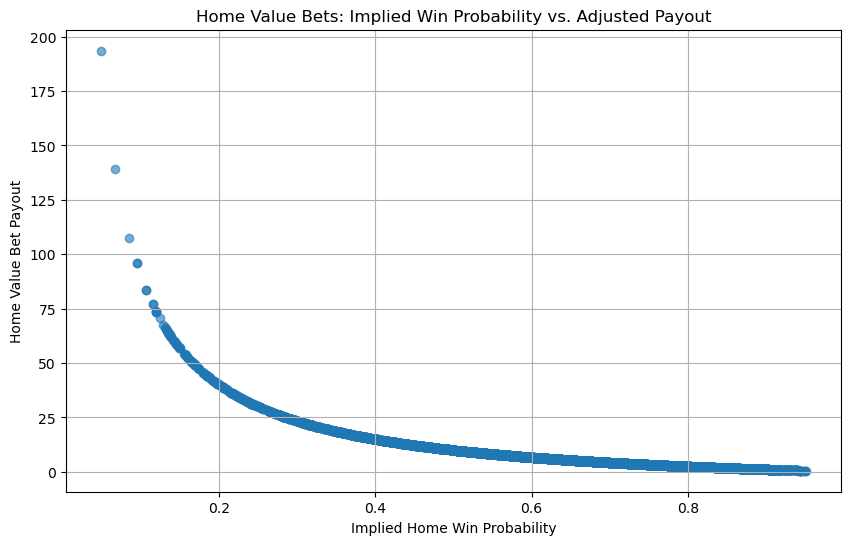

Summary of Home Value Bets by Probability Category:
  probability_category  average_payout  num_bets  percent_bets
0           Low (<33%)       33.440329       486      7.263488
1      Medium (33-67%)        9.425045      3468     51.830818
2          High (>67%)        2.977957      2737     40.905694


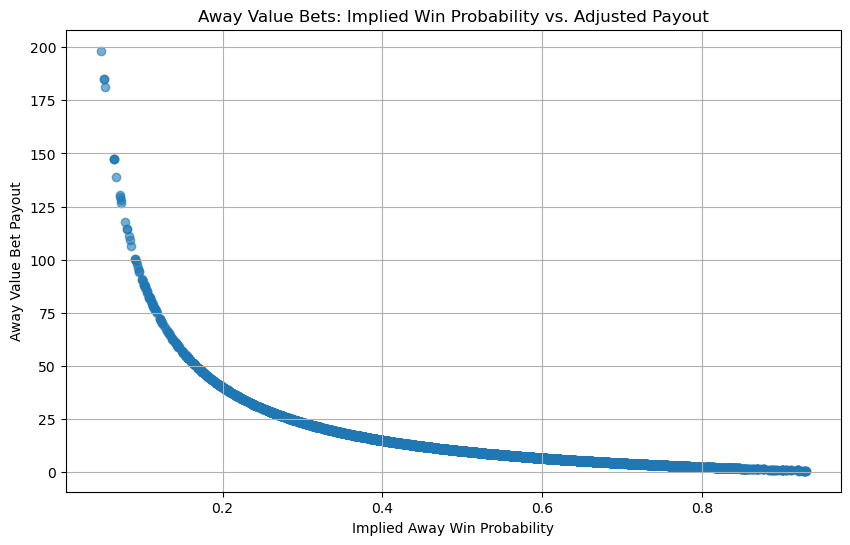

Summary of away Value Bets by Probability Category:
  probability_category  average_payout  num_bets  percent_bets
0           Low (<33%)       36.884828       903     18.421053
1      Medium (33-67%)       10.659391      2940     59.975520
2          High (>67%)        3.257189      1059     21.603427
Percentage of upsets in home value bets: 26.13%
Percentage of upsets in correct home value bets: 23.17%
Percentage of upsets in away value bets: 41.69%
Percentage of upsets in correct away value bets: 45.63%
Home Odds-Elo Mismatch Counts:
home_odds_elo_mismatch
 0.508393    11903
-1.966983     3061
Name: count, dtype: int64

Away Odds-Elo Mismatch Counts:
away_odds_elo_mismatch
 0.508770    11894
-1.965524     3070
Name: count, dtype: int64
Proportion of Upsets for Home Odds-Elo Mismatch:
home_odds_elo_mismatch
-1.966983    0.570402
 0.508393    0.258422
Name: upset, dtype: float64

Proportion of Upsets for Away Odds-Elo Mismatch:
away_odds_elo_mismatch
-1.965524    0.568730
 0.508770   

In [45]:
# Create a df that filters for correct home value bets
home_value_bets_df = test_df[test_df['correct_home_value_bet'] == 1].copy()

# Categorize by Implied Win Probability with low, medium, and high probability ranges
bins = [0, 0.33, 0.67, 1]
labels = ['Low (<33%)', 'Medium (33-67%)', 'High (>67%)']
home_value_bets_df.loc[:, 'probability_category'] = pd.cut(home_value_bets_df['implied_home_prob'], bins=bins, labels=labels, include_lowest=True)

# Calculate the Average Payout per Probability Category
average_payout_by_category = home_value_bets_df.groupby('probability_category', observed=False)['home_vb_payout'].mean()

# Plot the Probability vs. Payout Distribution
plt.figure(figsize=(10, 6))
plt.scatter(home_value_bets_df['implied_home_prob'], home_value_bets_df['home_vb_payout'], alpha=0.6)
plt.title('Home Value Bets: Implied Win Probability vs. Adjusted Payout')
plt.xlabel('Implied Home Win Probability')
plt.ylabel('Home Value Bet Payout')
plt.grid(True)
plt.show()

# Calculate the Average Payout, Number of Bets, and % of Bets per Probability Category
summary_by_category = home_value_bets_df.groupby('probability_category', observed=False).agg(average_payout=('home_vb_payout', 'mean'), num_bets=('home_vb_payout', 'size')).reset_index()

# Calculate the percentage of bets for each category
total_bets = summary_by_category['num_bets'].sum()
summary_by_category['percent_bets'] = (summary_by_category['num_bets'] / total_bets) * 100

# Display the summary for each category
print("Summary of Home Value Bets by Probability Category:")
print(summary_by_category)

###
# Create a df that filters for correct away value bets
away_value_bets_df = test_df[test_df['correct_away_value_bet'] == 1].copy()
away_value_bets_df.loc[:, 'probability_category'] = pd.cut(away_value_bets_df['implied_away_prob'], bins=bins, labels=labels, include_lowest=True)

average_payout_by_category = away_value_bets_df.groupby('probability_category', observed=False)['away_vb_payout'].mean()

plt.figure(figsize=(10, 6))
plt.scatter(away_value_bets_df['implied_away_prob'], away_value_bets_df['away_vb_payout'], alpha=0.6)
plt.title('Away Value Bets: Implied Win Probability vs. Adjusted Payout')
plt.xlabel('Implied Away Win Probability')
plt.ylabel('Away Value Bet Payout')
plt.grid(True)
plt.show()

summary_by_category = away_value_bets_df.groupby('probability_category', observed=False).agg(average_payout=('away_vb_payout', 'mean'), num_bets=('away_vb_payout', 'size')).reset_index()

total_bets = summary_by_category['num_bets'].sum()
summary_by_category['percent_bets'] = (summary_by_category['num_bets'] / total_bets) * 100

print("Summary of away Value Bets by Probability Category:")
print(summary_by_category)

###
# Examiming Upset by correct home and away value bets
# Among all identified home value bets
percent_upsets_in_home_vb = test_df[test_df['home_vb'] == 1]['upset'].mean() * 100

# Among correct home value bets
home_value_bets_df = test_df[test_df['correct_home_value_bet'] == 1].copy()
percent_upsets_in_correct_home_vb = home_value_bets_df['upset'].mean() * 100

# Among all identified away value bets
percent_upsets_in_away_vb = test_df[test_df['away_vb'] == 1]['upset'].mean() * 100

# Among correct away value bets
away_value_bets_df = test_df[test_df['correct_away_value_bet'] == 1].copy()
percent_upsets_in_correct_away_vb = away_value_bets_df['upset'].mean() * 100

print(f"Percentage of upsets in home value bets: {percent_upsets_in_home_vb:.2f}%")
print(f"Percentage of upsets in correct home value bets: {percent_upsets_in_correct_home_vb:.2f}%")
print(f"Percentage of upsets in away value bets: {percent_upsets_in_away_vb:.2f}%")
print(f"Percentage of upsets in correct away value bets: {percent_upsets_in_correct_away_vb:.2f}%")

# Calculate the counts for home and away odds-elo mismatches
# This should tell me if I can use a underdog upset based on elo
home_odds_elo_mismatch_counts = test_df['home_odds_elo_mismatch'].value_counts()
away_odds_elo_mismatch_counts = test_df['away_odds_elo_mismatch'].value_counts()
print("Home Odds-Elo Mismatch Counts:")
print(home_odds_elo_mismatch_counts)
print("\nAway Odds-Elo Mismatch Counts:")
print(away_odds_elo_mismatch_counts)

# Proportion of upsets for games with and without home odds-elo mismatch
home_upset_proportions = test_df.groupby('home_odds_elo_mismatch')['upset'].mean()
# Proportion of upsets for games with and without away odds-elo mismatch
away_upset_proportions = test_df.groupby('away_odds_elo_mismatch')['upset'].mean()
# Print the results
print("Proportion of Upsets for Home Odds-Elo Mismatch:")
print(home_upset_proportions)
print("\nProportion of Upsets for Away Odds-Elo Mismatch:")
print(away_upset_proportions)

# Count how many games are in each Elo discrepancy category
elo_discrepancy_counts = test_df['elo_discrepancy'].value_counts()

# Count how many upsets are in each Elo discrepancy category
elo_discrepancy_upset_counts = test_df.groupby('elo_discrepancy')['upset'].sum()
elo_discrepancy_homevb_counts = test_df.groupby('elo_discrepancy')['home_vb'].sum()
elo_discrepancy_awayvb_counts = test_df.groupby('elo_discrepancy')['away_vb'].sum()

# Print results
print("Elo Discrepancy Counts:\n", elo_discrepancy_counts)
print("\nUpsets in Each Elo Discrepancy:\n", elo_discrepancy_upset_counts)
print("\nHome Value Bets in Each Elo Discrepancy:\n", elo_discrepancy_homevb_counts)
print("\nAway Value Bets in Each Elo Discrepancy:\n", elo_discrepancy_awayvb_counts)

# Proportion of value bets for home mismatch
print("Proportion of Home Value Bets by Odds-Elo Mismatch:")
print(test_df.groupby('home_odds_elo_mismatch')['home_vb'].mean())
print("\nProportion of Correct Home Value Bets by Odds-Elo Mismatch:")
print(test_df.groupby('home_odds_elo_mismatch')['correct_home_value_bet'].mean())

# Proportion of value bets for away mismatch
print("\nProportion of Away Value Bets by Odds-Elo Mismatch:")
print(test_df.groupby('away_odds_elo_mismatch')['away_vb'].mean())
print("\nProportion of Correct Away Value Bets by Odds-Elo Mismatch:")
print(test_df.groupby('away_odds_elo_mismatch')['correct_away_value_bet'].mean())

# Proportion of value bets for elo discrepancy
print("Proportion of Value Bets by Elo Discrepancy:")
print(test_df.groupby('elo_discrepancy')[['home_vb', 'away_vb']].mean())
print("\nProportion of Correct Value Bets by Elo Discrepancy:")
print(test_df.groupby('elo_discrepancy')[['correct_home_value_bet', 'correct_away_value_bet']].mean())

## Basketball Data Only

In [ ]:
# Define basketball-specific train and validation sets
# Encode Teams to Unique IDs across all splits for consistent encoding
all_teams = pd.concat([train_df['home_team'], train_df['away_team'], 
                       val_df['home_team'], val_df['away_team'], 
                       test_df['home_team'], test_df['away_team']]).unique()
team_id_map = {team: idx for idx, team in enumerate(all_teams)}

# Apply the consistent mapping to each split
train_df['home_team_id'] = train_df['home_team'].map(team_id_map)
train_df['away_team_id'] = train_df['away_team'].map(team_id_map)
val_df['home_team_id'] = val_df['home_team'].map(team_id_map)
val_df['away_team_id'] = val_df['away_team'].map(team_id_map)
test_df['home_team_id'] = test_df['home_team'].map(team_id_map)
test_df['away_team_id'] = test_df['away_team'].map(team_id_map)

# Make a copy of the dfs to use for this model
train_bball_df = train_df[train_df['sport'] == 'basketball'].copy()
val_bball_df = val_df[val_df['sport'] == 'basketball'].copy()
test_bball_df = test_df[test_df['sport'] == 'basketball'].copy()

# Define Game-Specific Features
bball_features = [
    'avg_odds_ratio', 'high_odds_ratio', 'game_dev_home_odds', 'game_dev_away_odds',
    'hteam_w_streak', 'ateam_w_streak', 'hteam_l_streak', 'ateam_l_streak',
    'roll_home_scorediff', 'roll_away_scorediff', 'home_team_elo', 'away_team_elo',
    'sim_home_team_elo', 'sim_away_team_elo', 'home_team_encoded', 'away_team_encoded', 'upset']

# Drop rows with NaN values in the training, validation, and test sets
train_bball_df = train_bball_df.dropna(subset=bball_features + ['home_team_id', 'away_team_id'])
val_bball_df = val_bball_df.dropna(subset=bball_features + ['home_team_id', 'away_team_id'])
test_bball_df = test_bball_df.dropna(subset=bball_features + ['home_team_id', 'away_team_id'])

# Scale game features using only the training set to fit the scaler
scaler_bball = StandardScaler()
train_bball_df[bball_features] = scaler_bball.fit_transform(train_bball_df[bball_features])
val_bball_df[bball_features] = scaler_bball.transform(val_bball_df[bball_features])
test_bball_df[bball_features] = scaler_bball.transform(test_bball_df[bball_features])

# Convert DataFrames to PyTorch tensors with alpha-weighted target probabilities
def df_to_tensor(df):
    home_team_tensor = torch.tensor(df['home_team_id'].values, dtype=torch.long)
    away_team_tensor = torch.tensor(df['away_team_id'].values, dtype=torch.long)
    features_tensor = torch.tensor(df[bball_features].values, dtype=torch.float32)

    home_target_tensor = torch.tensor(df['implied_home_prob'].values, dtype=torch.float32)
    away_target_tensor = torch.tensor(df['implied_away_prob'].values, dtype=torch.float32)
    home_ev_tensor = torch.tensor(df['ev_home'].values, dtype=torch.float32)
    away_ev_tensor = torch.tensor(df['ev_away'].values, dtype=torch.float32)

    # Add binary game outcomes as tensors
    home_outcome_tensor = torch.tensor(df['hteam_win'].values, dtype=torch.float32)
    away_outcome_tensor = torch.tensor(1 - df['hteam_win'].values, dtype=torch.float32)

    # Add sport as tensor
    sport_encoded = pd.Categorical(df['sport']).codes
    sport_tensor = torch.tensor(sport_encoded, dtype=torch.long)
    
    return home_team_tensor, away_team_tensor, features_tensor, home_target_tensor, away_target_tensor, home_ev_tensor, away_ev_tensor, home_outcome_tensor, away_outcome_tensor, sport_tensor

# Create PyTorch tensors for training, validation, and test sets
home_team_train, away_team_train, bball_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, sport_train = df_to_tensor(train_bball_df)
home_team_val, away_team_val, bball_features_val, home_target_val, away_target_val, home_ev_val, away_ev_val, home_outcome_val, away_outcome_val, sport_val = df_to_tensor(val_bball_df)
home_team_test, away_team_test, bball_features_test, home_target_test, away_target_test, home_ev_test, away_ev_test, home_outcome_test, away_outcome_test, sport_test = df_to_tensor(test_bball_df)

### NN Binary

In [ ]:
# Define a Single-Sport NN for basketball
class BballNN(nn.Module):
    def __init__(self, input_size, dropout_rate=0.2):
        super(BballNN, self).__init__()
        
        # Base layers
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layers for home and away probabilities
        self.final_output = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        combined_output = torch.softmax(self.final_output(x), dim=1)
        home_win_prob = combined_output[:, 0]
        away_win_prob = combined_output[:, 1]
        
        return home_win_prob, away_win_prob

In [ ]:
# Function to iterate over data in batches
def get_batches(*tensors, batch_size=64):
    length = len(tensors[0])
    for i in range(0, length, batch_size):
        yield (t[i:i+batch_size] for t in tensors)

# Define your objective function for Optuna with K-Fold cross-validation
def objective(trial):
    # Set up hyperparameters for Optuna to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    embedding_dim = trial.suggest_int("embedding_dim", 8, 32)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    # Initialize the KFold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses = []
    
    # Add an index to track the fold number
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(train_bball_df)):
        # Prepare train and validation datasets for the current fold
        train_bball_fold_df = train_bball_df.iloc[train_idx].copy()
        val_bball_fold_df = train_bball_df.iloc[val_idx].copy()

        _, _, bball_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, _ = df_to_tensor(train_bball_fold_df)
        _, _, bball_features_val, home_target_val, away_target_val, home_ev_val, away_ev_val, home_outcome_val, away_outcome_val, _ = df_to_tensor(val_bball_fold_df)
        
        # Initialize the model, loss function, and optimizer with trial hyperparameters
        modelBballNN = BballNN(input_size=bball_features_train.shape[1], dropout_rate=dropout_rate).to(device)
    
        criterion = nn.BCELoss()
        optimizer = optim.Adam(modelBballNN.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Training loop for each fold
        num_epochs = 20
        batch_size = 64
        for epoch in range(num_epochs):
            modelBballNN.train()
            total_loss = 0
            
            # Iterate through batches
            for batch_features, batch_home_target, batch_away_target, batch_home_outcome, batch_away_outcome in get_batches(
                bball_features_train, home_target_train, away_target_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
                
                optimizer.zero_grad()
                home_output, away_output = modelBballNN(batch_features)
                
               # Calculate separate losses for home and away
                home_loss = criterion(home_output.squeeze(), batch_home_outcome)
                away_loss = criterion(away_output.squeeze(), batch_away_outcome)
    
                # Combine the losses
                loss = home_loss + away_loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
    
        # Validation loop
        modelBballNN.eval()
        val_loss = 0
        with torch.no_grad():
            home_output, away_output = modelBballNN(bball_features_val)
            home_loss_val = criterion(home_output.squeeze(), home_outcome_val)
            away_loss_val = criterion(away_output.squeeze(), away_outcome_val)
            val_loss = home_loss_val + away_loss_val
    
        # Append average validation loss for this fold
        fold_losses.append(val_loss.item() / len(val_idx))
        
        # Report the fold’s average loss after all epochs are complete
        trial.report(val_loss.item() / len(val_idx), fold_num)  
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # Return the average loss across all folds
    return sum(fold_losses) / len(fold_losses)

# Set up and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Get the best trial and hyperparameters
best_trial = study.best_trial
print("Best hyperparameters found: ", best_trial.params)

In [ ]:
# Ensemble Predictions on Validation Set for NN Model 
predicted_probs_val = {'home_win_prob': [], 'away_win_prob': []}

# Set up ensemble with best hyperparameters
ensemble_size = 5
ensemble_modelsBballNN = []

# Define hyperparameters from the best trial
dropout_rate = best_trial.params["dropout_rate"]
embedding_dim = best_trial.params["embedding_dim"]
learning_rate = best_trial.params["learning_rate"]
weight_decay = best_trial.params["weight_decay"]

# Train each model in the ensemble with the best hyperparameters
for _ in range(ensemble_size):
    modelBballNN = BballNN(input_size=bball_features_train.shape[1], dropout_rate=dropout_rate).to(device)
    criterion = nn.BCELoss()  
    optimizer = optim.Adam(modelBballNN.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop for each model in the ensemble
    num_epochs = 20
    batch_size = 64
    for epoch in range(num_epochs):
        modelBballNN.train()
        total_loss = 0

        # Iterate through batches for training 
        for batch_features, batch_home_target, batch_away_target, batch_home_outcome, batch_away_outcome in get_batches(
            bball_features_train, home_target_train, away_target_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
            
            optimizer.zero_grad()
            home_output, away_output = modelBballNN(batch_features)
            
            # Calculate losses for home and away 
            home_loss = criterion(home_output.squeeze(), batch_home_outcome)
            away_loss = criterion(away_output.squeeze(), batch_away_outcome)
            loss = home_loss + away_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}")

    # Save each trained model to the ensemble
    ensemble_modelsBballNN.append(modelBballNN)

# Validation Predictions with Ensemble
with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_v = np.zeros(len(home_outcome_val))
    ensemble_away_probs_v = np.zeros(len(away_outcome_val))
    
    for modelBballNN in ensemble_modelsBballNN:
        modelBballNN.eval()

        # Forward pass on validation data for prediction
        home_output_v, away_output_v = modelBballNN(bball_features_val)
        
        # Add predictions to ensemble arrays
        ensemble_home_probs_v += home_output_v.squeeze().cpu().numpy()
        ensemble_away_probs_v += away_output_v.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_v /= ensemble_size
    ensemble_away_probs_v /= ensemble_size

# Update the dictionary
predicted_probs_val['home_win_prob'] = ensemble_home_probs_v
predicted_probs_val['away_win_prob'] = ensemble_away_probs_v

print(predicted_probs_val['home_win_prob'][:10])
print(predicted_probs_val['away_win_prob'][:10])

# Create a directory to store your ensemble models, if it doesn't already exist
ensemble_dir = "ensemble_modelsBballNN"
os.makedirs(ensemble_dir, exist_ok=True)

# Save each model in the ensemble with a unique filename
for i, model in enumerate(ensemble_modelsBballNN):
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model {i} saved to {model_path}")

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsBballNN = []
predicted_probs_test = {'home_win_prob': [], 'away_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  
    model = BballNN(input_size=len(bball_features), dropout_rate=best_trial.params["dropout_rate"]).to(device)
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsBballNN.append(model)
    print(f"Model {i} loaded from {model_path}")

# Ensemble Predictions on Test Set for NN Model 
predicted_probs_test = {'home_win_prob': [], 'away_win_prob': []}

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_test = np.zeros(len(home_outcome_test))
    ensemble_away_probs_test = np.zeros(len(away_outcome_test))
    
    for modelBballNN in ensemble_modelsBballNN:
        modelBballNN.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_t, away_output_t = modelBballNN(bball_features_test)
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_test += home_output_t.squeeze().cpu().numpy()
        ensemble_away_probs_test += away_output_t.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_test /= ensemble_size
    ensemble_away_probs_test /= ensemble_size

# Update the dictionary
predicted_probs_test['home_win_prob'] = ensemble_home_probs_test
predicted_probs_test['away_win_prob'] = ensemble_away_probs_test

print(predicted_probs_test['home_win_prob'][:10])
print(predicted_probs_test['away_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_test_prob_home = np.array(predicted_probs_test.get('home_win_prob', None))
y_pred_test_prob_away = np.array(predicted_probs_test.get('away_win_prob', None))

test_bball_df['model_home_value'] = (y_pred_test_prob_home * test_bball_df['decimal_home_odds']) - 1
test_bball_df['model_away_value'] = (y_pred_test_prob_away * test_bball_df['decimal_away_odds']) - 1

test_bball_df['home_vb'] = (test_bball_df['model_home_value'] > 0.05).astype(int)
test_bball_df['away_vb'] = (test_bball_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on $10 wager
test_bball_df['ev_home'] = 10 * ((y_pred_test_prob_home * (test_bball_df['decimal_home_odds'] - 1)) - (1 - y_pred_test_prob_home))
test_bball_df['ev_away'] = 10 * ((y_pred_test_prob_away * (test_bball_df['decimal_away_odds'] - 1)) - (1 - y_pred_test_prob_away))

# Calculate value and non-value bets
test_bball_df['correct_home_value_bet'] = np.where((test_bball_df['home_vb'] == 1) & (test_bball_df['hteam_win'] == 1), 1, 0)
test_bball_df['correct_away_value_bet'] = np.where((test_bball_df['away_vb'] == 1) & (test_bball_df['hteam_win'] == 0), 1, 0)
test_bball_df['correct_home_non_value_bet'] = np.where((test_bball_df['home_vb'] == 0) & (test_bball_df['hteam_win'] == 1), 1, 0)
test_bball_df['correct_away_non_value_bet'] = np.where((test_bball_df['away_vb'] == 0) & (test_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_bball_df['home_vb_payout'] = np.where(test_bball_df['correct_home_value_bet'] == 1,
                                       (test_bball_df['decimal_home_odds'] * 10) - 10, -10)
test_bball_df['away_vb_payout'] = np.where(test_bball_df['correct_away_value_bet'] == 1,
                                       (test_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_bball_df['home_non_value_payout'] = np.where(test_bball_df['correct_home_non_value_bet'] == 1,
                                       (test_bball_df['decimal_home_odds'] * 10) - 10, -10)
test_bball_df['away_non_value_payout'] = np.where(test_bball_df['correct_away_non_value_bet'] == 1,
                                       (test_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
test_bball_df['home_actual_payout'] = np.where(test_bball_df['hteam_win'] == 1, np.where(test_bball_df['avg_home_odds'] > 0, 
        (test_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(test_bball_df['avg_home_odds'])) * 10), -10)

test_bball_df['away_actual_payout'] = np.where(test_bball_df['hteam_win'] == 0, np.where(test_bball_df['avg_away_odds'] > 0, 
        (test_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(test_bball_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_bball_df['home_payout_diff'] = test_bball_df['home_vb_payout'] - test_bball_df['home_actual_payout']
test_bball_df['away_payout_diff'] = test_bball_df['away_vb_payout'] - test_bball_df['away_actual_payout']
test_bball_df['home_vb_payout_diff'] = test_bball_df['home_vb_payout'] - test_bball_df['home_non_value_payout']
test_bball_df['away_vb_payout_diff'] = test_bball_df['away_vb_payout'] - test_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_bball_df['home_vb_payout'][test_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = test_bball_df['away_vb_payout'][test_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = test_bball_df['home_non_value_payout'][test_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = test_bball_df['away_non_value_payout'][test_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_bball_df['home_actual_payout'].sum()
total_away_actual_payout = test_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = test_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_bball_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (test_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_bball_df) * 10
total_away_actual_bet_amount = len(test_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_bball_df.loc[test_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = test_bball_df.loc[test_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_bball_df.loc[test_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = test_bball_df.loc[test_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_test_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_test_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(test_bball_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - test_bball_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(test_bball_df['hteam_win'], y_pred_test_prob_home)
away_brier_score = brier_score_loss((1 - test_bball_df['hteam_win']), y_pred_test_prob_away)

# Calculate F1 Score
home_f1 = f1_score(test_bball_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - test_bball_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsBballNN = []
predicted_probs_holdout = {'home_win_prob': [], 'away_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size): 
    model = BballNN(input_size=len(bball_features), dropout_rate=best_trial.params["dropout_rate"]).to(device)
    
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  
    ensemble_modelsBballNN.append(model)
    print(f"Model {i} loaded from {model_path}")

# Apply the consistent mapping to holdout_df
holdout_bball_df['home_team_id'] = holdout_bball_df['home_team'].map(team_id_map)
holdout_bball_df['away_team_id'] = holdout_bball_df['away_team'].map(team_id_map)

# Drop rows with NaN values in the holdout set
holdout_bball_df = holdout_bball_df.dropna(subset=bball_features + ['home_team_id', 'away_team_id'])

# Scale game features using the previously fitted scaler
holdout_bball_df[bball_features] = scaler_bball.transform(holdout_bball_df[bball_features])

# Create PyTorch tensors for holdout set
home_team_holdout, away_team_holdout, bball_features_holdout, home_target_holdout, away_target_holdout, home_ev_holdout, away_ev_holdout, home_outcome_holdout, away_outcome_holdout, sport_holdout = df_to_tensor(holdout_bball_df)

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_holdout = np.zeros(len(home_team_holdout))
    ensemble_away_probs_holdout = np.zeros(len(away_team_holdout))
    
    for modelBballNN in ensemble_modelsBballNN:
        modelBballNN.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_holdout, away_output_holdout = modelBballNN(bball_features_holdout)
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_holdout += home_output_holdout.squeeze().cpu().numpy()
        ensemble_away_probs_holdout += away_output_holdout.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_holdout /= ensemble_size
    ensemble_away_probs_holdout /= ensemble_size

# Update the dictionary
predicted_probs_holdout['home_win_prob'] = ensemble_home_probs_holdout
predicted_probs_holdout['away_win_prob'] = ensemble_away_probs_holdout

print(predicted_probs_holdout['home_win_prob'][:10])
print(predicted_probs_holdout['away_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the holdout data
y_pred_holdout_prob_home = np.array(predicted_probs_holdout.get('home_win_prob', None))
y_pred_holdout_prob_away = np.array(predicted_probs_holdout.get('away_win_prob', None))

holdout_bball_df['model_home_value'] = (y_pred_holdout_prob_home * holdout_bball_df['decimal_home_odds']) - 1
holdout_bball_df['model_away_value'] = (y_pred_holdout_prob_away * holdout_bball_df['decimal_away_odds']) - 1

holdout_bball_df['home_vb'] = (holdout_bball_df['model_home_value'] > 0.05).astype(int)
holdout_bball_df['away_vb'] = (holdout_bball_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on $10 wager
holdout_bball_df['ev_home'] = 10 * ((y_pred_holdout_prob_home * (holdout_bball_df['decimal_home_odds'] - 1)) - (1 - y_pred_holdout_prob_home))
holdout_bball_df['ev_away'] = 10 * ((y_pred_holdout_prob_away * (holdout_bball_df['decimal_away_odds'] - 1)) - (1 - y_pred_holdout_prob_away))

# Calculate value and non-value bets
holdout_bball_df['correct_home_value_bet'] = np.where((holdout_bball_df['home_vb'] == 1) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_value_bet'] = np.where((holdout_bball_df['away_vb'] == 1) & (holdout_bball_df['hteam_win'] == 0), 1, 0)
holdout_bball_df['correct_home_non_value_bet'] = np.where((holdout_bball_df['home_vb'] == 0) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_non_value_bet'] = np.where((holdout_bball_df['away_vb'] == 0) & (holdout_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
holdout_bball_df['home_vb_payout'] = np.where(holdout_bball_df['correct_home_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_vb_payout'] = np.where(holdout_bball_df['correct_away_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df['home_non_value_payout'] = np.where(holdout_bball_df['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_non_value_payout'] = np.where(holdout_bball_df['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
holdout_bball_df['home_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 1, np.where(holdout_bball_df['avg_home_odds'] > 0, 
        (holdout_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_home_odds'])) * 10), -10)

holdout_bball_df['away_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 0, np.where(holdout_bball_df['avg_away_odds'] > 0, 
        (holdout_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df['home_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_actual_payout']
holdout_bball_df['away_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_actual_payout']
holdout_bball_df['home_vb_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_non_value_payout']
holdout_bball_df['away_vb_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df['home_vb_payout'][holdout_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df['away_vb_payout'][holdout_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df['home_non_value_payout'][holdout_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df['away_non_value_payout'][holdout_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df) * 10
total_away_actual_bet_amount = len(holdout_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_holdout_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_holdout_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(holdout_bball_df['hteam_win'], y_pred_holdout_prob_home)
away_brier_score = brier_score_loss((1 - holdout_bball_df['hteam_win']), y_pred_holdout_prob_away)

# Calculate F1 Score
home_f1 = f1_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

### NN Continuous

In [ ]:
# Define a Single-Sport NN for basketball
class BballNN(nn.Module):
    def __init__(self, input_size, dropout_rate=0.2):
        super(BballNN, self).__init__()
        
        # Base layers
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layers for home and away probabilities
        self.home_output = nn.Linear(32, 1)
        self.away_output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        # Output win probabilities for home and away teams with relu acitvation output with a small clip
        home_win_prob = torch.relu(self.home_output(x)) + 1e-6
        away_win_prob = torch.relu(self.away_output(x)) + 1e-6
        
        return home_win_prob, away_win_prob

In [ ]:
# Function to iterate over data in batches
def get_batches(*tensors, batch_size=64):
    length = len(tensors[0])
    for i in range(0, length, batch_size):
        yield (t[i:i+batch_size] for t in tensors)

# Define your objective function for Optuna with K-Fold cross-validation
def objective(trial):
    # Set up hyperparameters for Optuna to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    embedding_dim = trial.suggest_int("embedding_dim", 8, 32)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    # Initialize the KFold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses = []
    
    # Add an index to track the fold number
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(train_bball_df)):
        # Prepare train and validation datasets for the current fold
        train_bball_fold_df = train_bball_df.iloc[train_idx].copy()
        val_bball_fold_df = train_bball_df.iloc[val_idx].copy()

        _, _, bball_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, _ = df_to_tensor(train_bball_fold_df)
        _, _, bball_features_val, home_target_val, away_target_val, home_ev_val, away_ev_val, home_outcome_val, away_outcome_val, _ = df_to_tensor(val_bball_fold_df)
        
        # Initialize the model, loss function, and optimizer with trial hyperparameters
        modelBballNN = BballNN(input_size=bball_features_train.shape[1], dropout_rate=dropout_rate).to(device)
    
        criterion = RMSELoss()
        optimizer = optim.Adam(modelBballNN.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Training loop for each fold
        num_epochs = 20
        batch_size = 64
        for epoch in range(num_epochs):
            modelBballNN.train()
            total_loss = 0
            
            # Iterate through batches
            for batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome in get_batches(
                bball_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
                
                optimizer.zero_grad()
                home_output, away_output = modelBballNN(batch_features)

                # Normalization
                total_output = home_output + away_output
                home_output_norm = home_output / total_output
                away_output_norm = away_output / total_output
                
                # Calculate separate losses for home and away
                home_loss = criterion(home_output_norm.squeeze(), batch_home_target)
                away_loss = criterion(away_output_norm.squeeze(), batch_away_target)
    
                # Combine the losses
                loss = home_loss + away_loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
    
        # Validation loop
        modelBballNN.eval()
        val_loss = 0
        with torch.no_grad():
            home_output_v, away_output_v = modelBballNN(bball_features_val)
            total_output_v = home_output_v + away_output_v
            home_output_norm_v = home_output_v / total_output_v
            away_output_norm_v = away_output_v / total_output_v
            home_loss_val = criterion(home_output_norm_v.squeeze(), home_target_val)
            away_loss_val = criterion(away_output_norm_v.squeeze(), away_target_val)
            val_loss = home_loss_val + away_loss_val
    
        # Append average validation loss for this fold
        fold_losses.append(val_loss.item() / len(val_idx))
        
        # Report the fold’s average loss after all epochs are complete
        trial.report(val_loss.item() / len(val_idx), fold_num) 
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # Return the average loss across all folds
    return sum(fold_losses) / len(fold_losses)

# Set up and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Get the best trial and hyperparameters
best_trial = study.best_trial
print("Best hyperparameters found: ", best_trial.params)

In [ ]:
# Ensemble Predictions on Validation Set for NN Model with Continuous Win Probabilities
predicted_probs_val = {'home_win_prob': [], 'away_win_prob': []}

# Set up ensemble with best hyperparameters
ensemble_size = 5
ensemble_modelsBballNN = []

# Define hyperparameters from the best trial
dropout_rate = best_trial.params["dropout_rate"]
embedding_dim = best_trial.params["embedding_dim"]
learning_rate = best_trial.params["learning_rate"]
weight_decay = best_trial.params["weight_decay"]

# Train each model in the ensemble with the best hyperparameters
for _ in range(ensemble_size):
    modelBballNN = BballNN(input_size=bball_features_train.shape[1], dropout_rate=dropout_rate).to(device)   
    criterion = RMSELoss()  
    optimizer = optim.Adam(modelBballNN.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop for each model in the ensemble
    num_epochs = 20
    batch_size = 64
    for epoch in range(num_epochs):
        modelBballNN.train()
        total_loss = 0

        # Iterate through batches for training 
        for batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome in get_batches(
            bball_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
            
            optimizer.zero_grad()
            home_output, away_output = modelBballNN(batch_features)

            # Normalization
            total_output = home_output + away_output
            home_output_norm = home_output / total_output
            away_output_norm = away_output / total_output
            
            # Calculate losses for home and away 
            home_loss = criterion(home_output_norm.squeeze(), batch_home_target)
            away_loss = criterion(away_output_norm.squeeze(), batch_away_target)
            loss = home_loss + away_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}")

    # Save each trained model to the ensemble
    ensemble_modelsBballNN.append(modelBballNN)

# Validation Predictions with Ensemble
with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_v = np.zeros(len(home_target_val))
    ensemble_away_probs_v = np.zeros(len(away_target_val))
    
    for modelBballNN in ensemble_modelsBballNN:
        modelBballNN.eval()

        # Forward pass on validation data for prediction
        home_output_v, away_output_v = modelBballNN(bball_features_val)
        
        total_output_v = home_output_v + away_output_v
        home_output_norm_v = home_output_v / total_output_v
        away_output_norm_v = away_output_v / total_output_v
        
        # Add predictions to ensemble arrays
        ensemble_home_probs_v += home_output_norm_v.squeeze().cpu().numpy()
        ensemble_away_probs_v += away_output_norm_v.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_v /= ensemble_size
    ensemble_away_probs_v /= ensemble_size

# Update the dictionary
predicted_probs_val['home_win_prob'] = ensemble_home_probs_v
predicted_probs_val['away_win_prob'] = ensemble_away_probs_v

print(predicted_probs_val['home_win_prob'][:10])
print(predicted_probs_val['away_win_prob'][:10])

# Create a directory to store your ensemble models, if it doesn't already exist
ensemble_dir = "ensemble_modelsBballNN"
os.makedirs(ensemble_dir, exist_ok=True)

# Save each model in the ensemble with a unique filename
for i, model in enumerate(ensemble_modelsBballNN):
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model {i} saved to {model_path}")

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsBballNN = []
predicted_probs_test = {'home_win_prob': [], 'away_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  
    model = BballNN(input_size=bball_features_train.shape[1], dropout_rate=dropout_rate).to(device)
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsBballNN.append(model)
    print(f"Model {i} loaded from {model_path}")

# Ensemble Predictions on Test Set for NN Model 
predicted_probs_test = {'home_win_prob': [], 'away_win_prob': []}

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_test = np.zeros(len(home_target_test))
    ensemble_away_probs_test = np.zeros(len(away_target_test))
    
    for modelBballNN in ensemble_modelsBballNN:
        modelBballNN.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_t, away_output_t = modelBballNN(bball_features_test)

        total_output_t = home_output_t + away_output_t
        home_output_norm_t = home_output_t / total_output_t
        away_output_norm_t = away_output_t / total_output_t
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_test += home_output_norm_t.squeeze().cpu().numpy()
        ensemble_away_probs_test += away_output_norm_t.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_test /= ensemble_size
    ensemble_away_probs_test /= ensemble_size

# Update the dictionary
predicted_probs_test['home_win_prob'] = ensemble_home_probs_test
predicted_probs_test['away_win_prob'] = ensemble_away_probs_test

print(predicted_probs_test['home_win_prob'][:10])
print(predicted_probs_test['away_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
y_pred_test_prob_home = np.array(predicted_probs_test.get('home_win_prob', None))
y_pred_test_prob_away = np.array(predicted_probs_test.get('away_win_prob', None))

test_bball_df['model_home_value'] = (y_pred_test_prob_home * test_bball_df['decimal_home_odds']) - 1
test_bball_df['model_away_value'] = (y_pred_test_prob_away * test_bball_df['decimal_away_odds']) - 1

test_bball_df['home_vb'] = (test_bball_df['model_home_value'] > 0.05).astype(int)
test_bball_df['away_vb'] = (test_bball_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on a $10 wager
test_bball_df['ev_home'] = 10 * ((y_pred_test_prob_home * (test_bball_df['decimal_home_odds'] - 1)) - (1 - y_pred_test_prob_home))
test_bball_df['ev_away'] = 10 * ((y_pred_test_prob_away * (test_bball_df['decimal_away_odds'] - 1)) - (1 - y_pred_test_prob_away))

# Calculate value and non-value bets
test_bball_df['correct_home_value_bet'] = np.where((test_bball_df['home_vb'] == 1) & (test_bball_df['hteam_win'] == 1), 1, 0)
test_bball_df['correct_away_value_bet'] = np.where((test_bball_df['away_vb'] == 1) & (test_bball_df['hteam_win'] == 0), 1, 0)
test_bball_df['correct_home_non_value_bet'] = np.where((test_bball_df['home_vb'] == 0) & (test_bball_df['hteam_win'] == 1), 1, 0)
test_bball_df['correct_away_non_value_bet'] = np.where((test_bball_df['away_vb'] == 0) & (test_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_bball_df['home_vb_payout'] = np.where(test_bball_df['correct_home_value_bet'] == 1,
                                       (test_bball_df['decimal_home_odds'] * 10) - 10, -10)
test_bball_df['away_vb_payout'] = np.where(test_bball_df['correct_away_value_bet'] == 1,
                                       (test_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_bball_df['home_non_value_payout'] = np.where(test_bball_df['correct_home_non_value_bet'] == 1,
                                       (test_bball_df['decimal_home_odds'] * 10) - 10, -10)
test_bball_df['away_non_value_payout'] = np.where(test_bball_df['correct_away_non_value_bet'] == 1,
                                       (test_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on a $10 wager
test_bball_df['home_actual_payout'] = np.where(test_bball_df['hteam_win'] == 1, np.where(test_bball_df['avg_home_odds'] > 0, 
        (test_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(test_bball_df['avg_home_odds'])) * 10), -10)

test_bball_df['away_actual_payout'] = np.where(test_bball_df['hteam_win'] == 0, np.where(test_bball_df['avg_away_odds'] > 0, 
        (test_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(test_bball_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_bball_df['home_payout_diff'] = test_bball_df['home_vb_payout'] - test_bball_df['home_actual_payout']
test_bball_df['away_payout_diff'] = test_bball_df['away_vb_payout'] - test_bball_df['away_actual_payout']
test_bball_df['home_vb_payout_diff'] = test_bball_df['home_vb_payout'] - test_bball_df['home_non_value_payout']
test_bball_df['away_vb_payout_diff'] = test_bball_df['away_vb_payout'] - test_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_bball_df['home_vb_payout'][test_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = test_bball_df['away_vb_payout'][test_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = test_bball_df['home_non_value_payout'][test_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = test_bball_df['away_non_value_payout'][test_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_bball_df['home_actual_payout'].sum()
total_away_actual_payout = test_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = test_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_bball_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (test_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_bball_df) * 10
total_away_actual_bet_amount = len(test_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_bball_df.loc[test_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = test_bball_df.loc[test_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_bball_df.loc[test_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = test_bball_df.loc[test_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_test_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_test_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(test_bball_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - test_bball_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(test_bball_df['hteam_win'], y_pred_test_prob_home)
away_brier_score = brier_score_loss((1 - test_bball_df['hteam_win']), y_pred_test_prob_away)

# Calculate F1 Score
home_f1 = f1_score(test_bball_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - test_bball_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsBballNN = []
predicted_probs_holdout = {'home_win_prob': [], 'away_win_prob': []}

# Load each saved model into the ensemble
for i in range(ensemble_size): 
    model = BballNN(input_size=bball_features_train.shape[1], dropout_rate=dropout_rate).to(device)
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsBballNN.append(model)
    print(f"Model {i} loaded from {model_path}")

# Apply the consistent mapping to holdout_df
holdout_bball_df['home_team_id'] = holdout_bball_df['home_team'].map(team_id_map)
holdout_bball_df['away_team_id'] = holdout_bball_df['away_team'].map(team_id_map)

# Drop rows with NaN values in the holdout set
holdout_bball_df = holdout_bball_df.dropna(subset=bball_features + ['home_team_id', 'away_team_id'])

# Scale game features using the previously fitted scaler
holdout_bball_df[bball_features] = scaler_bball.transform(holdout_bball_df[bball_features])

# Create PyTorch tensors for holdout set
home_team_holdout, away_team_holdout, bball_features_holdout, home_target_holdout, away_target_holdout, home_ev_holdout, away_ev_holdout, home_outcome_holdout, away_outcome_holdout, sport_holdout = df_to_tensor(holdout_bball_df)

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_holdout = np.zeros(len(home_target_holdout))
    ensemble_away_probs_holdout = np.zeros(len(away_target_holdout))
    
    for modelBballNN in ensemble_modelsBballNN:
        modelBballNN.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_holdout, away_output_holdout = modelBballNN(bball_features_holdout)

        total_output_holdout = home_output_holdout + away_output_holdout
        home_output_norm_h = home_output_holdout / total_output_holdout
        away_output_norm_h = away_output_holdout / total_output_holdout
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_holdout += home_output_norm_h.squeeze().cpu().numpy()
        ensemble_away_probs_holdout += away_output_norm_h.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_holdout /= ensemble_size
    ensemble_away_probs_holdout /= ensemble_size

# Update the dictionary
predicted_probs_holdout['home_win_prob'] = ensemble_home_probs_holdout
predicted_probs_holdout['away_win_prob'] = ensemble_away_probs_holdout

print(predicted_probs_holdout['home_win_prob'][:10])
print(predicted_probs_holdout['away_win_prob'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the holdout data
y_pred_holdout_prob_home = np.array(predicted_probs_holdout.get('home_win_prob', None))
y_pred_holdout_prob_away = np.array(predicted_probs_holdout.get('away_win_prob', None))

holdout_bball_df['model_home_value'] = (y_pred_holdout_prob_home * holdout_bball_df['decimal_home_odds']) - 1
holdout_bball_df['model_away_value'] = (y_pred_holdout_prob_away * holdout_bball_df['decimal_away_odds']) - 1

holdout_bball_df['home_vb'] = (holdout_bball_df['model_home_value'] > 0.05).astype(int)
holdout_bball_df['away_vb'] = (holdout_bball_df['model_away_value'] > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on a $10 wager
holdout_bball_df['ev_home'] = 10 * ((y_pred_holdout_prob_home * (holdout_bball_df['decimal_home_odds'] - 1)) - (1 - y_pred_holdout_prob_home))
holdout_bball_df['ev_away'] = 10 * ((y_pred_holdout_prob_away * (holdout_bball_df['decimal_away_odds'] - 1)) - (1 - y_pred_holdout_prob_away))

# Calculate value and non-value bets
holdout_bball_df['correct_home_value_bet'] = np.where((holdout_bball_df['home_vb'] == 1) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_value_bet'] = np.where((holdout_bball_df['away_vb'] == 1) & (holdout_bball_df['hteam_win'] == 0), 1, 0)
holdout_bball_df['correct_home_non_value_bet'] = np.where((holdout_bball_df['home_vb'] == 0) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_non_value_bet'] = np.where((holdout_bball_df['away_vb'] == 0) & (holdout_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
holdout_bball_df['home_vb_payout'] = np.where(holdout_bball_df['correct_home_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_vb_payout'] = np.where(holdout_bball_df['correct_away_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df['home_non_value_payout'] = np.where(holdout_bball_df['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_non_value_payout'] = np.where(holdout_bball_df['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on a $10 wager
holdout_bball_df['home_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 1, np.where(holdout_bball_df['avg_home_odds'] > 0, 
        (holdout_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_home_odds'])) * 10), -10)

holdout_bball_df['away_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 0, np.where(holdout_bball_df['avg_away_odds'] > 0, 
        (holdout_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df['home_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_actual_payout']
holdout_bball_df['away_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_actual_payout']
holdout_bball_df['home_vb_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_non_value_payout']
holdout_bball_df['away_vb_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df['home_vb_payout'][holdout_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df['away_vb_payout'][holdout_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df['home_non_value_payout'][holdout_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df['away_non_value_payout'][holdout_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df) * 10
total_away_actual_bet_amount = len(holdout_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_home_binary = (y_pred_holdout_prob_home > 0.5).astype(int)
y_pred_away_binary = (y_pred_holdout_prob_away > 0.5).astype(int)

# Calculate Accuracy based on 0.5 threshold for binary win/loss
h_accuracy = accuracy_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
a_accuracy = accuracy_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Calculate Brier Score for continuous probability predictions
home_brier_score = brier_score_loss(holdout_bball_df['hteam_win'], y_pred_holdout_prob_home)
away_brier_score = brier_score_loss((1 - holdout_bball_df['hteam_win']), y_pred_holdout_prob_away)

# Calculate F1 Score
home_f1 = f1_score(holdout_bball_df['hteam_win'], y_pred_home_binary)
away_f1 = f1_score((1 - holdout_bball_df['hteam_win']), y_pred_away_binary)

# Print results
print(f"Home Accuracy (Threshold 0.5): {h_accuracy:.4f}")
print(f"Away Accuracy (Threshold 0.5): {a_accuracy:.4f}")
print(f"Home Brier Score: {home_brier_score:.4f}")
print(f"Away Brier Score: {away_brier_score:.4f}")
print(f"Home F1 Score: {home_f1:.4f}")
print(f"Away F1 Score: {away_f1:.4f}")

### NN EV

In [ ]:
# Function to iterate over data in batches
def get_batches(*tensors, batch_size=64):
    length = len(tensors[0])
    for i in range(0, length, batch_size):
        yield (t[i:i+batch_size] for t in tensors)

# Define your objective function for Optuna with K-Fold cross-validation
def objective(trial):
    # Set up hyperparameters for Optuna to tune
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    embedding_dim = trial.suggest_int("embedding_dim", 8, 32)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    # Initialize the KFold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses = []
    
    # Add an index to track the fold number
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(train_bball_df)):
        # Prepare train and validation datasets for the current fold
        train_bball_fold_df = train_bball_df.iloc[train_idx].copy()
        val_bball_fold_df = train_bball_df.iloc[val_idx].copy()

        _, _, bball_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, _ = df_to_tensor(train_bball_fold_df)
        _, _, bball_features_val, home_target_val, away_target_val, home_ev_val, away_ev_val, home_outcome_val, away_outcome_val, _ = df_to_tensor(val_bball_fold_df)
        
        # Initialize the model, loss function, and optimizer with trial hyperparameters
        modelBballNN = BballNN(input_size=bball_features_train.shape[1], dropout_rate=dropout_rate).to(device)
    
        criterion = RMSELoss()
        optimizer = optim.Adam(modelBballNN.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Training loop for each fold
        num_epochs = 20
        batch_size = 64
        for epoch in range(num_epochs):
            modelBballNN.train()
            total_loss = 0
            
            # Iterate through batches
            for batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome in get_batches(
                bball_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
                
                optimizer.zero_grad()
                home_output, away_output = modelBballNN(batch_features)
                
                # Calculate separate losses for home and away
                home_loss = criterion(home_output.squeeze(), batch_home_ev)
                away_loss = criterion(away_output.squeeze(), batch_away_ev)
    
                # Combine the losses
                loss = home_loss + away_loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
    
        # Validation loop
        modelBballNN.eval()
        val_loss = 0
        with torch.no_grad():
            home_output_v, away_output_v = modelBballNN(bball_features_val)
            home_loss_val = criterion(home_output_v.squeeze(), home_ev_val)
            away_loss_val = criterion(away_output_v.squeeze(), away_ev_val)
            val_loss = home_loss_val + away_loss_val
    
        # Append average validation loss for this fold
        fold_losses.append(val_loss.item() / len(val_idx))
        
        # Report the fold’s average loss after all epochs are complete
        trial.report(val_loss.item() / len(val_idx), fold_num) 
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # Return the average loss across all folds
    return sum(fold_losses) / len(fold_losses)

# Set up and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Get the best trial and hyperparameters
best_trial = study.best_trial
print("Best hyperparameters found: ", best_trial.params)

In [ ]:
# Ensemble Predictions on Validation Set for NN Model with EV
# Create a dictionary to store predicted values
predicted_probs_val = {'ev_home': [], 'ev_away': []}

# Set up ensemble with best hyperparameters
ensemble_size = 5
ensemble_modelsBballNN = []

# Define hyperparameters from the best trial
dropout_rate = best_trial.params["dropout_rate"]
embedding_dim = best_trial.params["embedding_dim"]
learning_rate = best_trial.params["learning_rate"]
weight_decay = best_trial.params["weight_decay"]

# Train each model in the ensemble with the best hyperparameters
for _ in range(ensemble_size):
    modelBballNN = BballNN(input_size=bball_features_train.shape[1], dropout_rate=dropout_rate).to(device)   
    criterion = RMSELoss()  
    optimizer = optim.Adam(modelBballNN.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop for each model in the ensemble
    num_epochs = 20
    batch_size = 64
    for epoch in range(num_epochs):
        modelBballNN.train()
        total_loss = 0

        # Iterate through batches for training 
        for batch_features, batch_home_target, batch_away_target, batch_home_ev, batch_away_ev, batch_home_outcome, batch_away_outcome in get_batches(
            bball_features_train, home_target_train, away_target_train, home_ev_train, away_ev_train, home_outcome_train, away_outcome_train, batch_size=batch_size):
            
            optimizer.zero_grad()
            home_output, away_output = modelBballNN(batch_features)
            
            # Calculate losses for home and away 
            home_loss = criterion(home_output.squeeze(), batch_home_ev)
            away_loss = criterion(away_output.squeeze(), batch_away_ev)
            loss = home_loss + away_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}")

    # Save each trained model to the ensemble
    ensemble_modelsBballNN.append(modelBballNN)

# Validation Predictions with Ensemble
with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_v = np.zeros(len(home_ev_val))
    ensemble_away_probs_v = np.zeros(len(away_ev_val))
    
    for modelBballNN in ensemble_modelsBballNN:
        modelBballNN.eval()

        # Forward pass on validation data for prediction
        home_output_v, away_output_v = modelBballNN(bball_features_val)
        
        # Add predictions to ensemble arrays
        ensemble_home_probs_v += home_output_v.squeeze().cpu().numpy()
        ensemble_away_probs_v += away_output_v.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_v /= ensemble_size
    ensemble_away_probs_v /= ensemble_size

# Update the dictionary
predicted_probs_val['ev_home'] = ensemble_home_probs_v
predicted_probs_val['ev_away'] = ensemble_away_probs_v

print(predicted_probs_val['ev_home'][:10])
print(predicted_probs_val['ev_away'][:10])

# Create a directory to store your ensemble models, if it doesn't already exist
ensemble_dir = "ensemble_modelsBballNN"
os.makedirs(ensemble_dir, exist_ok=True)

# Save each model in the ensemble with a unique filename
for i, model in enumerate(ensemble_modelsBballNN):
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model {i} saved to {model_path}")

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsBballNN = []
predicted_probs_test = {'ev_home': [], 'ev_away': []}

# Load each saved model into the ensemble
for i in range(ensemble_size):  
    model = BballNN(input_size=bball_features_train.shape[1], dropout_rate=dropout_rate).to(device)
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsBballNN.append(model)
    print(f"Model {i} loaded from {model_path}")

# Ensemble Predictions on Test Set for NN Model 
predicted_probs_test = {'ev_home': [], 'ev_away': []}

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_test = np.zeros(len(home_ev_test))
    ensemble_away_probs_test = np.zeros(len(away_ev_test))
    
    for modelBballNN in ensemble_modelsBballNN:
        modelBballNN.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_t, away_output_t = modelBballNN(bball_features_test)
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_test += home_output_t.squeeze().cpu().numpy()
        ensemble_away_probs_test += away_output_t.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_test /= ensemble_size
    ensemble_away_probs_test /= ensemble_size

# Update the dictionary
predicted_probs_test['ev_home'] = ensemble_home_probs_test
predicted_probs_test['ev_away'] = ensemble_away_probs_test

print(predicted_probs_test['ev_home'][:10])
print(predicted_probs_test['ev_away'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the test data
test_bball_df['home_vb'] = (np.array(predicted_probs_test.get('ev_home', None)) > 0.05).astype(int)
test_bball_df['away_vb'] = (np.array(predicted_probs_test.get('ev_away', None)) > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {test_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {test_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on a $10 wager
test_bball_df['ev_home'] = 10 * np.array(predicted_probs_test.get('ev_home', None))
test_bball_df['ev_away'] = 10 * np.array(predicted_probs_test.get('ev_away', None))

# Calculate value and non-value bets
test_bball_df['correct_home_value_bet'] = np.where((test_bball_df['home_vb'] == 1) & (test_bball_df['hteam_win'] == 1), 1, 0)
test_bball_df['correct_away_value_bet'] = np.where((test_bball_df['away_vb'] == 1) & (test_bball_df['hteam_win'] == 0), 1, 0)
test_bball_df['correct_home_non_value_bet'] = np.where((test_bball_df['home_vb'] == 0) & (test_bball_df['hteam_win'] == 1), 1, 0)
test_bball_df['correct_away_non_value_bet'] = np.where((test_bball_df['away_vb'] == 0) & (test_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
test_bball_df['home_vb_payout'] = np.where(test_bball_df['correct_home_value_bet'] == 1,
                                       (test_bball_df['decimal_home_odds'] * 10) - 10, -10)
test_bball_df['away_vb_payout'] = np.where(test_bball_df['correct_away_value_bet'] == 1,
                                       (test_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
test_bball_df['home_non_value_payout'] = np.where(test_bball_df['correct_home_non_value_bet'] == 1,
                                       (test_bball_df['decimal_home_odds'] * 10) - 10, -10)
test_bball_df['away_non_value_payout'] = np.where(test_bball_df['correct_away_non_value_bet'] == 1,
                                       (test_bball_df['decimal_away_odds'] * 10) - 10, -10)


# Calculate the actual payouts based on the provided game odds -- based on a $10 wager
test_bball_df['home_actual_payout'] = np.where(test_bball_df['hteam_win'] == 1, np.where(test_bball_df['avg_home_odds'] > 0, 
        (test_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(test_bball_df['avg_home_odds'])) * 10), -10)

test_bball_df['away_actual_payout'] = np.where(test_bball_df['hteam_win'] == 0, np.where(test_bball_df['avg_away_odds'] > 0, 
        (test_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(test_bball_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
test_bball_df['home_payout_diff'] = test_bball_df['home_vb_payout'] - test_bball_df['home_actual_payout']
test_bball_df['away_payout_diff'] = test_bball_df['away_vb_payout'] - test_bball_df['away_actual_payout']
test_bball_df['home_vb_payout_diff'] = test_bball_df['home_vb_payout'] - test_bball_df['home_non_value_payout']
test_bball_df['away_vb_payout_diff'] = test_bball_df['away_vb_payout'] - test_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{test_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{test_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{test_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{test_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{test_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{test_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = test_bball_df['home_vb_payout'][test_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = test_bball_df['away_vb_payout'][test_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = test_bball_df['home_non_value_payout'][test_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = test_bball_df['away_non_value_payout'][test_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = test_bball_df['home_actual_payout'].sum()
total_away_actual_payout = test_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = test_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = test_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (test_bball_df['home_vb'] == 0).sum() * 10
total_away_non_value_bet_amount = (test_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(test_bball_df) * 10
total_away_actual_bet_amount = len(test_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / test_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / test_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / test_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / test_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = test_bball_df.loc[test_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = test_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = test_bball_df.loc[test_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = test_bball_df.loc[test_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = test_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = test_bball_df.loc[test_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

In [ ]:
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsBballNN = []
predicted_probs_holdout = {'ev_home': [], 'ev_away': []}

# Load each saved model into the ensemble
for i in range(ensemble_size): 
    model = BballNN(input_size=bball_features_train.shape[1], dropout_rate=dropout_rate).to(device)
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsBballNN.append(model)
    print(f"Model {i} loaded from {model_path}")

# Apply the consistent mapping to holdout_df
holdout_bball_df['home_team_id'] = holdout_bball_df['home_team'].map(team_id_map)
holdout_bball_df['away_team_id'] = holdout_bball_df['away_team'].map(team_id_map)

# Drop rows with NaN values in the holdout set
holdout_bball_df = holdout_bball_df.dropna(subset=bball_features + ['home_team_id', 'away_team_id'])

# Scale game features using the previously fitted scaler
holdout_bball_df[bball_features] = scaler_bball.transform(holdout_bball_df[bball_features])

# Create PyTorch tensors for holdout set
home_team_holdout, away_team_holdout, bball_features_holdout, home_target_holdout, away_target_holdout, home_ev_holdout, away_ev_holdout, home_outcome_holdout, away_outcome_holdout, sport_holdout = df_to_tensor(holdout_bball_df)

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_holdout = np.zeros(len(home_ev_holdout))
    ensemble_away_probs_holdout = np.zeros(len(away_ev_holdout))
    
    for modelBballNN in ensemble_modelsBballNN:
        modelBballNN.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_holdout, away_output_holdout = modelBballNN(bball_features_holdout)
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_holdout += home_output_holdout.squeeze().cpu().numpy()
        ensemble_away_probs_holdout += away_output_holdout.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_holdout /= ensemble_size
    ensemble_away_probs_holdout /= ensemble_size

# Update the dictionary
predicted_probs_holdout['ev_home'] = ensemble_home_probs_holdout
predicted_probs_holdout['ev_away'] = ensemble_away_probs_holdout

print(predicted_probs_holdout['ev_home'][:10])
print(predicted_probs_holdout['ev_away'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the holdout data
holdout_bball_df['home_vb'] = (np.array(predicted_probs_holdout.get('ev_home', None)) > 0.05).astype(int)
holdout_bball_df['away_vb'] = (np.array(predicted_probs_holdout.get('ev_away', None)) > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_bball_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_bball_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on a $10 wager
holdout_bball_df['ev_home'] = 10 * np.array(predicted_probs_holdout.get('ev_home', None))
holdout_bball_df['ev_away'] = 10 * np.array(predicted_probs_holdout.get('ev_away', None))

# Calculate value and non-value bets
holdout_bball_df['correct_home_value_bet'] = np.where((holdout_bball_df['home_vb'] == 1) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_value_bet'] = np.where((holdout_bball_df['away_vb'] == 1) & (holdout_bball_df['hteam_win'] == 0), 1, 0)
holdout_bball_df['correct_home_non_value_bet'] = np.where((holdout_bball_df['home_vb'] == 0) & (holdout_bball_df['hteam_win'] == 1), 1, 0)
holdout_bball_df['correct_away_non_value_bet'] = np.where((holdout_bball_df['away_vb'] == 0) & (holdout_bball_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
holdout_bball_df['home_vb_payout'] = np.where(holdout_bball_df['correct_home_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_vb_payout'] = np.where(holdout_bball_df['correct_away_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_bball_df['home_non_value_payout'] = np.where(holdout_bball_df['correct_home_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_home_odds'] * 10) - 10, -10)
holdout_bball_df['away_non_value_payout'] = np.where(holdout_bball_df['correct_away_non_value_bet'] == 1,
                                       (holdout_bball_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on $10 wager
holdout_bball_df['home_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 1, np.where(holdout_bball_df['avg_home_odds'] > 0, 
        (holdout_bball_df['avg_home_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_home_odds'])) * 10), -10)

holdout_bball_df['away_actual_payout'] = np.where(holdout_bball_df['hteam_win'] == 0, np.where(holdout_bball_df['avg_away_odds'] > 0, 
        (holdout_bball_df['avg_away_odds'] / 100) * 10, (100 / abs(holdout_bball_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_bball_df['home_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_actual_payout']
holdout_bball_df['away_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_actual_payout']
holdout_bball_df['home_vb_payout_diff'] = holdout_bball_df['home_vb_payout'] - holdout_bball_df['home_non_value_payout']
holdout_bball_df['away_vb_payout_diff'] = holdout_bball_df['away_vb_payout'] - holdout_bball_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_bball_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_bball_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_bball_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_bball_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_bball_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout = holdout_bball_df['home_vb_payout'][holdout_bball_df['home_vb'] == 1].sum()
total_away_vb_payout = holdout_bball_df['away_vb_payout'][holdout_bball_df['away_vb'] == 1].sum()
total_home_non_value_payout = holdout_bball_df['home_non_value_payout'][holdout_bball_df['home_vb'] == 0].sum()
total_away_non_value_payout = holdout_bball_df['away_non_value_payout'][holdout_bball_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout = holdout_bball_df['home_actual_payout'].sum()
total_away_actual_payout = holdout_bball_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount = holdout_bball_df['home_vb'].sum() * 10
total_away_value_bet_amount = holdout_bball_df['away_vb'].sum() * 10
total_home_non_value_bet_amount = (holdout_bball_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount = (holdout_bball_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount = len(holdout_bball_df) * 10
total_away_actual_bet_amount = len(holdout_bball_df) * 10

# Calculate ROIs
home_vb_roi = ((total_home_vb_payout - total_home_value_bet_amount) / total_home_value_bet_amount) * 100
away_vb_roi = ((total_away_vb_payout - total_away_value_bet_amount) / total_away_value_bet_amount) * 100
home_non_value_roi = ((total_home_non_value_payout - total_home_non_value_bet_amount) / total_home_non_value_bet_amount) * 100
away_non_value_roi = ((total_away_non_value_payout - total_away_non_value_bet_amount) / total_away_non_value_bet_amount) * 100
home_actual_roi = ((total_home_actual_payout - total_home_actual_bet_amount) / total_home_actual_bet_amount) * 100
away_actual_roi = ((total_away_actual_payout - total_away_actual_bet_amount) / total_away_actual_bet_amount) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi:.2f}%")
print(f"Home Actual ROI:{home_actual_roi:.2f}%")
print(f"Away Actual ROI:{away_actual_roi:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet = total_home_vb_payout / holdout_bball_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet = total_away_vb_payout / holdout_bball_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet = total_home_non_value_payout / holdout_bball_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet = total_away_non_value_payout / holdout_bball_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets = holdout_bball_df['ev_home'].mean()
avg_ev_home_non_value_bets = holdout_bball_df.loc[holdout_bball_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets = holdout_bball_df['ev_away'].mean()
avg_ev_away_non_value_bets = holdout_bball_df.loc[holdout_bball_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets:.4f}")

In [ ]:
# Test the model on a different sport holdout data
# Reinitialize your ensemble list and predicted values dictionary
ensemble_modelsBballNN = []
predicted_probs_holdout2 = {'ev_home': [], 'ev_away': []}

# Load each saved model into the ensemble
for i in range(ensemble_size): 
    model = BballNN(input_size=bball_features_train.shape[1], dropout_rate=dropout_rate).to(device)
    model_path = os.path.join(ensemble_dir, f"model_{i}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    ensemble_modelsBballNN.append(model)
    print(f"Model {i} loaded from {model_path}")

# Apply the consistent mapping to holdout_df
holdout_af_df['home_team_id'] = holdout_af_df['home_team'].map(team_id_map)
holdout_af_df['away_team_id'] = holdout_af_df['away_team'].map(team_id_map)

# Drop rows with NaN values in the holdout set
holdout_af_df = holdout_af_df.dropna(subset=bball_features + ['home_team_id', 'away_team_id'])

# Scale game features using the previously fitted scaler
holdout_af_df[bball_features] = scaler_bball.transform(holdout_af_df[bball_features])

# Create PyTorch tensors for holdout set
home_team_holdout2, away_team_holdout2, bball_features_holdout2, home_target_holdout2, away_target_holdout2, home_ev_holdout2, away_ev_holdout2, home_outcome_holdout2, away_outcome_holdout2, sport_holdout2 = df_to_tensor(holdout_af_df)

with torch.no_grad():
    # Initialize arrays to collect ensemble predictions
    ensemble_home_probs_holdout2 = np.zeros(len(home_ev_holdout2))
    ensemble_away_probs_holdout2 = np.zeros(len(away_ev_holdout2))
    
    for modelBballNN in ensemble_modelsBballNN:
        modelBballNN.eval()

        # Forward pass on test data for continuous win probability prediction
        home_output_holdout2, away_output_holdout2 = modelBballNN(bball_features_holdout2)
        
         # Add predictions to ensemble arrays
        ensemble_home_probs_holdout2 += home_output_holdout2.squeeze().cpu().numpy()
        ensemble_away_probs_holdout2 += away_output_holdout2.squeeze().cpu().numpy()
        
    # Average predictions across the ensemble
    ensemble_home_probs_holdout2 /= ensemble_size
    ensemble_away_probs_holdout2 /= ensemble_size

# Update the dictionary
predicted_probs_holdout2['ev_home'] = ensemble_home_probs_holdout2
predicted_probs_holdout2['ev_away'] = ensemble_away_probs_holdout2

print(predicted_probs_holdout2['ev_home'][:10])
print(predicted_probs_holdout2['ev_away'][:10])

In [ ]:
# Calculate the value bets by comparing the model's predictions to the holdout 2 data
holdout_af_df['home_vb'] = (np.array(predicted_probs_holdout2.get('ev_home', None)) > 0.05).astype(int)
holdout_af_df['away_vb'] = (np.array(predicted_probs_holdout2.get('ev_away', None)) > 0.05).astype(int)

# Proportion of value bets overall, for each sport
print(f"Proportion of home value bets overall: {holdout_af_df['home_vb'].mean():.4f}")
print(f"Proportion of away value bets overall: {holdout_af_df['away_vb'].mean():.4f}")

# Calculate EV for each home and away bet -- based on a $10 wager
holdout_af_df['ev_home'] = 10 * np.array(predicted_probs_holdout2.get('ev_home', None))
holdout_af_df['ev_away'] = 10 * np.array(predicted_probs_holdout2.get('ev_away', None))

# Calculate value and non-value bets
holdout_af_df['correct_home_value_bet'] = np.where((holdout_af_df['home_vb'] == 1) & (holdout_af_df['hteam_win'] == 1), 1, 0)
holdout_af_df['correct_away_value_bet'] = np.where((holdout_af_df['away_vb'] == 1) & (holdout_af_df['hteam_win'] == 0), 1, 0)
holdout_af_df['correct_home_non_value_bet'] = np.where((holdout_af_df['home_vb'] == 0) & (holdout_af_df['hteam_win'] == 1), 1, 0)
holdout_af_df['correct_away_non_value_bet'] = np.where((holdout_af_df['away_vb'] == 0) & (holdout_af_df['hteam_win'] == 0), 1, 0)

# Adjusted payouts for value bets - not using vb home and away odds because you can't place bets using model estimated odds
holdout_af_df['home_vb_payout'] = np.where(holdout_af_df['correct_home_value_bet'] == 1,
                                       (holdout_af_df['decimal_home_odds'] * 10) - 10, -10)
holdout_af_df['away_vb_payout'] = np.where(holdout_af_df['correct_away_value_bet'] == 1,
                                       (holdout_af_df['decimal_away_odds'] * 10) - 10, -10)

# Adjusted payouts for non-value bets
holdout_af_df['home_non_value_payout'] = np.where(holdout_af_df['correct_home_non_value_bet'] == 1,
                                       (holdout_af_df['decimal_home_odds'] * 10) - 10, -10)
holdout_af_df['away_non_value_payout'] = np.where(holdout_af_df['correct_away_non_value_bet'] == 1,
                                       (holdout_af_df['decimal_away_odds'] * 10) - 10, -10)

# Calculate the actual payouts based on the provided game odds -- based on a $10 wager
holdout_af_df['home_actual_payout'] = np.where(holdout_af_df['hteam_win'] == 1, np.where(holdout_af_df['avg_home_odds'] > 0, 
        (holdout_af_df['avg_home_odds'] / 100) * 10, (100 / abs(holdout_af_df['avg_home_odds'])) * 10), -10)

holdout_af_df['away_actual_payout'] = np.where(holdout_af_df['hteam_win'] == 0, np.where(holdout_af_df['avg_away_odds'] > 0, 
        (holdout_af_df['avg_away_odds'] / 100) * 10, (100 / abs(holdout_af_df['avg_away_odds'])) * 10), -10)

# Calculate the difference in payouts between adjusted and actual for value and non-value bets
holdout_af_df['home_payout_diff'] = holdout_af_df['home_vb_payout'] - holdout_af_df['home_actual_payout']
holdout_af_df['away_payout_diff'] = holdout_af_df['away_vb_payout'] - holdout_af_df['away_actual_payout']
holdout_af_df['home_vb_payout_diff'] = holdout_af_df['home_vb_payout'] - holdout_af_df['home_non_value_payout']
holdout_af_df['away_vb_payout_diff'] = holdout_af_df['away_vb_payout'] - holdout_af_df['away_non_value_payout']

# # Calculate overall metrics
print(f"Mean Correct Home Value Bets:{holdout_af_df['correct_home_value_bet'].mean():.4f}")
print(f"Mean Correct Away Value Bets:{holdout_af_df['correct_away_value_bet'].mean():.4f}")
print(f"Mean Home Payout Diff (Value Bet - Actual):{holdout_af_df['home_payout_diff'].mean():.4f}")
print(f"Mean Away Payout Diff (Value Bet - Actual):{holdout_af_df['away_payout_diff'].mean():.4f}")
print(f"Mean Home VB Payout Diff (Value Bet - Non Value Bet):{holdout_af_df['home_vb_payout_diff'].mean():.4f}")
print(f"Mean Away VB Payout Diff (Value Bet - Non Value Bet):{holdout_af_df['away_vb_payout_diff'].mean():.4f}")

# Calculate ROI for value, non-value, and all away bets
total_home_vb_payout2 = holdout_af_df['home_vb_payout'][holdout_af_df['home_vb'] == 1].sum()
total_away_vb_payout2 = holdout_af_df['away_vb_payout'][holdout_af_df['away_vb'] == 1].sum()
total_home_non_value_payout2 = holdout_af_df['home_non_value_payout'][holdout_af_df['home_vb'] == 0].sum()
total_away_non_value_payout2 = holdout_af_df['away_non_value_payout'][holdout_af_df['away_vb'] == 0].sum()

# Actual payouts across all bets
total_home_actual_payout2 = holdout_af_df['home_actual_payout'].sum()
total_away_actual_payout2 = holdout_af_df['away_actual_payout'].sum()

# Bet amounts for value and non-value bets
total_home_value_bet_amount2 = holdout_af_df['home_vb'].sum() * 10
total_away_value_bet_amount2 = holdout_af_df['away_vb'].sum() * 10
total_home_non_value_bet_amount2 = (holdout_af_df['home_vb'] == 0 ).sum() * 10
total_away_non_value_bet_amount2 = (holdout_af_df['away_vb'] == 0).sum() * 10
total_home_actual_bet_amount2 = len(holdout_af_df) * 10
total_away_actual_bet_amount2 = len(holdout_af_df) * 10

# Calculate ROIs
home_vb_roi2 = ((total_home_vb_payout2 - total_home_value_bet_amount2) / total_home_value_bet_amount2) * 100
away_vb_roi2 = ((total_away_vb_payout2 - total_away_value_bet_amount2) / total_away_value_bet_amount2) * 100
home_non_value_roi2 = ((total_home_non_value_payout2 - total_home_non_value_bet_amount2) / total_home_non_value_bet_amount2) * 100
away_non_value_roi2 = ((total_away_non_value_payout2 - total_away_non_value_bet_amount2) / total_away_non_value_bet_amount2) * 100
home_actual_roi2 = ((total_home_actual_payout2 - total_home_actual_bet_amount2) / total_home_actual_bet_amount2) * 100
away_actual_roi2 = ((total_away_actual_payout2 - total_away_actual_bet_amount2) / total_away_actual_bet_amount2) * 100

# Print ROI for each
print(f"Home Value Bet ROI:{home_vb_roi2:.2f}%")
print(f"Away Value Bet ROI:{away_vb_roi2:.2f}%")
print(f"Home Non Value Bet ROI:{home_non_value_roi2:.2f}%")
print(f"Away Non Value Bet ROI:{away_non_value_roi2:.2f}%")
print(f"Home Actual ROI:{home_actual_roi2:.2f}%")
print(f"Away Actual ROI:{away_actual_roi2:.2f}%")

# Average payouts per winning value and non-value bet
mean_home_payout_per_value_bet2 = total_home_vb_payout2 / holdout_af_df['correct_home_value_bet'].sum() 
mean_away_payout_per_value_bet2 = total_away_vb_payout2 / holdout_af_df['correct_away_value_bet'].sum() 
mean_home_payout_per_non_value_bet2 = total_home_non_value_payout2 / holdout_af_df['correct_home_non_value_bet'].sum() 
mean_away_payout_per_non_value_bet2 = total_away_non_value_payout2 / holdout_af_df['correct_away_non_value_bet'].sum() 

# Print average payouts
print(f"Per Home Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_value_bet2:.4f}")
print(f"Per Away Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_value_bet2:.4f}")
print(f"Per Home Non-Value Bets, the Average Home Adjusted Payout: {mean_home_payout_per_non_value_bet2:.4f}")
print(f"Per Away Non-Value Bets, the Average Away Adjusted Payout: {mean_away_payout_per_non_value_bet2:.4f}")

# Average EV calculations for home and away bets
# Home
avg_ev_home_value_bets2 = holdout_af_df.loc[holdout_af_df['home_vb'] == 1, 'ev_home'].mean()
avg_ev_home_all_bets2 = holdout_af_df['ev_home'].mean()
avg_ev_home_non_value_bets2 = holdout_af_df.loc[holdout_af_df['home_vb'] == 0, 'ev_home'].mean()

# Away
avg_ev_away_value_bets2 = holdout_af_df.loc[holdout_af_df['away_vb'] == 1, 'ev_away'].mean()
avg_ev_away_all_bets2 = holdout_af_df['ev_away'].mean()
avg_ev_away_non_value_bets2 = holdout_af_df.loc[holdout_af_df['away_vb'] == 0, 'ev_away'].mean()

# Print the results
print(f"Theoretical Average EV for Home Value Bets: {avg_ev_home_value_bets2:.4f}")
print(f"Theoretical Average EV for All Home Bets: {avg_ev_home_all_bets2:.4f}")
print(f"Theoretical Average EV for Home Non-Value Bets: {avg_ev_home_non_value_bets2:.4f}")

print(f"Theoretical Average EV for Away Value Bets: {avg_ev_away_value_bets2:.4f}")
print(f"Theoretical Average EV for All Away Bets: {avg_ev_away_all_bets2:.4f}")
print(f"Theoretical Average EV for Away Non-Value Bets: {avg_ev_away_non_value_bets2:.4f}")